## Vanila GAN Quickdraw

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os, math
import time
import tensorflow as tf
import numpy as np
from tensorflow.python.framework import ops

from ops import lrelu, conv2d,bn, linear, deconv2d
from utils import * 

In [2]:
print(tf.__version__)

1.4.0


In [3]:
model_name = "GAN-bicycle" 

In [4]:
# Functions for viewing images
def plot_image(image_array):
    print(image_array.shape)
    if image_array.shape != (28,28):
        image_array = image_array.reshape((28, 28))
    plt.imshow(image_array, cmap='gray')
    plt.show()
    
def get_images_mean(images_array):
        if images_array.shape != (None,28,28,1):
            image_stack = np.concatenate([im[..., None] for im in images_array], axis=1)
        #else:
        median_image = np.median(image_stack, axis=1)
        pixels = np.array(median_image, dtype='uint8')
        return pixels
    

## Params 

In [5]:
checkpoint_dir = './checkpoints/' # checkpoint_dir
result_dir = './results/' #result_dir
log_dir = './logs/' #log_dir

In [6]:
epoch = 10 #epoch
batch_size = 32# batch_size

# input parameters
input_height = 28
input_width = 28
output_height = 28
output_width = 28

z_dim = 100       # dimension of noise-vector
c_dim = 1

# train
learning_rate = 0.0002
beta1 = 0.5

# test
sample_num = 64  # number of generated images to be saved

### Data Loading 

In [7]:
# load mnist
data_X, data_y = load_mnist('mnist')
data_X.shape

(70000, 28, 28, 1)

In [8]:
#quickdraws = np.load("./x_data_airplane_20k.npy")
quickdraws = np.load("../../data/bicycle.npy")
quickdraws = quickdraws.reshape(126527,28,28,1)
print(quickdraws.shape)
print(quickdraws[0].shape)

(126527, 28, 28, 1)
(28, 28, 1)


(28, 28, 1)


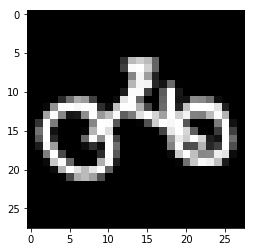

In [9]:
plot_image(quickdraws[12])

In [10]:
#Normalize data
data_X = quickdraws/255.

In [13]:
# number of batches for a single epoch
num_batches = len(data_X) // batch_size

dataset_name = 'bicycles'

#Make the file path and name
model_dir = "{}_{}_{}_{}".format(
            model_name, dataset_name,
            batch_size, z_dim)

## The Discriminator and Generator

In [14]:
def discriminator( x, is_training=True, reuse=False):
    with tf.variable_scope("discriminator", reuse=reuse):

        net = lrelu(conv2d(x, 64, 4, 4, 2, 2, name='d_conv1'))
        net = lrelu(bn(conv2d(net, 128, 4, 4, 2, 2, name='d_conv2'), is_training=is_training, scope='d_bn2'))
        net = tf.reshape(net, [batch_size, -1])
        net = lrelu(bn(linear(net, 1024, scope='d_fc3'), is_training=is_training, scope='d_bn3'))
        out_logit = linear(net, 1, scope='d_fc4')
        out = tf.nn.sigmoid(out_logit)

        return out, out_logit, net

In [15]:
def generator( z, is_training=True, reuse=False):
    with tf.variable_scope("generator", reuse=reuse):
        net = tf.nn.relu(bn(linear(z, 1024, scope='g_fc1'), is_training=is_training, scope='g_bn1'))
        net = tf.nn.relu(bn(linear(net, 128 * 7 * 7, scope='g_fc2'), is_training=is_training, scope='g_bn2'))
        net = tf.reshape(net, [batch_size, 7, 7, 128])
        net = tf.nn.relu(
            bn(deconv2d(net, [batch_size, 14, 14, 64], 4, 4, 2, 2, name='g_dc3'), is_training=is_training,
               scope='g_bn3'))

        out = tf.nn.sigmoid(deconv2d(net, [batch_size, 28, 28, 1], 4, 4, 2, 2, name='g_dc4'))

        return out

## Putting the model together

In [16]:
#creating the model

# some parameters
image_dims = [input_height, input_width, c_dim]
bs = batch_size

In [17]:
# Our placeholders where data will be placed in
# images
inputs = tf.placeholder(tf.float32, [bs] + image_dims, name='real_images')

# noises
z = tf.placeholder(tf.float32, [bs, z_dim], name='z')

#### Adversarial Loss Function

In [18]:

# output of D for real images
D_real, D_real_logits, _ = discriminator(inputs, is_training=True, reuse=False)

# output of D for fake images
G = generator(z, is_training=True, reuse=False)
D_fake, D_fake_logits, _ = discriminator(G, is_training=True, reuse=True)

# get loss for discriminator
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, labels=tf.ones_like(D_real)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.zeros_like(D_fake)))

d_loss = d_loss_real + d_loss_fake

# get loss for generator
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.ones_like(D_fake)))

In [19]:
""" Make these variables trainable """
# divide trainable variables into a group for D and a group for G
t_vars = tf.trainable_variables()
d_vars = [var for var in t_vars if 'd_' in var.name]
g_vars = [var for var in t_vars if 'g_' in var.name]

### Optimization functions

In [20]:
# optimizers
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    d_optim = tf.train.AdamOptimizer(learning_rate, beta1=beta1) \
              .minimize(d_loss, var_list=d_vars)
    g_optim = tf.train.AdamOptimizer(learning_rate*5, beta1=beta1) \
              .minimize(g_loss, var_list=g_vars)

In [21]:
"""" For sampling and creating some images to print out """
# for test
fake_images = generator(z, is_training=False, reuse=True)

#### Tensorboard tracking

In [22]:
""" Summary """
d_loss_real_sum = tf.summary.scalar("d_loss_real", d_loss_real)
d_loss_fake_sum = tf.summary.scalar("d_loss_fake", d_loss_fake)
d_loss_sum = tf.summary.scalar("d_loss", d_loss)
g_loss_sum = tf.summary.scalar("g_loss", g_loss)

# final summary operations
g_sum = tf.summary.merge([d_loss_fake_sum, g_loss_sum])
d_sum = tf.summary.merge([d_loss_real_sum, d_loss_sum])

In [23]:
def visualize_results( epoch):
    tot_num_samples = min(sample_num, batch_size)
    image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))

    """ random condition, random noise """

    z_sample = np.random.uniform(-1, 1, size=(batch_size, z_dim))

    samples = sess.run(fake_images, feed_dict={z: z_sample})

    save_images(samples[:image_frame_dim * image_frame_dim, :, :, :], [image_frame_dim, image_frame_dim],
                check_folder(result_dir + '/' + model_dir) + '/' + model_name + '_epoch%03d' % epoch + '_test_all_classes.png')

In [24]:
def load( checkpoint_dir):
    import re
    print(" [*] Reading checkpoints...")
    checkpoint_dir = os.path.join(checkpoint_dir, model_dir, model_name)

    ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
    if ckpt and ckpt.model_checkpoint_path:
        ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
        saver.restore(sess, os.path.join(checkpoint_dir, ckpt_name))
        counter = int(next(re.finditer("(\d+)(?!.*\d)",ckpt_name)).group(0))
        print(" [*] Successfully read {}".format(ckpt_name))
        return True, counter
    else:
        print(" [*] Failed to find a checkpoint")
        return False, 0

In [25]:
def save(checkpoint_dir, step):
    checkpoint_dir = os.path.join(checkpoint_dir, model_dir, model_name)

    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    saver.save(sess,os.path.join(checkpoint_dir, model_name+'.model'), global_step=step)

## The Training Loop

In [26]:

with tf.Session(config=tf.ConfigProto(allow_soft_placement=False)) as sess:
    # initialize all variables
    tf.global_variables_initializer().run()

    # graph inputs for visualize training results
    sample_z = np.random.uniform(-1, 1, size=(batch_size , z_dim))

    # saver to save model
    saver = tf.train.Saver()

    # summary writer
    writer = tf.summary.FileWriter(log_dir + '/' + model_name, sess.graph)

    # restore check-point if it exits
    could_load, checkpoint_counter = load(checkpoint_dir)
    if could_load:
        start_epoch = (int)(checkpoint_counter / num_batches)
        start_batch_id = checkpoint_counter - start_epoch * num_batches
        counter = checkpoint_counter
        print(" [*] Load SUCCESS")
    else:
        start_epoch = 0
        start_batch_id = 0
        counter = 1
        print(" [!] Load failed...")

    # loop for epoch
    start_time = time.time()
    print(start_time)
    for temp_epoch in range(start_epoch, epoch):

        # get batch data
        for idx in range(start_batch_id, num_batches):
            # get a batch of real images
            batch_images = data_X[idx*batch_size:(idx+1)*batch_size]
            # get a batch of random noise as input for generator
            batch_z = np.random.uniform(-1, 1, [batch_size, z_dim]).astype(np.float32)
            
            # update D network
            _, summary_str, dd_loss = sess.run([d_optim, d_sum, d_loss], feed_dict={inputs: batch_images, z: batch_z})
            writer.add_summary(summary_str, counter)

            # update G network
            _, summary_str, gg_loss = sess.run([g_optim, g_sum, g_loss], feed_dict={z: batch_z})
            writer.add_summary(summary_str, counter)

            # display training status
            counter += 1
            print("Epoch: [%2d] [%4d/%4d] time: %4.4f, d_loss: %.8f, g_loss: %.8f" \
                  % (temp_epoch, idx, num_batches, time.time() - start_time, dd_loss, gg_loss))

            # save training results for every 300 steps
            if np.mod(counter, 300) == 0:
                samples = sess.run(fake_images, feed_dict={z: sample_z})
                tot_num_samples = min(sample_num, batch_size)
                manifold_h = int(np.floor(np.sqrt(tot_num_samples)))
                manifold_w = int(np.floor(np.sqrt(tot_num_samples)))
                save_images(samples[:manifold_h * manifold_w, :, :, :], [manifold_h, manifold_w],
                            './' + check_folder(result_dir + '/' + model_dir) + '/' + model_name + '_train_{:02d}_{:04d}.png'.format(
                                temp_epoch, idx))

        # After an epoch, start_batch_id is set to zero
        # non-zero value is only for the first epoch after loading pre-trained model
        start_batch_id = 0

        # save model
        save(checkpoint_dir, counter)

        # show temporal results
        visualize_results(temp_epoch)

    # save model for final step
    save(checkpoint_dir, counter)

 [*] Reading checkpoints...
 [*] Failed to find a checkpoint
 [!] Load failed...
1510459743.9664142
Epoch: [ 0] [   0/3953] time: 0.2744, d_loss: 1.42537832, g_loss: 0.86717498
Epoch: [ 0] [   1/3953] time: 0.4409, d_loss: 1.45679092, g_loss: 0.79381603
Epoch: [ 0] [   2/3953] time: 0.6073, d_loss: 1.44367778, g_loss: 0.78158623
Epoch: [ 0] [   3/3953] time: 0.7812, d_loss: 1.42459345, g_loss: 0.77606344
Epoch: [ 0] [   4/3953] time: 0.9642, d_loss: 1.41071928, g_loss: 0.76490676
Epoch: [ 0] [   5/3953] time: 1.1414, d_loss: 1.42083061, g_loss: 0.77323735
Epoch: [ 0] [   6/3953] time: 1.3228, d_loss: 1.41671872, g_loss: 0.76706368
Epoch: [ 0] [   7/3953] time: 1.5015, d_loss: 1.41846836, g_loss: 0.76053810
Epoch: [ 0] [   8/3953] time: 1.6860, d_loss: 1.40457785, g_loss: 0.77269185
Epoch: [ 0] [   9/3953] time: 1.8655, d_loss: 1.40823197, g_loss: 0.76266420
Epoch: [ 0] [  10/3953] time: 2.0390, d_loss: 1.39348555, g_loss: 0.77719784
Epoch: [ 0] [  11/3953] time: 2.2053, d_loss: 1.41220

Epoch: [ 0] [ 106/3953] time: 19.0134, d_loss: 1.34341049, g_loss: 0.79208195
Epoch: [ 0] [ 107/3953] time: 19.2125, d_loss: 1.35033250, g_loss: 0.79306662
Epoch: [ 0] [ 108/3953] time: 19.4171, d_loss: 1.34928310, g_loss: 0.78655779
Epoch: [ 0] [ 109/3953] time: 19.6114, d_loss: 1.35565710, g_loss: 0.77917135
Epoch: [ 0] [ 110/3953] time: 19.7893, d_loss: 1.33906794, g_loss: 0.77868962
Epoch: [ 0] [ 111/3953] time: 19.9549, d_loss: 1.34205747, g_loss: 0.78264725
Epoch: [ 0] [ 112/3953] time: 20.1263, d_loss: 1.34485817, g_loss: 0.78060329
Epoch: [ 0] [ 113/3953] time: 20.2924, d_loss: 1.35739970, g_loss: 0.78249907
Epoch: [ 0] [ 114/3953] time: 20.4627, d_loss: 1.34355009, g_loss: 0.79187465
Epoch: [ 0] [ 115/3953] time: 20.6312, d_loss: 1.35989356, g_loss: 0.78064030
Epoch: [ 0] [ 116/3953] time: 20.8009, d_loss: 1.36796522, g_loss: 0.77709335
Epoch: [ 0] [ 117/3953] time: 20.9651, d_loss: 1.33412969, g_loss: 0.78124714
Epoch: [ 0] [ 118/3953] time: 21.1299, d_loss: 1.33593202, g_los

Epoch: [ 0] [ 213/3953] time: 38.3783, d_loss: 1.27390814, g_loss: 0.81198668
Epoch: [ 0] [ 214/3953] time: 38.5591, d_loss: 1.25683260, g_loss: 0.81977403
Epoch: [ 0] [ 215/3953] time: 38.7394, d_loss: 1.27485406, g_loss: 0.82193363
Epoch: [ 0] [ 216/3953] time: 38.9180, d_loss: 1.18559527, g_loss: 0.84159780
Epoch: [ 0] [ 217/3953] time: 39.1015, d_loss: 1.21439266, g_loss: 0.85422260
Epoch: [ 0] [ 218/3953] time: 39.2785, d_loss: 1.20058799, g_loss: 0.86448288
Epoch: [ 0] [ 219/3953] time: 39.4605, d_loss: 1.23255050, g_loss: 0.86134481
Epoch: [ 0] [ 220/3953] time: 39.6231, d_loss: 1.24606264, g_loss: 0.85895050
Epoch: [ 0] [ 221/3953] time: 39.7866, d_loss: 1.24832702, g_loss: 0.82491374
Epoch: [ 0] [ 222/3953] time: 39.9492, d_loss: 1.17730737, g_loss: 0.84724289
Epoch: [ 0] [ 223/3953] time: 40.1158, d_loss: 1.24832964, g_loss: 0.85845023
Epoch: [ 0] [ 224/3953] time: 40.2773, d_loss: 1.17899990, g_loss: 0.84202033
Epoch: [ 0] [ 225/3953] time: 40.4439, d_loss: 1.24809706, g_los

Epoch: [ 0] [ 319/3953] time: 57.7338, d_loss: 1.21718824, g_loss: 0.88636202
Epoch: [ 0] [ 320/3953] time: 57.8980, d_loss: 1.15005970, g_loss: 0.87712729
Epoch: [ 0] [ 321/3953] time: 58.0637, d_loss: 1.23235393, g_loss: 0.87937742
Epoch: [ 0] [ 322/3953] time: 58.2378, d_loss: 1.18251312, g_loss: 0.89439845
Epoch: [ 0] [ 323/3953] time: 58.4278, d_loss: 1.21399450, g_loss: 0.84925544
Epoch: [ 0] [ 324/3953] time: 58.5991, d_loss: 1.21086979, g_loss: 0.88191664
Epoch: [ 0] [ 325/3953] time: 58.7675, d_loss: 1.22692442, g_loss: 0.91566074
Epoch: [ 0] [ 326/3953] time: 58.9384, d_loss: 1.14895511, g_loss: 0.91440666
Epoch: [ 0] [ 327/3953] time: 59.1077, d_loss: 1.21680856, g_loss: 0.89244646
Epoch: [ 0] [ 328/3953] time: 59.2916, d_loss: 1.31826043, g_loss: 0.89454651
Epoch: [ 0] [ 329/3953] time: 59.4713, d_loss: 1.15725911, g_loss: 0.90790886
Epoch: [ 0] [ 330/3953] time: 59.6395, d_loss: 1.22597647, g_loss: 0.87724370
Epoch: [ 0] [ 331/3953] time: 59.8106, d_loss: 1.30673492, g_los

Epoch: [ 0] [ 425/3953] time: 76.5838, d_loss: 1.28258443, g_loss: 0.81864345
Epoch: [ 0] [ 426/3953] time: 76.7752, d_loss: 1.35317302, g_loss: 0.89546549
Epoch: [ 0] [ 427/3953] time: 76.9717, d_loss: 1.28238606, g_loss: 0.83087009
Epoch: [ 0] [ 428/3953] time: 77.1838, d_loss: 1.25503623, g_loss: 0.80931842
Epoch: [ 0] [ 429/3953] time: 77.3802, d_loss: 1.40644717, g_loss: 0.82238442
Epoch: [ 0] [ 430/3953] time: 77.6023, d_loss: 1.31593537, g_loss: 0.85195524
Epoch: [ 0] [ 431/3953] time: 77.7894, d_loss: 1.23277211, g_loss: 0.83166277
Epoch: [ 0] [ 432/3953] time: 78.0036, d_loss: 1.32657111, g_loss: 0.80015540
Epoch: [ 0] [ 433/3953] time: 78.1952, d_loss: 1.30199850, g_loss: 0.77542496
Epoch: [ 0] [ 434/3953] time: 78.4126, d_loss: 1.25900936, g_loss: 0.77685326
Epoch: [ 0] [ 435/3953] time: 78.5968, d_loss: 1.32886863, g_loss: 0.83086455
Epoch: [ 0] [ 436/3953] time: 78.8085, d_loss: 1.35689783, g_loss: 0.89886630
Epoch: [ 0] [ 437/3953] time: 78.9950, d_loss: 1.36810017, g_los

Epoch: [ 0] [ 532/3953] time: 96.7970, d_loss: 1.28381014, g_loss: 0.79634124
Epoch: [ 0] [ 533/3953] time: 96.9614, d_loss: 1.37099135, g_loss: 0.81813645
Epoch: [ 0] [ 534/3953] time: 97.1330, d_loss: 1.28076673, g_loss: 0.80928206
Epoch: [ 0] [ 535/3953] time: 97.3107, d_loss: 1.24959493, g_loss: 0.79539627
Epoch: [ 0] [ 536/3953] time: 97.4849, d_loss: 1.32231033, g_loss: 0.82609028
Epoch: [ 0] [ 537/3953] time: 97.6531, d_loss: 1.33493125, g_loss: 0.79645389
Epoch: [ 0] [ 538/3953] time: 97.8191, d_loss: 1.30897236, g_loss: 0.79571873
Epoch: [ 0] [ 539/3953] time: 97.9859, d_loss: 1.34326315, g_loss: 0.83094597
Epoch: [ 0] [ 540/3953] time: 98.1582, d_loss: 1.31178689, g_loss: 0.83029491
Epoch: [ 0] [ 541/3953] time: 98.3213, d_loss: 1.35732281, g_loss: 0.80035019
Epoch: [ 0] [ 542/3953] time: 98.4951, d_loss: 1.31513000, g_loss: 0.81184357
Epoch: [ 0] [ 543/3953] time: 98.6765, d_loss: 1.32538617, g_loss: 0.82546604
Epoch: [ 0] [ 544/3953] time: 98.8682, d_loss: 1.29878747, g_los

Epoch: [ 0] [ 636/3953] time: 115.1388, d_loss: 1.32139242, g_loss: 0.79764140
Epoch: [ 0] [ 637/3953] time: 115.3071, d_loss: 1.33320451, g_loss: 0.78152597
Epoch: [ 0] [ 638/3953] time: 115.4803, d_loss: 1.32308531, g_loss: 0.80908722
Epoch: [ 0] [ 639/3953] time: 115.6540, d_loss: 1.30849552, g_loss: 0.82838684
Epoch: [ 0] [ 640/3953] time: 115.8433, d_loss: 1.32295632, g_loss: 0.85009855
Epoch: [ 0] [ 641/3953] time: 116.0324, d_loss: 1.27930737, g_loss: 0.85397750
Epoch: [ 0] [ 642/3953] time: 116.2135, d_loss: 1.34028125, g_loss: 0.82864743
Epoch: [ 0] [ 643/3953] time: 116.3906, d_loss: 1.31862783, g_loss: 0.82535946
Epoch: [ 0] [ 644/3953] time: 116.5738, d_loss: 1.35461950, g_loss: 0.81805289
Epoch: [ 0] [ 645/3953] time: 116.7597, d_loss: 1.37889242, g_loss: 0.83086491
Epoch: [ 0] [ 646/3953] time: 116.9623, d_loss: 1.36477649, g_loss: 0.78300637
Epoch: [ 0] [ 647/3953] time: 117.1291, d_loss: 1.36586761, g_loss: 0.79587024
Epoch: [ 0] [ 648/3953] time: 117.2963, d_loss: 1.31

Epoch: [ 0] [ 740/3953] time: 133.2497, d_loss: 1.35426998, g_loss: 0.78949189
Epoch: [ 0] [ 741/3953] time: 133.4173, d_loss: 1.31120062, g_loss: 0.80413353
Epoch: [ 0] [ 742/3953] time: 133.5872, d_loss: 1.25094151, g_loss: 0.83196211
Epoch: [ 0] [ 743/3953] time: 133.7567, d_loss: 1.42724311, g_loss: 0.81699020
Epoch: [ 0] [ 744/3953] time: 133.9212, d_loss: 1.35846007, g_loss: 0.77130795
Epoch: [ 0] [ 745/3953] time: 134.0864, d_loss: 1.30365610, g_loss: 0.81017911
Epoch: [ 0] [ 746/3953] time: 134.2486, d_loss: 1.34648776, g_loss: 0.84778440
Epoch: [ 0] [ 747/3953] time: 134.4132, d_loss: 1.32565236, g_loss: 0.84789145
Epoch: [ 0] [ 748/3953] time: 134.5952, d_loss: 1.33623075, g_loss: 0.81260514
Epoch: [ 0] [ 749/3953] time: 134.7580, d_loss: 1.27196264, g_loss: 0.83445168
Epoch: [ 0] [ 750/3953] time: 134.9270, d_loss: 1.37859368, g_loss: 0.77045506
Epoch: [ 0] [ 751/3953] time: 135.0929, d_loss: 1.25278127, g_loss: 0.81325197
Epoch: [ 0] [ 752/3953] time: 135.2599, d_loss: 1.29

Epoch: [ 0] [ 844/3953] time: 151.3122, d_loss: 1.36389291, g_loss: 0.82417321
Epoch: [ 0] [ 845/3953] time: 151.4776, d_loss: 1.40818560, g_loss: 0.81773055
Epoch: [ 0] [ 846/3953] time: 151.6469, d_loss: 1.34055734, g_loss: 0.85623968
Epoch: [ 0] [ 847/3953] time: 151.8105, d_loss: 1.31361008, g_loss: 0.83030212
Epoch: [ 0] [ 848/3953] time: 151.9833, d_loss: 1.35690618, g_loss: 0.78530055
Epoch: [ 0] [ 849/3953] time: 152.1542, d_loss: 1.30212986, g_loss: 0.82320505
Epoch: [ 0] [ 850/3953] time: 152.3184, d_loss: 1.28320312, g_loss: 0.83222091
Epoch: [ 0] [ 851/3953] time: 152.4873, d_loss: 1.33575678, g_loss: 0.83292383
Epoch: [ 0] [ 852/3953] time: 152.6560, d_loss: 1.30579686, g_loss: 0.81995422
Epoch: [ 0] [ 853/3953] time: 152.8373, d_loss: 1.31436157, g_loss: 0.80974334
Epoch: [ 0] [ 854/3953] time: 153.0180, d_loss: 1.44330645, g_loss: 0.80325437
Epoch: [ 0] [ 855/3953] time: 153.1969, d_loss: 1.33334041, g_loss: 0.83275676
Epoch: [ 0] [ 856/3953] time: 153.3786, d_loss: 1.30

Epoch: [ 0] [ 948/3953] time: 169.3674, d_loss: 1.33883953, g_loss: 0.81706107
Epoch: [ 0] [ 949/3953] time: 169.5386, d_loss: 1.38065183, g_loss: 0.82851815
Epoch: [ 0] [ 950/3953] time: 169.7109, d_loss: 1.33273351, g_loss: 0.82754749
Epoch: [ 0] [ 951/3953] time: 169.8737, d_loss: 1.33455920, g_loss: 0.84710747
Epoch: [ 0] [ 952/3953] time: 170.0543, d_loss: 1.33334184, g_loss: 0.81732333
Epoch: [ 0] [ 953/3953] time: 170.2332, d_loss: 1.32150590, g_loss: 0.81353790
Epoch: [ 0] [ 954/3953] time: 170.4173, d_loss: 1.36518335, g_loss: 0.80955517
Epoch: [ 0] [ 955/3953] time: 170.5948, d_loss: 1.40632606, g_loss: 0.78786510
Epoch: [ 0] [ 956/3953] time: 170.7776, d_loss: 1.31205702, g_loss: 0.79649174
Epoch: [ 0] [ 957/3953] time: 170.9548, d_loss: 1.39867187, g_loss: 0.81855923
Epoch: [ 0] [ 958/3953] time: 171.1405, d_loss: 1.30779600, g_loss: 0.79027820
Epoch: [ 0] [ 959/3953] time: 171.3163, d_loss: 1.31224775, g_loss: 0.83759892
Epoch: [ 0] [ 960/3953] time: 171.4995, d_loss: 1.31

Epoch: [ 0] [1052/3953] time: 187.4604, d_loss: 1.32659793, g_loss: 0.82475054
Epoch: [ 0] [1053/3953] time: 187.6397, d_loss: 1.27423966, g_loss: 0.84744871
Epoch: [ 0] [1054/3953] time: 187.8211, d_loss: 1.34816289, g_loss: 0.82797360
Epoch: [ 0] [1055/3953] time: 187.9949, d_loss: 1.24697590, g_loss: 0.80470681
Epoch: [ 0] [1056/3953] time: 188.1590, d_loss: 1.32312989, g_loss: 0.83356941
Epoch: [ 0] [1057/3953] time: 188.3243, d_loss: 1.29571438, g_loss: 0.84453815
Epoch: [ 0] [1058/3953] time: 188.4917, d_loss: 1.36576176, g_loss: 0.84891689
Epoch: [ 0] [1059/3953] time: 188.6635, d_loss: 1.30029964, g_loss: 0.86362422
Epoch: [ 0] [1060/3953] time: 188.8305, d_loss: 1.40585506, g_loss: 0.85574484
Epoch: [ 0] [1061/3953] time: 188.9977, d_loss: 1.31008077, g_loss: 0.86285639
Epoch: [ 0] [1062/3953] time: 189.1627, d_loss: 1.36927485, g_loss: 0.81992471
Epoch: [ 0] [1063/3953] time: 189.3264, d_loss: 1.29990590, g_loss: 0.83400345
Epoch: [ 0] [1064/3953] time: 189.5098, d_loss: 1.34

Epoch: [ 0] [1156/3953] time: 205.4577, d_loss: 1.34525204, g_loss: 0.91598690
Epoch: [ 0] [1157/3953] time: 205.6316, d_loss: 1.39833474, g_loss: 0.86327124
Epoch: [ 0] [1158/3953] time: 205.8101, d_loss: 1.29328310, g_loss: 0.83062696
Epoch: [ 0] [1159/3953] time: 205.9896, d_loss: 1.29031396, g_loss: 0.83476055
Epoch: [ 0] [1160/3953] time: 206.1759, d_loss: 1.43752170, g_loss: 0.81981707
Epoch: [ 0] [1161/3953] time: 206.3520, d_loss: 1.26487744, g_loss: 0.83118153
Epoch: [ 0] [1162/3953] time: 206.5387, d_loss: 1.33393621, g_loss: 0.81534594
Epoch: [ 0] [1163/3953] time: 206.7183, d_loss: 1.28758168, g_loss: 0.80020797
Epoch: [ 0] [1164/3953] time: 206.8897, d_loss: 1.33263314, g_loss: 0.80652595
Epoch: [ 0] [1165/3953] time: 207.0554, d_loss: 1.27351236, g_loss: 0.82762229
Epoch: [ 0] [1166/3953] time: 207.2198, d_loss: 1.30208135, g_loss: 0.85511005
Epoch: [ 0] [1167/3953] time: 207.3853, d_loss: 1.26089466, g_loss: 0.87811410
Epoch: [ 0] [1168/3953] time: 207.5589, d_loss: 1.26

Epoch: [ 0] [1260/3953] time: 223.5172, d_loss: 1.35484529, g_loss: 0.78628814
Epoch: [ 0] [1261/3953] time: 223.6853, d_loss: 1.30728006, g_loss: 0.80678672
Epoch: [ 0] [1262/3953] time: 223.8495, d_loss: 1.27794981, g_loss: 0.81128192
Epoch: [ 0] [1263/3953] time: 224.0405, d_loss: 1.33471370, g_loss: 0.81792831
Epoch: [ 0] [1264/3953] time: 224.2233, d_loss: 1.25784492, g_loss: 0.83860457
Epoch: [ 0] [1265/3953] time: 224.4035, d_loss: 1.30249405, g_loss: 0.87131655
Epoch: [ 0] [1266/3953] time: 224.5865, d_loss: 1.34165204, g_loss: 0.85934091
Epoch: [ 0] [1267/3953] time: 224.7671, d_loss: 1.29559481, g_loss: 0.84958732
Epoch: [ 0] [1268/3953] time: 224.9478, d_loss: 1.30040956, g_loss: 0.86334610
Epoch: [ 0] [1269/3953] time: 225.1292, d_loss: 1.29189372, g_loss: 0.85412776
Epoch: [ 0] [1270/3953] time: 225.2983, d_loss: 1.30088615, g_loss: 0.84264600
Epoch: [ 0] [1271/3953] time: 225.4688, d_loss: 1.34737468, g_loss: 0.83200562
Epoch: [ 0] [1272/3953] time: 225.6361, d_loss: 1.35

Epoch: [ 0] [1365/3953] time: 242.0949, d_loss: 1.39105654, g_loss: 0.81592375
Epoch: [ 0] [1366/3953] time: 242.2678, d_loss: 1.28479195, g_loss: 0.83172649
Epoch: [ 0] [1367/3953] time: 242.4450, d_loss: 1.33430731, g_loss: 0.87010616
Epoch: [ 0] [1368/3953] time: 242.6171, d_loss: 1.33136582, g_loss: 0.87737983
Epoch: [ 0] [1369/3953] time: 242.7844, d_loss: 1.35855865, g_loss: 0.91427392
Epoch: [ 0] [1370/3953] time: 242.9495, d_loss: 1.29459536, g_loss: 0.91278756
Epoch: [ 0] [1371/3953] time: 243.1285, d_loss: 1.27841580, g_loss: 0.89894760
Epoch: [ 0] [1372/3953] time: 243.3066, d_loss: 1.29281425, g_loss: 0.87736982
Epoch: [ 0] [1373/3953] time: 243.4925, d_loss: 1.29571855, g_loss: 0.83084118
Epoch: [ 0] [1374/3953] time: 243.6688, d_loss: 1.26354110, g_loss: 0.85232806
Epoch: [ 0] [1375/3953] time: 243.8476, d_loss: 1.30747712, g_loss: 0.84814084
Epoch: [ 0] [1376/3953] time: 244.0320, d_loss: 1.34064651, g_loss: 0.84844625
Epoch: [ 0] [1377/3953] time: 244.2260, d_loss: 1.37

Epoch: [ 0] [1469/3953] time: 261.0796, d_loss: 1.32729959, g_loss: 0.85490716
Epoch: [ 0] [1470/3953] time: 261.2608, d_loss: 1.24847984, g_loss: 0.88303339
Epoch: [ 0] [1471/3953] time: 261.4467, d_loss: 1.34414244, g_loss: 0.82592058
Epoch: [ 0] [1472/3953] time: 261.6286, d_loss: 1.28488481, g_loss: 0.83471835
Epoch: [ 0] [1473/3953] time: 261.8051, d_loss: 1.38392854, g_loss: 0.82877207
Epoch: [ 0] [1474/3953] time: 261.9738, d_loss: 1.36886573, g_loss: 0.83461022
Epoch: [ 0] [1475/3953] time: 262.1393, d_loss: 1.34870839, g_loss: 0.87650263
Epoch: [ 0] [1476/3953] time: 262.3028, d_loss: 1.32951450, g_loss: 0.84255004
Epoch: [ 0] [1477/3953] time: 262.4712, d_loss: 1.28146625, g_loss: 0.84237719
Epoch: [ 0] [1478/3953] time: 262.6377, d_loss: 1.31684399, g_loss: 0.85242772
Epoch: [ 0] [1479/3953] time: 262.8049, d_loss: 1.40764356, g_loss: 0.82218134
Epoch: [ 0] [1480/3953] time: 262.9697, d_loss: 1.37466693, g_loss: 0.83128685
Epoch: [ 0] [1481/3953] time: 263.1550, d_loss: 1.29

Epoch: [ 0] [1573/3953] time: 279.2485, d_loss: 1.27176797, g_loss: 0.83651310
Epoch: [ 0] [1574/3953] time: 279.4153, d_loss: 1.38040948, g_loss: 0.83336687
Epoch: [ 0] [1575/3953] time: 279.5830, d_loss: 1.34253573, g_loss: 0.84040821
Epoch: [ 0] [1576/3953] time: 279.7445, d_loss: 1.31143034, g_loss: 0.81225896
Epoch: [ 0] [1577/3953] time: 279.9080, d_loss: 1.34623909, g_loss: 0.81576681
Epoch: [ 0] [1578/3953] time: 280.0831, d_loss: 1.31985605, g_loss: 0.81996673
Epoch: [ 0] [1579/3953] time: 280.2601, d_loss: 1.23077464, g_loss: 0.79702425
Epoch: [ 0] [1580/3953] time: 280.4353, d_loss: 1.22641802, g_loss: 0.82509428
Epoch: [ 0] [1581/3953] time: 280.6182, d_loss: 1.33289862, g_loss: 0.81875849
Epoch: [ 0] [1582/3953] time: 280.7962, d_loss: 1.22520959, g_loss: 0.86026853
Epoch: [ 0] [1583/3953] time: 280.9783, d_loss: 1.28896427, g_loss: 0.85827690
Epoch: [ 0] [1584/3953] time: 281.1541, d_loss: 1.30807579, g_loss: 0.86414856
Epoch: [ 0] [1585/3953] time: 281.3359, d_loss: 1.34

Epoch: [ 0] [1677/3953] time: 297.3847, d_loss: 1.36417603, g_loss: 0.88790190
Epoch: [ 0] [1678/3953] time: 297.5515, d_loss: 1.30928540, g_loss: 0.85565925
Epoch: [ 0] [1679/3953] time: 297.7130, d_loss: 1.44272196, g_loss: 0.86993551
Epoch: [ 0] [1680/3953] time: 297.8751, d_loss: 1.30461884, g_loss: 0.84533107
Epoch: [ 0] [1681/3953] time: 298.0433, d_loss: 1.32031155, g_loss: 0.85704744
Epoch: [ 0] [1682/3953] time: 298.2071, d_loss: 1.32049966, g_loss: 0.84375185
Epoch: [ 0] [1683/3953] time: 298.3752, d_loss: 1.33401680, g_loss: 0.88858944
Epoch: [ 0] [1684/3953] time: 298.5544, d_loss: 1.29638791, g_loss: 0.83523834
Epoch: [ 0] [1685/3953] time: 298.7232, d_loss: 1.32182479, g_loss: 0.84571564
Epoch: [ 0] [1686/3953] time: 298.8901, d_loss: 1.31274796, g_loss: 0.80724138
Epoch: [ 0] [1687/3953] time: 299.0578, d_loss: 1.23324919, g_loss: 0.84962136
Epoch: [ 0] [1688/3953] time: 299.2252, d_loss: 1.29328942, g_loss: 0.80796635
Epoch: [ 0] [1689/3953] time: 299.4039, d_loss: 1.34

Epoch: [ 0] [1781/3953] time: 315.3293, d_loss: 1.24838483, g_loss: 0.83437169
Epoch: [ 0] [1782/3953] time: 315.4946, d_loss: 1.28308892, g_loss: 0.83111346
Epoch: [ 0] [1783/3953] time: 315.6684, d_loss: 1.33559775, g_loss: 0.85114282
Epoch: [ 0] [1784/3953] time: 315.8306, d_loss: 1.32517254, g_loss: 0.87590724
Epoch: [ 0] [1785/3953] time: 315.9960, d_loss: 1.28698826, g_loss: 0.88947415
Epoch: [ 0] [1786/3953] time: 316.1598, d_loss: 1.27242720, g_loss: 0.85655856
Epoch: [ 0] [1787/3953] time: 316.3252, d_loss: 1.33021760, g_loss: 0.88404953
Epoch: [ 0] [1788/3953] time: 316.4924, d_loss: 1.29041970, g_loss: 0.85932297
Epoch: [ 0] [1789/3953] time: 316.6645, d_loss: 1.38696408, g_loss: 0.82866871
Epoch: [ 0] [1790/3953] time: 316.8418, d_loss: 1.32626963, g_loss: 0.87875456
Epoch: [ 0] [1791/3953] time: 317.0221, d_loss: 1.28642881, g_loss: 0.87253261
Epoch: [ 0] [1792/3953] time: 317.2055, d_loss: 1.31208920, g_loss: 0.86442709
Epoch: [ 0] [1793/3953] time: 317.3823, d_loss: 1.29

Epoch: [ 0] [1885/3953] time: 333.5391, d_loss: 1.30401540, g_loss: 0.90470994
Epoch: [ 0] [1886/3953] time: 333.7046, d_loss: 1.32614899, g_loss: 0.86138868
Epoch: [ 0] [1887/3953] time: 333.8705, d_loss: 1.26203930, g_loss: 0.87875330
Epoch: [ 0] [1888/3953] time: 334.0336, d_loss: 1.39513206, g_loss: 0.91309458
Epoch: [ 0] [1889/3953] time: 334.2005, d_loss: 1.28622758, g_loss: 0.94480538
Epoch: [ 0] [1890/3953] time: 334.3585, d_loss: 1.36205053, g_loss: 0.87396467
Epoch: [ 0] [1891/3953] time: 334.5419, d_loss: 1.27172673, g_loss: 0.84607077
Epoch: [ 0] [1892/3953] time: 334.7153, d_loss: 1.33760417, g_loss: 0.85424614
Epoch: [ 0] [1893/3953] time: 334.8965, d_loss: 1.37388754, g_loss: 0.82051140
Epoch: [ 0] [1894/3953] time: 335.0791, d_loss: 1.30274189, g_loss: 0.88075572
Epoch: [ 0] [1895/3953] time: 335.2597, d_loss: 1.31256676, g_loss: 0.86645758
Epoch: [ 0] [1896/3953] time: 335.4381, d_loss: 1.36406684, g_loss: 0.83128160
Epoch: [ 0] [1897/3953] time: 335.6187, d_loss: 1.36

Epoch: [ 0] [1989/3953] time: 351.6837, d_loss: 1.45296001, g_loss: 0.94578320
Epoch: [ 0] [1990/3953] time: 351.8586, d_loss: 1.32241619, g_loss: 0.97139329
Epoch: [ 0] [1991/3953] time: 352.0406, d_loss: 1.23708844, g_loss: 0.90506399
Epoch: [ 0] [1992/3953] time: 352.2061, d_loss: 1.28018308, g_loss: 0.89232242
Epoch: [ 0] [1993/3953] time: 352.3718, d_loss: 1.34046924, g_loss: 0.84255242
Epoch: [ 0] [1994/3953] time: 352.5359, d_loss: 1.34691930, g_loss: 0.81350976
Epoch: [ 0] [1995/3953] time: 352.7054, d_loss: 1.31816304, g_loss: 0.80054104
Epoch: [ 0] [1996/3953] time: 352.8822, d_loss: 1.30234826, g_loss: 0.78976166
Epoch: [ 0] [1997/3953] time: 353.0510, d_loss: 1.34203982, g_loss: 0.78694177
Epoch: [ 0] [1998/3953] time: 353.2159, d_loss: 1.27581704, g_loss: 0.88886237
Epoch: [ 0] [1999/3953] time: 353.3832, d_loss: 1.37655902, g_loss: 0.87773734
Epoch: [ 0] [2000/3953] time: 353.5539, d_loss: 1.34228849, g_loss: 0.89727932
Epoch: [ 0] [2001/3953] time: 353.7221, d_loss: 1.27

Epoch: [ 0] [2093/3953] time: 369.6183, d_loss: 1.38194180, g_loss: 0.87985229
Epoch: [ 0] [2094/3953] time: 369.7955, d_loss: 1.35485649, g_loss: 0.86859930
Epoch: [ 0] [2095/3953] time: 369.9753, d_loss: 1.30461168, g_loss: 0.95241392
Epoch: [ 0] [2096/3953] time: 370.1499, d_loss: 1.32375109, g_loss: 0.93074155
Epoch: [ 0] [2097/3953] time: 370.3166, d_loss: 1.26615691, g_loss: 0.85413027
Epoch: [ 0] [2098/3953] time: 370.4825, d_loss: 1.35684967, g_loss: 0.94339454
Epoch: [ 0] [2099/3953] time: 370.6751, d_loss: 1.28238571, g_loss: 0.90060484
Epoch: [ 0] [2100/3953] time: 370.8424, d_loss: 1.31344080, g_loss: 0.88657153
Epoch: [ 0] [2101/3953] time: 371.0122, d_loss: 1.28045702, g_loss: 0.90204000
Epoch: [ 0] [2102/3953] time: 371.1796, d_loss: 1.29407012, g_loss: 0.88001955
Epoch: [ 0] [2103/3953] time: 371.3568, d_loss: 1.26802254, g_loss: 0.88954723
Epoch: [ 0] [2104/3953] time: 371.5400, d_loss: 1.28857207, g_loss: 0.85005116
Epoch: [ 0] [2105/3953] time: 371.7256, d_loss: 1.37

Epoch: [ 0] [2197/3953] time: 387.7670, d_loss: 1.29925966, g_loss: 0.91517055
Epoch: [ 0] [2198/3953] time: 387.9391, d_loss: 1.25461006, g_loss: 0.96652770
Epoch: [ 0] [2199/3953] time: 388.1175, d_loss: 1.25222087, g_loss: 0.90815532
Epoch: [ 0] [2200/3953] time: 388.2949, d_loss: 1.32106662, g_loss: 0.89443976
Epoch: [ 0] [2201/3953] time: 388.4823, d_loss: 1.28714764, g_loss: 0.87647152
Epoch: [ 0] [2202/3953] time: 388.6480, d_loss: 1.22340405, g_loss: 0.88203770
Epoch: [ 0] [2203/3953] time: 388.8141, d_loss: 1.27574801, g_loss: 0.87718034
Epoch: [ 0] [2204/3953] time: 388.9785, d_loss: 1.29641032, g_loss: 0.94404900
Epoch: [ 0] [2205/3953] time: 389.1588, d_loss: 1.30537367, g_loss: 0.87521124
Epoch: [ 0] [2206/3953] time: 389.3471, d_loss: 1.32723665, g_loss: 0.88025701
Epoch: [ 0] [2207/3953] time: 389.5349, d_loss: 1.26296234, g_loss: 0.87928426
Epoch: [ 0] [2208/3953] time: 389.7125, d_loss: 1.35840082, g_loss: 0.91622341
Epoch: [ 0] [2209/3953] time: 389.8958, d_loss: 1.29

Epoch: [ 0] [2301/3953] time: 406.1860, d_loss: 1.29988551, g_loss: 1.00095177
Epoch: [ 0] [2302/3953] time: 406.3727, d_loss: 1.34416807, g_loss: 0.97053093
Epoch: [ 0] [2303/3953] time: 406.5534, d_loss: 1.29185033, g_loss: 0.93594551
Epoch: [ 0] [2304/3953] time: 406.7189, d_loss: 1.21513426, g_loss: 0.84037924
Epoch: [ 0] [2305/3953] time: 406.8859, d_loss: 1.33379364, g_loss: 0.86771953
Epoch: [ 0] [2306/3953] time: 407.0528, d_loss: 1.24034202, g_loss: 0.84584886
Epoch: [ 0] [2307/3953] time: 407.2224, d_loss: 1.19322824, g_loss: 0.85376751
Epoch: [ 0] [2308/3953] time: 407.3885, d_loss: 1.26127219, g_loss: 0.85058093
Epoch: [ 0] [2309/3953] time: 407.5619, d_loss: 1.20759916, g_loss: 0.87528574
Epoch: [ 0] [2310/3953] time: 407.7305, d_loss: 1.29470229, g_loss: 0.93901300
Epoch: [ 0] [2311/3953] time: 407.8982, d_loss: 1.22469807, g_loss: 0.89981735
Epoch: [ 0] [2312/3953] time: 408.0672, d_loss: 1.30203581, g_loss: 0.90777701
Epoch: [ 0] [2313/3953] time: 408.2357, d_loss: 1.27

Epoch: [ 0] [2406/3953] time: 424.4197, d_loss: 1.14992917, g_loss: 0.85393107
Epoch: [ 0] [2407/3953] time: 424.5882, d_loss: 1.30382907, g_loss: 0.81494963
Epoch: [ 0] [2408/3953] time: 424.7574, d_loss: 1.32625937, g_loss: 0.85894811
Epoch: [ 0] [2409/3953] time: 424.9219, d_loss: 1.43131948, g_loss: 0.83796656
Epoch: [ 0] [2410/3953] time: 425.1080, d_loss: 1.39494634, g_loss: 0.87605703
Epoch: [ 0] [2411/3953] time: 425.2862, d_loss: 1.29513097, g_loss: 0.89782977
Epoch: [ 0] [2412/3953] time: 425.4743, d_loss: 1.36704779, g_loss: 0.84074628
Epoch: [ 0] [2413/3953] time: 425.6529, d_loss: 1.25059533, g_loss: 0.82123339
Epoch: [ 0] [2414/3953] time: 425.8389, d_loss: 1.28480434, g_loss: 0.88209134
Epoch: [ 0] [2415/3953] time: 426.0197, d_loss: 1.29032147, g_loss: 0.81962645
Epoch: [ 0] [2416/3953] time: 426.1945, d_loss: 1.26410913, g_loss: 0.78507793
Epoch: [ 0] [2417/3953] time: 426.3640, d_loss: 1.20507467, g_loss: 0.86019593
Epoch: [ 0] [2418/3953] time: 426.5440, d_loss: 1.30

Epoch: [ 0] [2510/3953] time: 442.5257, d_loss: 1.17204928, g_loss: 0.88946640
Epoch: [ 0] [2511/3953] time: 442.7042, d_loss: 1.35213947, g_loss: 0.83491558
Epoch: [ 0] [2512/3953] time: 442.8839, d_loss: 1.31221819, g_loss: 0.84937805
Epoch: [ 0] [2513/3953] time: 443.0658, d_loss: 1.37902331, g_loss: 0.94076920
Epoch: [ 0] [2514/3953] time: 443.2465, d_loss: 1.40749049, g_loss: 1.05353737
Epoch: [ 0] [2515/3953] time: 443.4260, d_loss: 1.28775644, g_loss: 0.94431728
Epoch: [ 0] [2516/3953] time: 443.6054, d_loss: 1.29802537, g_loss: 0.91989863
Epoch: [ 0] [2517/3953] time: 443.7807, d_loss: 1.23850167, g_loss: 0.94521713
Epoch: [ 0] [2518/3953] time: 443.9616, d_loss: 1.24861741, g_loss: 0.96123260
Epoch: [ 0] [2519/3953] time: 444.1286, d_loss: 1.36922216, g_loss: 0.81448090
Epoch: [ 0] [2520/3953] time: 444.2985, d_loss: 1.30450571, g_loss: 0.82919061
Epoch: [ 0] [2521/3953] time: 444.4639, d_loss: 1.35425603, g_loss: 0.81425333
Epoch: [ 0] [2522/3953] time: 444.6414, d_loss: 1.27

Epoch: [ 0] [2614/3953] time: 460.5840, d_loss: 1.25387621, g_loss: 0.80966353
Epoch: [ 0] [2615/3953] time: 460.7504, d_loss: 1.20851851, g_loss: 0.87916565
Epoch: [ 0] [2616/3953] time: 460.9183, d_loss: 1.20288658, g_loss: 1.00503027
Epoch: [ 0] [2617/3953] time: 461.0872, d_loss: 1.28167248, g_loss: 1.03087831
Epoch: [ 0] [2618/3953] time: 461.2503, d_loss: 1.27485585, g_loss: 1.01241660
Epoch: [ 0] [2619/3953] time: 461.4240, d_loss: 1.21006966, g_loss: 1.10607517
Epoch: [ 0] [2620/3953] time: 461.5929, d_loss: 1.32833624, g_loss: 0.88010246
Epoch: [ 0] [2621/3953] time: 461.7580, d_loss: 1.20843339, g_loss: 0.90453267
Epoch: [ 0] [2622/3953] time: 461.9254, d_loss: 1.28371000, g_loss: 0.87370014
Epoch: [ 0] [2623/3953] time: 462.0923, d_loss: 1.21177268, g_loss: 0.89093947
Epoch: [ 0] [2624/3953] time: 462.2577, d_loss: 1.31777978, g_loss: 0.76223087
Epoch: [ 0] [2625/3953] time: 462.4226, d_loss: 1.20253479, g_loss: 0.88823974
Epoch: [ 0] [2626/3953] time: 462.5877, d_loss: 1.17

Epoch: [ 0] [2718/3953] time: 478.6036, d_loss: 1.17293286, g_loss: 1.02652693
Epoch: [ 0] [2719/3953] time: 478.7674, d_loss: 1.26251411, g_loss: 0.99528968
Epoch: [ 0] [2720/3953] time: 478.9333, d_loss: 1.16776085, g_loss: 0.98118341
Epoch: [ 0] [2721/3953] time: 479.0999, d_loss: 1.20064449, g_loss: 0.95689082
Epoch: [ 0] [2722/3953] time: 479.2718, d_loss: 1.22536922, g_loss: 0.92818022
Epoch: [ 0] [2723/3953] time: 479.4499, d_loss: 1.19926858, g_loss: 0.96300179
Epoch: [ 0] [2724/3953] time: 479.6352, d_loss: 1.26350379, g_loss: 1.04577875
Epoch: [ 0] [2725/3953] time: 479.8171, d_loss: 1.31415153, g_loss: 0.93327272
Epoch: [ 0] [2726/3953] time: 479.9981, d_loss: 1.18970144, g_loss: 0.92469132
Epoch: [ 0] [2727/3953] time: 480.1784, d_loss: 1.28049135, g_loss: 1.02202046
Epoch: [ 0] [2728/3953] time: 480.3627, d_loss: 1.34852242, g_loss: 1.01009762
Epoch: [ 0] [2729/3953] time: 480.5472, d_loss: 1.37599313, g_loss: 0.95691407
Epoch: [ 0] [2730/3953] time: 480.7127, d_loss: 1.16

Epoch: [ 0] [2822/3953] time: 496.5005, d_loss: 1.09004021, g_loss: 0.93526244
Epoch: [ 0] [2823/3953] time: 496.6844, d_loss: 1.19097018, g_loss: 0.83424878
Epoch: [ 0] [2824/3953] time: 496.8673, d_loss: 1.15360463, g_loss: 0.88040507
Epoch: [ 0] [2825/3953] time: 497.0496, d_loss: 1.10814142, g_loss: 0.88890386
Epoch: [ 0] [2826/3953] time: 497.2317, d_loss: 1.09191036, g_loss: 0.92745566
Epoch: [ 0] [2827/3953] time: 497.4112, d_loss: 1.23715830, g_loss: 0.87230551
Epoch: [ 0] [2828/3953] time: 497.5960, d_loss: 1.18391013, g_loss: 0.99642003
Epoch: [ 0] [2829/3953] time: 497.7738, d_loss: 1.10953772, g_loss: 1.08782184
Epoch: [ 0] [2830/3953] time: 497.9611, d_loss: 1.38952446, g_loss: 1.01094818
Epoch: [ 0] [2831/3953] time: 498.1405, d_loss: 1.20819473, g_loss: 0.89221239
Epoch: [ 0] [2832/3953] time: 498.3076, d_loss: 1.14173341, g_loss: 0.90633315
Epoch: [ 0] [2833/3953] time: 498.4724, d_loss: 1.11189735, g_loss: 0.92930639
Epoch: [ 0] [2834/3953] time: 498.6408, d_loss: 1.31

Epoch: [ 0] [2926/3953] time: 514.7549, d_loss: 1.16870070, g_loss: 0.98492527
Epoch: [ 0] [2927/3953] time: 514.9225, d_loss: 1.13508165, g_loss: 1.05997860
Epoch: [ 0] [2928/3953] time: 515.0924, d_loss: 1.19701040, g_loss: 0.95815945
Epoch: [ 0] [2929/3953] time: 515.2569, d_loss: 1.18767095, g_loss: 0.97572744
Epoch: [ 0] [2930/3953] time: 515.4237, d_loss: 1.24688983, g_loss: 1.05307603
Epoch: [ 0] [2931/3953] time: 515.5975, d_loss: 1.28862047, g_loss: 0.81617546
Epoch: [ 0] [2932/3953] time: 515.7795, d_loss: 1.10322571, g_loss: 0.95266515
Epoch: [ 0] [2933/3953] time: 515.9425, d_loss: 1.17978799, g_loss: 0.89387834
Epoch: [ 0] [2934/3953] time: 516.1072, d_loss: 1.27353072, g_loss: 0.89114946
Epoch: [ 0] [2935/3953] time: 516.2700, d_loss: 1.05136406, g_loss: 0.99267709
Epoch: [ 0] [2936/3953] time: 516.4386, d_loss: 1.31590652, g_loss: 0.95136821
Epoch: [ 0] [2937/3953] time: 516.6047, d_loss: 1.22646332, g_loss: 1.09561896
Epoch: [ 0] [2938/3953] time: 516.7690, d_loss: 1.18

Epoch: [ 0] [3030/3953] time: 532.8015, d_loss: 1.12104011, g_loss: 0.95299381
Epoch: [ 0] [3031/3953] time: 532.9786, d_loss: 1.24041510, g_loss: 0.95486009
Epoch: [ 0] [3032/3953] time: 533.1627, d_loss: 1.08946943, g_loss: 0.96924150
Epoch: [ 0] [3033/3953] time: 533.3373, d_loss: 1.12908554, g_loss: 0.94231105
Epoch: [ 0] [3034/3953] time: 533.5203, d_loss: 1.28702271, g_loss: 1.00610876
Epoch: [ 0] [3035/3953] time: 533.7017, d_loss: 1.22515869, g_loss: 1.06195605
Epoch: [ 0] [3036/3953] time: 533.8729, d_loss: 1.39046431, g_loss: 1.05592358
Epoch: [ 0] [3037/3953] time: 534.0392, d_loss: 1.21968043, g_loss: 0.83313882
Epoch: [ 0] [3038/3953] time: 534.2100, d_loss: 1.24971581, g_loss: 0.88695669
Epoch: [ 0] [3039/3953] time: 534.3783, d_loss: 1.38928771, g_loss: 1.04330075
Epoch: [ 0] [3040/3953] time: 534.5517, d_loss: 1.30559897, g_loss: 1.03916061
Epoch: [ 0] [3041/3953] time: 534.7252, d_loss: 1.33394229, g_loss: 1.13171887
Epoch: [ 0] [3042/3953] time: 534.9054, d_loss: 1.25

Epoch: [ 0] [3134/3953] time: 550.6674, d_loss: 1.15330243, g_loss: 1.07635570
Epoch: [ 0] [3135/3953] time: 550.8442, d_loss: 1.18774939, g_loss: 1.05233026
Epoch: [ 0] [3136/3953] time: 551.0265, d_loss: 1.20258737, g_loss: 0.91100883
Epoch: [ 0] [3137/3953] time: 551.2058, d_loss: 1.31251574, g_loss: 0.99671102
Epoch: [ 0] [3138/3953] time: 551.3871, d_loss: 1.12046278, g_loss: 1.07299030
Epoch: [ 0] [3139/3953] time: 551.5663, d_loss: 1.18049431, g_loss: 0.88852441
Epoch: [ 0] [3140/3953] time: 551.7502, d_loss: 1.21473551, g_loss: 0.92337269
Epoch: [ 0] [3141/3953] time: 551.9296, d_loss: 1.23345065, g_loss: 1.16514444
Epoch: [ 0] [3142/3953] time: 552.1159, d_loss: 1.08156610, g_loss: 0.96634287
Epoch: [ 0] [3143/3953] time: 552.2925, d_loss: 1.23442125, g_loss: 0.88010061
Epoch: [ 0] [3144/3953] time: 552.4726, d_loss: 1.10216796, g_loss: 1.06887579
Epoch: [ 0] [3145/3953] time: 552.6336, d_loss: 1.22894180, g_loss: 1.10285723
Epoch: [ 0] [3146/3953] time: 552.7989, d_loss: 1.25

Epoch: [ 0] [3238/3953] time: 568.7782, d_loss: 1.14095402, g_loss: 1.17251086
Epoch: [ 0] [3239/3953] time: 568.9440, d_loss: 1.12467146, g_loss: 0.97836047
Epoch: [ 0] [3240/3953] time: 569.1058, d_loss: 1.21950448, g_loss: 1.04997087
Epoch: [ 0] [3241/3953] time: 569.2697, d_loss: 1.34131312, g_loss: 0.94288588
Epoch: [ 0] [3242/3953] time: 569.4387, d_loss: 1.23249078, g_loss: 0.98437321
Epoch: [ 0] [3243/3953] time: 569.6048, d_loss: 1.12622356, g_loss: 0.99220449
Epoch: [ 0] [3244/3953] time: 569.7730, d_loss: 1.30125618, g_loss: 1.04597044
Epoch: [ 0] [3245/3953] time: 569.9368, d_loss: 1.15212584, g_loss: 1.11040568
Epoch: [ 0] [3246/3953] time: 570.1104, d_loss: 1.08403349, g_loss: 1.18006277
Epoch: [ 0] [3247/3953] time: 570.2777, d_loss: 1.29480100, g_loss: 0.98519921
Epoch: [ 0] [3248/3953] time: 570.4486, d_loss: 1.17744708, g_loss: 1.14097250
Epoch: [ 0] [3249/3953] time: 570.6146, d_loss: 1.20570207, g_loss: 1.05521393
Epoch: [ 0] [3250/3953] time: 570.7771, d_loss: 1.03

Epoch: [ 0] [3343/3953] time: 586.9074, d_loss: 1.16805100, g_loss: 1.07574248
Epoch: [ 0] [3344/3953] time: 587.0711, d_loss: 1.10808635, g_loss: 0.96342182
Epoch: [ 0] [3345/3953] time: 587.2377, d_loss: 1.07605624, g_loss: 1.06998372
Epoch: [ 0] [3346/3953] time: 587.4036, d_loss: 1.03264415, g_loss: 1.04459405
Epoch: [ 0] [3347/3953] time: 587.5791, d_loss: 1.05222726, g_loss: 1.10703731
Epoch: [ 0] [3348/3953] time: 587.7458, d_loss: 1.05552053, g_loss: 1.18137240
Epoch: [ 0] [3349/3953] time: 587.9168, d_loss: 1.16881514, g_loss: 1.00521708
Epoch: [ 0] [3350/3953] time: 588.0885, d_loss: 1.15315533, g_loss: 0.99827111
Epoch: [ 0] [3351/3953] time: 588.2531, d_loss: 1.03140652, g_loss: 1.17775261
Epoch: [ 0] [3352/3953] time: 588.4180, d_loss: 1.16080308, g_loss: 1.22517705
Epoch: [ 0] [3353/3953] time: 588.5897, d_loss: 1.14996970, g_loss: 0.96070343
Epoch: [ 0] [3354/3953] time: 588.7743, d_loss: 1.25791836, g_loss: 0.88381797
Epoch: [ 0] [3355/3953] time: 588.9622, d_loss: 1.18

Epoch: [ 0] [3447/3953] time: 604.8855, d_loss: 1.12737918, g_loss: 0.92673993
Epoch: [ 0] [3448/3953] time: 605.0627, d_loss: 1.22252727, g_loss: 1.03980374
Epoch: [ 0] [3449/3953] time: 605.2472, d_loss: 1.05384517, g_loss: 1.09872377
Epoch: [ 0] [3450/3953] time: 605.4241, d_loss: 1.10180259, g_loss: 1.05527377
Epoch: [ 0] [3451/3953] time: 605.6084, d_loss: 0.99286681, g_loss: 1.11794138
Epoch: [ 0] [3452/3953] time: 605.7873, d_loss: 1.04563951, g_loss: 1.11752975
Epoch: [ 0] [3453/3953] time: 605.9692, d_loss: 1.06112719, g_loss: 1.05787063
Epoch: [ 0] [3454/3953] time: 606.1480, d_loss: 1.24692190, g_loss: 1.12266397
Epoch: [ 0] [3455/3953] time: 606.3299, d_loss: 1.24818373, g_loss: 1.24656546
Epoch: [ 0] [3456/3953] time: 606.5117, d_loss: 1.19837534, g_loss: 0.97971362
Epoch: [ 0] [3457/3953] time: 606.6950, d_loss: 1.20390010, g_loss: 1.05262351
Epoch: [ 0] [3458/3953] time: 606.8711, d_loss: 1.05344725, g_loss: 1.19144797
Epoch: [ 0] [3459/3953] time: 607.0577, d_loss: 1.17

Epoch: [ 0] [3551/3953] time: 622.9634, d_loss: 1.04977012, g_loss: 1.26019871
Epoch: [ 0] [3552/3953] time: 623.1444, d_loss: 1.03030562, g_loss: 1.21884167
Epoch: [ 0] [3553/3953] time: 623.3275, d_loss: 1.14609981, g_loss: 1.06414127
Epoch: [ 0] [3554/3953] time: 623.5106, d_loss: 1.06934166, g_loss: 1.01415050
Epoch: [ 0] [3555/3953] time: 623.6961, d_loss: 1.15872717, g_loss: 1.09508181
Epoch: [ 0] [3556/3953] time: 623.8731, d_loss: 1.07383585, g_loss: 1.07344151
Epoch: [ 0] [3557/3953] time: 624.0410, d_loss: 1.11206901, g_loss: 1.12048984
Epoch: [ 0] [3558/3953] time: 624.2037, d_loss: 1.03386402, g_loss: 1.18650019
Epoch: [ 0] [3559/3953] time: 624.3711, d_loss: 1.23795331, g_loss: 1.14100695
Epoch: [ 0] [3560/3953] time: 624.5502, d_loss: 1.13170815, g_loss: 1.28708410
Epoch: [ 0] [3561/3953] time: 624.7150, d_loss: 1.14777720, g_loss: 1.03327429
Epoch: [ 0] [3562/3953] time: 624.8789, d_loss: 1.14932323, g_loss: 1.06717253
Epoch: [ 0] [3563/3953] time: 625.0448, d_loss: 1.22

Epoch: [ 0] [3655/3953] time: 641.0998, d_loss: 1.20360792, g_loss: 1.31302023
Epoch: [ 0] [3656/3953] time: 641.2750, d_loss: 1.14109933, g_loss: 0.87152272
Epoch: [ 0] [3657/3953] time: 641.4397, d_loss: 1.05911994, g_loss: 1.12552643
Epoch: [ 0] [3658/3953] time: 641.6110, d_loss: 1.05451083, g_loss: 1.39795780
Epoch: [ 0] [3659/3953] time: 641.7752, d_loss: 1.14154363, g_loss: 1.23789454
Epoch: [ 0] [3660/3953] time: 641.9394, d_loss: 1.10052311, g_loss: 1.26259446
Epoch: [ 0] [3661/3953] time: 642.1120, d_loss: 0.98759556, g_loss: 1.12430620
Epoch: [ 0] [3662/3953] time: 642.2765, d_loss: 1.17441857, g_loss: 1.23552847
Epoch: [ 0] [3663/3953] time: 642.4414, d_loss: 1.08025980, g_loss: 1.06928623
Epoch: [ 0] [3664/3953] time: 642.6215, d_loss: 1.24976003, g_loss: 0.84539092
Epoch: [ 0] [3665/3953] time: 642.8044, d_loss: 1.24002004, g_loss: 1.50784123
Epoch: [ 0] [3666/3953] time: 642.9820, d_loss: 1.19744372, g_loss: 1.01386440
Epoch: [ 0] [3667/3953] time: 643.1697, d_loss: 1.09

Epoch: [ 0] [3759/3953] time: 659.1899, d_loss: 1.14986396, g_loss: 1.00110030
Epoch: [ 0] [3760/3953] time: 659.3555, d_loss: 0.84755599, g_loss: 1.37739539
Epoch: [ 0] [3761/3953] time: 659.5254, d_loss: 0.89822626, g_loss: 1.13783836
Epoch: [ 0] [3762/3953] time: 659.6906, d_loss: 0.96531135, g_loss: 1.31511188
Epoch: [ 0] [3763/3953] time: 659.8689, d_loss: 0.89736342, g_loss: 1.10268998
Epoch: [ 0] [3764/3953] time: 660.0343, d_loss: 0.87104321, g_loss: 1.23377872
Epoch: [ 0] [3765/3953] time: 660.2054, d_loss: 0.92936289, g_loss: 1.34100652
Epoch: [ 0] [3766/3953] time: 660.3659, d_loss: 1.02036929, g_loss: 1.68561101
Epoch: [ 0] [3767/3953] time: 660.5542, d_loss: 1.24350834, g_loss: 1.04103780
Epoch: [ 0] [3768/3953] time: 660.7308, d_loss: 1.11230469, g_loss: 1.38702011
Epoch: [ 0] [3769/3953] time: 660.9103, d_loss: 0.91798288, g_loss: 1.44112349
Epoch: [ 0] [3770/3953] time: 661.0911, d_loss: 1.05436563, g_loss: 1.05996490
Epoch: [ 0] [3771/3953] time: 661.2716, d_loss: 0.87

Epoch: [ 0] [3863/3953] time: 677.2377, d_loss: 0.92318988, g_loss: 1.37973094
Epoch: [ 0] [3864/3953] time: 677.4156, d_loss: 1.09502101, g_loss: 1.30910015
Epoch: [ 0] [3865/3953] time: 677.6092, d_loss: 1.01908898, g_loss: 1.15786743
Epoch: [ 0] [3866/3953] time: 677.7863, d_loss: 1.41647649, g_loss: 1.42719972
Epoch: [ 0] [3867/3953] time: 677.9675, d_loss: 1.28676558, g_loss: 1.15014648
Epoch: [ 0] [3868/3953] time: 678.1391, d_loss: 1.25932276, g_loss: 1.15037823
Epoch: [ 0] [3869/3953] time: 678.3071, d_loss: 1.01942611, g_loss: 1.03072739
Epoch: [ 0] [3870/3953] time: 678.4745, d_loss: 1.07073045, g_loss: 1.08081317
Epoch: [ 0] [3871/3953] time: 678.6469, d_loss: 1.00116765, g_loss: 1.17928600
Epoch: [ 0] [3872/3953] time: 678.8210, d_loss: 1.05123365, g_loss: 1.17284513
Epoch: [ 0] [3873/3953] time: 678.9866, d_loss: 1.10419250, g_loss: 1.17763555
Epoch: [ 0] [3874/3953] time: 679.1482, d_loss: 0.73582304, g_loss: 1.37040329
Epoch: [ 0] [3875/3953] time: 679.3141, d_loss: 1.04

Epoch: [ 1] [  14/3953] time: 695.7181, d_loss: 0.92856443, g_loss: 1.15855992
Epoch: [ 1] [  15/3953] time: 695.8949, d_loss: 0.92879331, g_loss: 1.26272452
Epoch: [ 1] [  16/3953] time: 696.0786, d_loss: 0.86767077, g_loss: 1.34955931
Epoch: [ 1] [  17/3953] time: 696.2605, d_loss: 0.86607432, g_loss: 1.45574164
Epoch: [ 1] [  18/3953] time: 696.4445, d_loss: 1.03507543, g_loss: 1.55988348
Epoch: [ 1] [  19/3953] time: 696.6226, d_loss: 1.04480135, g_loss: 1.54131341
Epoch: [ 1] [  20/3953] time: 696.8082, d_loss: 1.49480176, g_loss: 1.28975964
Epoch: [ 1] [  21/3953] time: 696.9873, d_loss: 0.99143517, g_loss: 1.11296034
Epoch: [ 1] [  22/3953] time: 697.1661, d_loss: 1.11863339, g_loss: 1.26385903
Epoch: [ 1] [  23/3953] time: 697.3411, d_loss: 0.98756135, g_loss: 1.27757609
Epoch: [ 1] [  24/3953] time: 697.5278, d_loss: 0.85200489, g_loss: 1.34284377
Epoch: [ 1] [  25/3953] time: 697.7070, d_loss: 0.90014613, g_loss: 1.15776134
Epoch: [ 1] [  26/3953] time: 697.8915, d_loss: 0.98

Epoch: [ 1] [ 118/3953] time: 714.6987, d_loss: 0.90599316, g_loss: 1.36638272
Epoch: [ 1] [ 119/3953] time: 714.8709, d_loss: 0.92104030, g_loss: 1.48225796
Epoch: [ 1] [ 120/3953] time: 715.0595, d_loss: 1.00744820, g_loss: 1.28554153
Epoch: [ 1] [ 121/3953] time: 715.2446, d_loss: 0.89175189, g_loss: 1.50811744
Epoch: [ 1] [ 122/3953] time: 715.4436, d_loss: 0.76046836, g_loss: 1.32092857
Epoch: [ 1] [ 123/3953] time: 715.6432, d_loss: 0.94432223, g_loss: 1.40283477
Epoch: [ 1] [ 124/3953] time: 715.8374, d_loss: 0.94102585, g_loss: 1.51391053
Epoch: [ 1] [ 125/3953] time: 716.0196, d_loss: 0.95811218, g_loss: 1.11247897
Epoch: [ 1] [ 126/3953] time: 716.2066, d_loss: 0.91810071, g_loss: 1.26268077
Epoch: [ 1] [ 127/3953] time: 716.3965, d_loss: 0.98339176, g_loss: 1.49814928
Epoch: [ 1] [ 128/3953] time: 716.5893, d_loss: 0.88026386, g_loss: 1.40861297
Epoch: [ 1] [ 129/3953] time: 716.7707, d_loss: 0.88723969, g_loss: 1.45210147
Epoch: [ 1] [ 130/3953] time: 716.9623, d_loss: 0.97

Epoch: [ 1] [ 222/3953] time: 733.7478, d_loss: 0.72007036, g_loss: 1.40847969
Epoch: [ 1] [ 223/3953] time: 733.9129, d_loss: 0.75907308, g_loss: 1.48425782
Epoch: [ 1] [ 224/3953] time: 734.0800, d_loss: 0.88286489, g_loss: 1.33108664
Epoch: [ 1] [ 225/3953] time: 734.2474, d_loss: 0.84146845, g_loss: 1.39001691
Epoch: [ 1] [ 226/3953] time: 734.4146, d_loss: 0.99583393, g_loss: 1.22828925
Epoch: [ 1] [ 227/3953] time: 734.5852, d_loss: 0.95755231, g_loss: 1.66005862
Epoch: [ 1] [ 228/3953] time: 734.7570, d_loss: 0.82589757, g_loss: 1.33839035
Epoch: [ 1] [ 229/3953] time: 734.9274, d_loss: 0.63708752, g_loss: 1.35687840
Epoch: [ 1] [ 230/3953] time: 735.1171, d_loss: 1.15065813, g_loss: 1.42793405
Epoch: [ 1] [ 231/3953] time: 735.2997, d_loss: 0.78146005, g_loss: 1.41957903
Epoch: [ 1] [ 232/3953] time: 735.4756, d_loss: 0.91349256, g_loss: 1.14602041
Epoch: [ 1] [ 233/3953] time: 735.6430, d_loss: 0.81876010, g_loss: 1.23246169
Epoch: [ 1] [ 234/3953] time: 735.8266, d_loss: 0.78

Epoch: [ 1] [ 326/3953] time: 751.8861, d_loss: 0.73341382, g_loss: 1.25165737
Epoch: [ 1] [ 327/3953] time: 752.0666, d_loss: 1.01702154, g_loss: 1.25566077
Epoch: [ 1] [ 328/3953] time: 752.2393, d_loss: 1.09816480, g_loss: 1.39312196
Epoch: [ 1] [ 329/3953] time: 752.4018, d_loss: 0.75576675, g_loss: 1.41559386
Epoch: [ 1] [ 330/3953] time: 752.5737, d_loss: 0.83162349, g_loss: 1.20380926
Epoch: [ 1] [ 331/3953] time: 752.7403, d_loss: 1.15613103, g_loss: 1.19857037
Epoch: [ 1] [ 332/3953] time: 752.9058, d_loss: 0.73270130, g_loss: 1.54277229
Epoch: [ 1] [ 333/3953] time: 753.0729, d_loss: 0.92558861, g_loss: 1.19258606
Epoch: [ 1] [ 334/3953] time: 753.2418, d_loss: 0.78917098, g_loss: 1.32164502
Epoch: [ 1] [ 335/3953] time: 753.4170, d_loss: 0.81627703, g_loss: 1.55414033
Epoch: [ 1] [ 336/3953] time: 753.6014, d_loss: 0.64642316, g_loss: 1.50012946
Epoch: [ 1] [ 337/3953] time: 753.7776, d_loss: 0.81851768, g_loss: 1.57576716
Epoch: [ 1] [ 338/3953] time: 753.9553, d_loss: 0.74

Epoch: [ 1] [ 430/3953] time: 769.9787, d_loss: 0.73064458, g_loss: 1.44622982
Epoch: [ 1] [ 431/3953] time: 770.1460, d_loss: 0.62254423, g_loss: 1.54994130
Epoch: [ 1] [ 432/3953] time: 770.3225, d_loss: 1.09982872, g_loss: 1.47106993
Epoch: [ 1] [ 433/3953] time: 770.5063, d_loss: 0.91566551, g_loss: 1.50056887
Epoch: [ 1] [ 434/3953] time: 770.6993, d_loss: 0.66147655, g_loss: 1.39845216
Epoch: [ 1] [ 435/3953] time: 770.8788, d_loss: 0.74318707, g_loss: 1.39933300
Epoch: [ 1] [ 436/3953] time: 771.0629, d_loss: 1.07525241, g_loss: 1.45458424
Epoch: [ 1] [ 437/3953] time: 771.2538, d_loss: 1.04139519, g_loss: 1.28767049
Epoch: [ 1] [ 438/3953] time: 771.4334, d_loss: 0.85995948, g_loss: 1.35324621
Epoch: [ 1] [ 439/3953] time: 771.6021, d_loss: 0.78336138, g_loss: 1.38224411
Epoch: [ 1] [ 440/3953] time: 771.7674, d_loss: 0.66639173, g_loss: 1.38674664
Epoch: [ 1] [ 441/3953] time: 771.9290, d_loss: 0.65638214, g_loss: 1.38644195
Epoch: [ 1] [ 442/3953] time: 772.0945, d_loss: 0.84

Epoch: [ 1] [ 534/3953] time: 788.0266, d_loss: 0.69691205, g_loss: 1.53275895
Epoch: [ 1] [ 535/3953] time: 788.1948, d_loss: 0.71783364, g_loss: 1.48722994
Epoch: [ 1] [ 536/3953] time: 788.3595, d_loss: 1.15399706, g_loss: 1.50344050
Epoch: [ 1] [ 537/3953] time: 788.5293, d_loss: 0.92550898, g_loss: 1.30669785
Epoch: [ 1] [ 538/3953] time: 788.7031, d_loss: 0.72264290, g_loss: 1.75472569
Epoch: [ 1] [ 539/3953] time: 788.8685, d_loss: 0.84257221, g_loss: 1.49370420
Epoch: [ 1] [ 540/3953] time: 789.0362, d_loss: 0.65137917, g_loss: 1.40034389
Epoch: [ 1] [ 541/3953] time: 789.2022, d_loss: 0.71922016, g_loss: 1.43773770
Epoch: [ 1] [ 542/3953] time: 789.3665, d_loss: 0.74826175, g_loss: 1.50048041
Epoch: [ 1] [ 543/3953] time: 789.5335, d_loss: 0.70608234, g_loss: 1.65526009
Epoch: [ 1] [ 544/3953] time: 789.7108, d_loss: 0.73997122, g_loss: 1.41846395
Epoch: [ 1] [ 545/3953] time: 789.8737, d_loss: 0.82651567, g_loss: 1.58883214
Epoch: [ 1] [ 546/3953] time: 790.0646, d_loss: 0.67

Epoch: [ 1] [ 638/3953] time: 806.0704, d_loss: 0.73183060, g_loss: 1.35459507
Epoch: [ 1] [ 639/3953] time: 806.2352, d_loss: 0.87691820, g_loss: 1.18139970
Epoch: [ 1] [ 640/3953] time: 806.3998, d_loss: 1.06705236, g_loss: 1.51001406
Epoch: [ 1] [ 641/3953] time: 806.5686, d_loss: 0.95205098, g_loss: 1.35304081
Epoch: [ 1] [ 642/3953] time: 806.7318, d_loss: 0.86813861, g_loss: 1.21542740
Epoch: [ 1] [ 643/3953] time: 806.9081, d_loss: 0.77107912, g_loss: 1.46549428
Epoch: [ 1] [ 644/3953] time: 807.0897, d_loss: 1.15632606, g_loss: 2.05355120
Epoch: [ 1] [ 645/3953] time: 807.2691, d_loss: 1.15000868, g_loss: 1.23764956
Epoch: [ 1] [ 646/3953] time: 807.4480, d_loss: 1.55027103, g_loss: 1.17345524
Epoch: [ 1] [ 647/3953] time: 807.6301, d_loss: 1.15180326, g_loss: 1.22758698
Epoch: [ 1] [ 648/3953] time: 807.8087, d_loss: 1.31089592, g_loss: 1.00829566
Epoch: [ 1] [ 649/3953] time: 807.9885, d_loss: 1.56549633, g_loss: 1.31209135
Epoch: [ 1] [ 650/3953] time: 808.1588, d_loss: 0.82

Epoch: [ 1] [ 742/3953] time: 824.1097, d_loss: 0.62337017, g_loss: 1.45577514
Epoch: [ 1] [ 743/3953] time: 824.2889, d_loss: 1.22540390, g_loss: 1.83640182
Epoch: [ 1] [ 744/3953] time: 824.4720, d_loss: 0.94011962, g_loss: 1.28967083
Epoch: [ 1] [ 745/3953] time: 824.6410, d_loss: 0.81678522, g_loss: 1.17057037
Epoch: [ 1] [ 746/3953] time: 824.8064, d_loss: 1.00965500, g_loss: 1.22337866
Epoch: [ 1] [ 747/3953] time: 824.9765, d_loss: 0.79018486, g_loss: 1.54189825
Epoch: [ 1] [ 748/3953] time: 825.1565, d_loss: 0.72981179, g_loss: 1.61728072
Epoch: [ 1] [ 749/3953] time: 825.3383, d_loss: 0.91450810, g_loss: 1.74285531
Epoch: [ 1] [ 750/3953] time: 825.5228, d_loss: 1.08646774, g_loss: 1.29480839
Epoch: [ 1] [ 751/3953] time: 825.6971, d_loss: 0.80588090, g_loss: 1.52370572
Epoch: [ 1] [ 752/3953] time: 825.8740, d_loss: 0.73247987, g_loss: 1.75548911
Epoch: [ 1] [ 753/3953] time: 826.0510, d_loss: 0.75651288, g_loss: 1.43028402
Epoch: [ 1] [ 754/3953] time: 826.2238, d_loss: 0.77

Epoch: [ 1] [ 846/3953] time: 842.1830, d_loss: 0.71005177, g_loss: 1.84253526
Epoch: [ 1] [ 847/3953] time: 842.3626, d_loss: 0.70126587, g_loss: 1.70472240
Epoch: [ 1] [ 848/3953] time: 842.5604, d_loss: 0.65346169, g_loss: 1.44972801
Epoch: [ 1] [ 849/3953] time: 842.7463, d_loss: 0.68749970, g_loss: 1.46340299
Epoch: [ 1] [ 850/3953] time: 842.9135, d_loss: 0.76194042, g_loss: 1.39121568
Epoch: [ 1] [ 851/3953] time: 843.0778, d_loss: 0.87590981, g_loss: 1.65010786
Epoch: [ 1] [ 852/3953] time: 843.2442, d_loss: 0.78623414, g_loss: 2.06567049
Epoch: [ 1] [ 853/3953] time: 843.4271, d_loss: 0.81067836, g_loss: 1.35994291
Epoch: [ 1] [ 854/3953] time: 843.5969, d_loss: 1.20740962, g_loss: 1.48818362
Epoch: [ 1] [ 855/3953] time: 843.7601, d_loss: 0.75631481, g_loss: 1.42298543
Epoch: [ 1] [ 856/3953] time: 843.9261, d_loss: 0.84704643, g_loss: 1.53076696
Epoch: [ 1] [ 857/3953] time: 844.1047, d_loss: 0.84889513, g_loss: 2.20220661
Epoch: [ 1] [ 858/3953] time: 844.2787, d_loss: 0.81

Epoch: [ 1] [ 950/3953] time: 860.2752, d_loss: 0.83213818, g_loss: 1.39940178
Epoch: [ 1] [ 951/3953] time: 860.4426, d_loss: 0.76120067, g_loss: 1.65005898
Epoch: [ 1] [ 952/3953] time: 860.6132, d_loss: 0.69787061, g_loss: 1.47461617
Epoch: [ 1] [ 953/3953] time: 860.7858, d_loss: 0.64361298, g_loss: 1.51370764
Epoch: [ 1] [ 954/3953] time: 860.9670, d_loss: 0.82949138, g_loss: 1.67714787
Epoch: [ 1] [ 955/3953] time: 861.1452, d_loss: 0.75004268, g_loss: 1.91557002
Epoch: [ 1] [ 956/3953] time: 861.3263, d_loss: 0.62439632, g_loss: 1.14340353
Epoch: [ 1] [ 957/3953] time: 861.5105, d_loss: 1.15521479, g_loss: 1.35194230
Epoch: [ 1] [ 958/3953] time: 861.6889, d_loss: 0.68013209, g_loss: 1.99348021
Epoch: [ 1] [ 959/3953] time: 861.8663, d_loss: 1.05083489, g_loss: 1.43804789
Epoch: [ 1] [ 960/3953] time: 862.0393, d_loss: 0.78169131, g_loss: 1.48418057
Epoch: [ 1] [ 961/3953] time: 862.2058, d_loss: 0.90113330, g_loss: 1.67352307
Epoch: [ 1] [ 962/3953] time: 862.3764, d_loss: 0.74

Epoch: [ 1] [1055/3953] time: 878.6912, d_loss: 0.74662852, g_loss: 1.77930641
Epoch: [ 1] [1056/3953] time: 878.8716, d_loss: 0.78572214, g_loss: 1.65451300
Epoch: [ 1] [1057/3953] time: 879.0550, d_loss: 0.54898554, g_loss: 2.06152868
Epoch: [ 1] [1058/3953] time: 879.2353, d_loss: 0.88867998, g_loss: 0.84042704
Epoch: [ 1] [1059/3953] time: 879.4130, d_loss: 0.93864703, g_loss: 1.28067708
Epoch: [ 1] [1060/3953] time: 879.5997, d_loss: 1.07808399, g_loss: 2.48525286
Epoch: [ 1] [1061/3953] time: 879.7799, d_loss: 1.71022892, g_loss: 1.28871870
Epoch: [ 1] [1062/3953] time: 879.9578, d_loss: 0.90883785, g_loss: 1.29342890
Epoch: [ 1] [1063/3953] time: 880.1480, d_loss: 0.82798582, g_loss: 1.37343717
Epoch: [ 1] [1064/3953] time: 880.3294, d_loss: 0.84242505, g_loss: 1.42283309
Epoch: [ 1] [1065/3953] time: 880.5189, d_loss: 0.77209473, g_loss: 1.69090247
Epoch: [ 1] [1066/3953] time: 880.6857, d_loss: 0.97753406, g_loss: 1.52182555
Epoch: [ 1] [1067/3953] time: 880.8499, d_loss: 0.70

Epoch: [ 1] [1160/3953] time: 897.0654, d_loss: 1.08878541, g_loss: 1.74189186
Epoch: [ 1] [1161/3953] time: 897.2311, d_loss: 0.59963673, g_loss: 1.80763173
Epoch: [ 1] [1162/3953] time: 897.3950, d_loss: 0.72071302, g_loss: 1.64592266
Epoch: [ 1] [1163/3953] time: 897.5635, d_loss: 0.56456918, g_loss: 1.56961632
Epoch: [ 1] [1164/3953] time: 897.7296, d_loss: 0.68560982, g_loss: 1.60511136
Epoch: [ 1] [1165/3953] time: 897.8912, d_loss: 0.71256858, g_loss: 1.66668904
Epoch: [ 1] [1166/3953] time: 898.0592, d_loss: 0.86820239, g_loss: 1.43429339
Epoch: [ 1] [1167/3953] time: 898.2211, d_loss: 0.61750191, g_loss: 1.85022247
Epoch: [ 1] [1168/3953] time: 898.3864, d_loss: 0.57996047, g_loss: 1.80589151
Epoch: [ 1] [1169/3953] time: 898.5543, d_loss: 1.16547966, g_loss: 1.87088323
Epoch: [ 1] [1170/3953] time: 898.7230, d_loss: 1.08628941, g_loss: 1.68603456
Epoch: [ 1] [1171/3953] time: 898.8888, d_loss: 0.70346928, g_loss: 1.69128633
Epoch: [ 1] [1172/3953] time: 899.0565, d_loss: 1.01

Epoch: [ 1] [1264/3953] time: 915.0598, d_loss: 0.53487903, g_loss: 1.63685274
Epoch: [ 1] [1265/3953] time: 915.2302, d_loss: 0.62026739, g_loss: 1.96694779
Epoch: [ 1] [1266/3953] time: 915.4107, d_loss: 0.81740654, g_loss: 1.76540470
Epoch: [ 1] [1267/3953] time: 915.5927, d_loss: 0.71591759, g_loss: 1.60942817
Epoch: [ 1] [1268/3953] time: 915.7716, d_loss: 0.89862812, g_loss: 1.43805408
Epoch: [ 1] [1269/3953] time: 915.9514, d_loss: 0.59901202, g_loss: 1.86314797
Epoch: [ 1] [1270/3953] time: 916.1341, d_loss: 0.53789550, g_loss: 1.87895966
Epoch: [ 1] [1271/3953] time: 916.3100, d_loss: 0.84943116, g_loss: 1.85232711
Epoch: [ 1] [1272/3953] time: 916.4885, d_loss: 0.77201378, g_loss: 1.66909134
Epoch: [ 1] [1273/3953] time: 916.6583, d_loss: 0.84943241, g_loss: 2.10892558
Epoch: [ 1] [1274/3953] time: 916.8245, d_loss: 0.53713202, g_loss: 2.20639729
Epoch: [ 1] [1275/3953] time: 916.9944, d_loss: 0.69477379, g_loss: 1.01464105
Epoch: [ 1] [1276/3953] time: 917.1609, d_loss: 0.86

Epoch: [ 1] [1368/3953] time: 933.3239, d_loss: 0.86074579, g_loss: 1.78568709
Epoch: [ 1] [1369/3953] time: 933.5133, d_loss: 1.05142236, g_loss: 2.02165842
Epoch: [ 1] [1370/3953] time: 933.6977, d_loss: 0.76295590, g_loss: 1.84734416
Epoch: [ 1] [1371/3953] time: 933.8743, d_loss: 0.56261051, g_loss: 1.80256152
Epoch: [ 1] [1372/3953] time: 934.0596, d_loss: 0.56238997, g_loss: 1.67343986
Epoch: [ 1] [1373/3953] time: 934.2355, d_loss: 0.65761286, g_loss: 1.76715124
Epoch: [ 1] [1374/3953] time: 934.4138, d_loss: 0.61007810, g_loss: 1.92255020
Epoch: [ 1] [1375/3953] time: 934.5940, d_loss: 0.47917962, g_loss: 2.19445014
Epoch: [ 1] [1376/3953] time: 934.7810, d_loss: 0.88438147, g_loss: 1.76652980
Epoch: [ 1] [1377/3953] time: 934.9637, d_loss: 1.14644814, g_loss: 2.08044863
Epoch: [ 1] [1378/3953] time: 935.1469, d_loss: 0.78379411, g_loss: 1.65708649
Epoch: [ 1] [1379/3953] time: 935.3110, d_loss: 0.90226275, g_loss: 1.37701011
Epoch: [ 1] [1380/3953] time: 935.4792, d_loss: 1.25

Epoch: [ 1] [1472/3953] time: 951.4215, d_loss: 0.55077255, g_loss: 1.66780710
Epoch: [ 1] [1473/3953] time: 951.5912, d_loss: 0.82382631, g_loss: 2.00839400
Epoch: [ 1] [1474/3953] time: 951.7573, d_loss: 0.58595276, g_loss: 1.64432931
Epoch: [ 1] [1475/3953] time: 951.9201, d_loss: 0.67333275, g_loss: 1.12224305
Epoch: [ 1] [1476/3953] time: 952.0978, d_loss: 1.00587332, g_loss: 1.80808997
Epoch: [ 1] [1477/3953] time: 952.2814, d_loss: 0.72350198, g_loss: 2.53467655
Epoch: [ 1] [1478/3953] time: 952.4661, d_loss: 0.62688440, g_loss: 1.83491933
Epoch: [ 1] [1479/3953] time: 952.6463, d_loss: 0.68504024, g_loss: 1.60022426
Epoch: [ 1] [1480/3953] time: 952.8269, d_loss: 0.66578925, g_loss: 1.89814389
Epoch: [ 1] [1481/3953] time: 953.0052, d_loss: 0.59164727, g_loss: 1.42098939
Epoch: [ 1] [1482/3953] time: 953.1884, d_loss: 0.51567960, g_loss: 2.23033762
Epoch: [ 1] [1483/3953] time: 953.3582, d_loss: 0.66793144, g_loss: 1.46413660
Epoch: [ 1] [1484/3953] time: 953.5274, d_loss: 0.45

Epoch: [ 1] [1576/3953] time: 969.4555, d_loss: 0.49916255, g_loss: 1.70497155
Epoch: [ 1] [1577/3953] time: 969.6190, d_loss: 0.60132456, g_loss: 1.98400629
Epoch: [ 1] [1578/3953] time: 969.7869, d_loss: 0.46854004, g_loss: 1.99290204
Epoch: [ 1] [1579/3953] time: 969.9500, d_loss: 0.86096823, g_loss: 1.04918861
Epoch: [ 1] [1580/3953] time: 970.1261, d_loss: 0.84439182, g_loss: 1.92425323
Epoch: [ 1] [1581/3953] time: 970.3033, d_loss: 0.91648614, g_loss: 1.65739107
Epoch: [ 1] [1582/3953] time: 970.4836, d_loss: 0.62570691, g_loss: 1.47069573
Epoch: [ 1] [1583/3953] time: 970.6627, d_loss: 0.64907122, g_loss: 1.50609875
Epoch: [ 1] [1584/3953] time: 970.8443, d_loss: 0.84237444, g_loss: 1.84065771
Epoch: [ 1] [1585/3953] time: 971.0229, d_loss: 0.70846605, g_loss: 1.54687810
Epoch: [ 1] [1586/3953] time: 971.2067, d_loss: 0.94252568, g_loss: 1.47818112
Epoch: [ 1] [1587/3953] time: 971.3887, d_loss: 0.61821425, g_loss: 1.89942765
Epoch: [ 1] [1588/3953] time: 971.5706, d_loss: 0.62

Epoch: [ 1] [1680/3953] time: 987.6630, d_loss: 0.40299714, g_loss: 2.06953883
Epoch: [ 1] [1681/3953] time: 987.8314, d_loss: 0.48921674, g_loss: 1.76433945
Epoch: [ 1] [1682/3953] time: 987.9962, d_loss: 0.52701682, g_loss: 1.99239707
Epoch: [ 1] [1683/3953] time: 988.1597, d_loss: 0.46529782, g_loss: 2.21407986
Epoch: [ 1] [1684/3953] time: 988.3353, d_loss: 0.34780514, g_loss: 2.01030421
Epoch: [ 1] [1685/3953] time: 988.5150, d_loss: 0.54032016, g_loss: 2.11929536
Epoch: [ 1] [1686/3953] time: 988.6955, d_loss: 0.40553415, g_loss: 1.98827362
Epoch: [ 1] [1687/3953] time: 988.8746, d_loss: 0.65981346, g_loss: 1.95864940
Epoch: [ 1] [1688/3953] time: 989.0604, d_loss: 0.27581495, g_loss: 2.26651287
Epoch: [ 1] [1689/3953] time: 989.2380, d_loss: 0.38296634, g_loss: 2.18705821
Epoch: [ 1] [1690/3953] time: 989.4189, d_loss: 0.48718387, g_loss: 2.22257113
Epoch: [ 1] [1691/3953] time: 989.6071, d_loss: 0.35343993, g_loss: 1.99589300
Epoch: [ 1] [1692/3953] time: 989.7905, d_loss: 0.36

Epoch: [ 1] [1784/3953] time: 1005.8905, d_loss: 0.63011897, g_loss: 2.00272107
Epoch: [ 1] [1785/3953] time: 1006.0518, d_loss: 0.56990957, g_loss: 1.92404997
Epoch: [ 1] [1786/3953] time: 1006.2190, d_loss: 0.30979019, g_loss: 2.32804155
Epoch: [ 1] [1787/3953] time: 1006.3871, d_loss: 0.76166844, g_loss: 2.20518780
Epoch: [ 1] [1788/3953] time: 1006.5584, d_loss: 0.55014384, g_loss: 1.75730884
Epoch: [ 1] [1789/3953] time: 1006.7235, d_loss: 0.71766764, g_loss: 1.90915060
Epoch: [ 1] [1790/3953] time: 1006.8907, d_loss: 0.61903691, g_loss: 2.80222750
Epoch: [ 1] [1791/3953] time: 1007.0565, d_loss: 0.72430110, g_loss: 2.13066888
Epoch: [ 1] [1792/3953] time: 1007.2240, d_loss: 0.49626380, g_loss: 1.94474685
Epoch: [ 1] [1793/3953] time: 1007.3868, d_loss: 0.61905849, g_loss: 1.86577320
Epoch: [ 1] [1794/3953] time: 1007.5605, d_loss: 1.11591065, g_loss: 2.35577774
Epoch: [ 1] [1795/3953] time: 1007.7255, d_loss: 1.05951953, g_loss: 1.84994459
Epoch: [ 1] [1796/3953] time: 1007.8910,

Epoch: [ 1] [1888/3953] time: 1023.8902, d_loss: 0.74572110, g_loss: 1.83031166
Epoch: [ 1] [1889/3953] time: 1024.0568, d_loss: 0.65805036, g_loss: 2.34100389
Epoch: [ 1] [1890/3953] time: 1024.2223, d_loss: 0.77866828, g_loss: 1.94145977
Epoch: [ 1] [1891/3953] time: 1024.3931, d_loss: 0.51548010, g_loss: 1.65814972
Epoch: [ 1] [1892/3953] time: 1024.5789, d_loss: 0.48578122, g_loss: 1.98573303
Epoch: [ 1] [1893/3953] time: 1024.7578, d_loss: 0.59742457, g_loss: 2.14153886
Epoch: [ 1] [1894/3953] time: 1024.9380, d_loss: 0.75110829, g_loss: 1.66979480
Epoch: [ 1] [1895/3953] time: 1025.1216, d_loss: 0.52547276, g_loss: 1.89227915
Epoch: [ 1] [1896/3953] time: 1025.3054, d_loss: 0.77009904, g_loss: 1.40877700
Epoch: [ 1] [1897/3953] time: 1025.4864, d_loss: 0.54661268, g_loss: 2.28587031
Epoch: [ 1] [1898/3953] time: 1025.6627, d_loss: 0.55902570, g_loss: 2.14840531
Epoch: [ 1] [1899/3953] time: 1025.8264, d_loss: 0.66681993, g_loss: 1.33658695
Epoch: [ 1] [1900/3953] time: 1025.9925,

Epoch: [ 1] [1992/3953] time: 1041.8997, d_loss: 0.67883861, g_loss: 1.04528046
Epoch: [ 1] [1993/3953] time: 1042.0626, d_loss: 0.84409952, g_loss: 1.61536574
Epoch: [ 1] [1994/3953] time: 1042.2249, d_loss: 0.56209522, g_loss: 1.81140184
Epoch: [ 1] [1995/3953] time: 1042.3888, d_loss: 0.72293139, g_loss: 1.82139301
Epoch: [ 1] [1996/3953] time: 1042.5596, d_loss: 0.71705782, g_loss: 1.63694894
Epoch: [ 1] [1997/3953] time: 1042.7392, d_loss: 0.65723526, g_loss: 2.06812096
Epoch: [ 1] [1998/3953] time: 1042.9245, d_loss: 0.42913687, g_loss: 2.55890608
Epoch: [ 1] [1999/3953] time: 1043.1055, d_loss: 0.78751582, g_loss: 1.60148215
Epoch: [ 1] [2000/3953] time: 1043.2859, d_loss: 0.82336867, g_loss: 1.67521882
Epoch: [ 1] [2001/3953] time: 1043.4701, d_loss: 0.52731431, g_loss: 2.47636914
Epoch: [ 1] [2002/3953] time: 1043.6492, d_loss: 0.68362105, g_loss: 1.38581860
Epoch: [ 1] [2003/3953] time: 1043.8282, d_loss: 1.07633781, g_loss: 2.29458046
Epoch: [ 1] [2004/3953] time: 1044.0101,

Epoch: [ 1] [2096/3953] time: 1059.9561, d_loss: 0.81633461, g_loss: 1.62250352
Epoch: [ 1] [2097/3953] time: 1060.1350, d_loss: 0.70243067, g_loss: 2.45820856
Epoch: [ 1] [2098/3953] time: 1060.3173, d_loss: 0.85027212, g_loss: 2.11554432
Epoch: [ 1] [2099/3953] time: 1060.4927, d_loss: 0.43747091, g_loss: 2.04821730
Epoch: [ 1] [2100/3953] time: 1060.6790, d_loss: 0.68778896, g_loss: 1.89048648
Epoch: [ 1] [2101/3953] time: 1060.8580, d_loss: 0.49379584, g_loss: 2.19290257
Epoch: [ 1] [2102/3953] time: 1061.0425, d_loss: 0.50968659, g_loss: 2.23681402
Epoch: [ 1] [2103/3953] time: 1061.2076, d_loss: 0.56882221, g_loss: 1.79792190
Epoch: [ 1] [2104/3953] time: 1061.3715, d_loss: 0.50871414, g_loss: 1.88554192
Epoch: [ 1] [2105/3953] time: 1061.5374, d_loss: 0.56271434, g_loss: 2.20710659
Epoch: [ 1] [2106/3953] time: 1061.7171, d_loss: 0.41027457, g_loss: 2.40700388
Epoch: [ 1] [2107/3953] time: 1061.8883, d_loss: 0.52227533, g_loss: 1.69072700
Epoch: [ 1] [2108/3953] time: 1062.0589,

Epoch: [ 1] [2200/3953] time: 1078.0382, d_loss: 0.57752240, g_loss: 1.79302645
Epoch: [ 1] [2201/3953] time: 1078.2000, d_loss: 0.60727501, g_loss: 1.67822945
Epoch: [ 1] [2202/3953] time: 1078.3643, d_loss: 0.45506382, g_loss: 2.04305077
Epoch: [ 1] [2203/3953] time: 1078.5300, d_loss: 0.27284795, g_loss: 2.49966621
Epoch: [ 1] [2204/3953] time: 1078.7090, d_loss: 0.34199828, g_loss: 2.42130899
Epoch: [ 1] [2205/3953] time: 1078.8762, d_loss: 0.45168704, g_loss: 1.96905684
Epoch: [ 1] [2206/3953] time: 1079.0521, d_loss: 0.42935371, g_loss: 1.89957702
Epoch: [ 1] [2207/3953] time: 1079.2271, d_loss: 0.37713462, g_loss: 2.29339695
Epoch: [ 1] [2208/3953] time: 1079.3938, d_loss: 1.10948265, g_loss: 2.66570663
Epoch: [ 1] [2209/3953] time: 1079.5641, d_loss: 0.48889986, g_loss: 2.02706051
Epoch: [ 1] [2210/3953] time: 1079.7296, d_loss: 0.67840433, g_loss: 1.62440372
Epoch: [ 1] [2211/3953] time: 1079.8934, d_loss: 0.61656260, g_loss: 1.77115393
Epoch: [ 1] [2212/3953] time: 1080.0598,

Epoch: [ 1] [2304/3953] time: 1096.0983, d_loss: 1.17531538, g_loss: 0.84367770
Epoch: [ 1] [2305/3953] time: 1096.2744, d_loss: 1.13132179, g_loss: 2.08404732
Epoch: [ 1] [2306/3953] time: 1096.4599, d_loss: 0.53145319, g_loss: 2.40569925
Epoch: [ 1] [2307/3953] time: 1096.6408, d_loss: 0.81261122, g_loss: 2.80264711
Epoch: [ 1] [2308/3953] time: 1096.8169, d_loss: 0.33413753, g_loss: 2.10331821
Epoch: [ 1] [2309/3953] time: 1097.0017, d_loss: 0.54651666, g_loss: 2.08827591
Epoch: [ 1] [2310/3953] time: 1097.1862, d_loss: 0.50502086, g_loss: 2.54871702
Epoch: [ 1] [2311/3953] time: 1097.3695, d_loss: 0.40409532, g_loss: 2.55952168
Epoch: [ 1] [2312/3953] time: 1097.5567, d_loss: 0.49785370, g_loss: 1.90140009
Epoch: [ 1] [2313/3953] time: 1097.7397, d_loss: 0.33078027, g_loss: 2.05235553
Epoch: [ 1] [2314/3953] time: 1097.9200, d_loss: 0.44434619, g_loss: 1.78932214
Epoch: [ 1] [2315/3953] time: 1098.0981, d_loss: 0.50835693, g_loss: 1.96531963
Epoch: [ 1] [2316/3953] time: 1098.2627,

Epoch: [ 1] [2408/3953] time: 1114.3996, d_loss: 0.77655351, g_loss: 1.70004416
Epoch: [ 1] [2409/3953] time: 1114.5800, d_loss: 1.18540514, g_loss: 1.95616555
Epoch: [ 1] [2410/3953] time: 1114.7593, d_loss: 0.67301142, g_loss: 1.95506644
Epoch: [ 1] [2411/3953] time: 1114.9419, d_loss: 0.39263260, g_loss: 2.41745305
Epoch: [ 1] [2412/3953] time: 1115.1262, d_loss: 0.78075379, g_loss: 2.30303168
Epoch: [ 1] [2413/3953] time: 1115.3020, d_loss: 0.42760208, g_loss: 2.18051267
Epoch: [ 1] [2414/3953] time: 1115.4724, d_loss: 0.46159714, g_loss: 2.20112920
Epoch: [ 1] [2415/3953] time: 1115.6401, d_loss: 0.56260371, g_loss: 2.17500591
Epoch: [ 1] [2416/3953] time: 1115.8066, d_loss: 0.59949744, g_loss: 1.29236984
Epoch: [ 1] [2417/3953] time: 1115.9740, d_loss: 0.47273937, g_loss: 1.94810319
Epoch: [ 1] [2418/3953] time: 1116.1501, d_loss: 0.66323447, g_loss: 1.95893061
Epoch: [ 1] [2419/3953] time: 1116.3167, d_loss: 0.35280791, g_loss: 2.51716924
Epoch: [ 1] [2420/3953] time: 1116.4860,

Epoch: [ 1] [2512/3953] time: 1132.4848, d_loss: 0.39854661, g_loss: 2.30415487
Epoch: [ 1] [2513/3953] time: 1132.6525, d_loss: 0.62330598, g_loss: 1.62952852
Epoch: [ 1] [2514/3953] time: 1132.8148, d_loss: 0.72864491, g_loss: 1.88649881
Epoch: [ 1] [2515/3953] time: 1132.9811, d_loss: 0.53480315, g_loss: 1.90274930
Epoch: [ 1] [2516/3953] time: 1133.1517, d_loss: 0.37131312, g_loss: 2.36958838
Epoch: [ 1] [2517/3953] time: 1133.3245, d_loss: 0.68662548, g_loss: 1.61715388
Epoch: [ 1] [2518/3953] time: 1133.5060, d_loss: 0.43506622, g_loss: 1.70958483
Epoch: [ 1] [2519/3953] time: 1133.6752, d_loss: 0.56815886, g_loss: 1.81494999
Epoch: [ 1] [2520/3953] time: 1133.8442, d_loss: 0.44123286, g_loss: 1.95825708
Epoch: [ 1] [2521/3953] time: 1134.0074, d_loss: 0.67383701, g_loss: 1.96281767
Epoch: [ 1] [2522/3953] time: 1134.1778, d_loss: 0.46560135, g_loss: 2.37576413
Epoch: [ 1] [2523/3953] time: 1134.3442, d_loss: 0.70631748, g_loss: 2.03153801
Epoch: [ 1] [2524/3953] time: 1134.5152,

Epoch: [ 1] [2616/3953] time: 1150.4043, d_loss: 0.65892059, g_loss: 1.48043084
Epoch: [ 1] [2617/3953] time: 1150.5740, d_loss: 0.75640333, g_loss: 2.05853176
Epoch: [ 1] [2618/3953] time: 1150.7483, d_loss: 0.58042240, g_loss: 2.68862486
Epoch: [ 1] [2619/3953] time: 1150.9126, d_loss: 0.70170879, g_loss: 2.52112436
Epoch: [ 1] [2620/3953] time: 1151.0858, d_loss: 0.32766604, g_loss: 2.23443460
Epoch: [ 1] [2621/3953] time: 1151.2630, d_loss: 0.43614247, g_loss: 2.18733168
Epoch: [ 1] [2622/3953] time: 1151.4286, d_loss: 0.74803770, g_loss: 2.60658598
Epoch: [ 1] [2623/3953] time: 1151.5976, d_loss: 0.46279126, g_loss: 2.20126271
Epoch: [ 1] [2624/3953] time: 1151.7650, d_loss: 0.23554319, g_loss: 2.33824992
Epoch: [ 1] [2625/3953] time: 1151.9306, d_loss: 0.28988951, g_loss: 2.44077849
Epoch: [ 1] [2626/3953] time: 1152.0983, d_loss: 0.39079392, g_loss: 2.33653283
Epoch: [ 1] [2627/3953] time: 1152.2684, d_loss: 0.33716434, g_loss: 2.37605381
Epoch: [ 1] [2628/3953] time: 1152.4508,

Epoch: [ 1] [2720/3953] time: 1168.4741, d_loss: 0.22867900, g_loss: 2.80619740
Epoch: [ 1] [2721/3953] time: 1168.6397, d_loss: 0.23703977, g_loss: 2.66928720
Epoch: [ 1] [2722/3953] time: 1168.8115, d_loss: 0.18187416, g_loss: 2.73391485
Epoch: [ 1] [2723/3953] time: 1168.9937, d_loss: 0.18340549, g_loss: 2.82421136
Epoch: [ 1] [2724/3953] time: 1169.1806, d_loss: 0.68726289, g_loss: 2.75477815
Epoch: [ 1] [2725/3953] time: 1169.3590, d_loss: 0.22592884, g_loss: 2.66179109
Epoch: [ 1] [2726/3953] time: 1169.5436, d_loss: 0.23139243, g_loss: 2.58029675
Epoch: [ 1] [2727/3953] time: 1169.7251, d_loss: 1.58289027, g_loss: 2.65704608
Epoch: [ 1] [2728/3953] time: 1169.9043, d_loss: 0.39011607, g_loss: 2.60029984
Epoch: [ 1] [2729/3953] time: 1170.0831, d_loss: 0.27035534, g_loss: 2.56981373
Epoch: [ 1] [2730/3953] time: 1170.2663, d_loss: 0.25467187, g_loss: 2.45981574
Epoch: [ 1] [2731/3953] time: 1170.4464, d_loss: 0.24882960, g_loss: 2.52120495
Epoch: [ 1] [2732/3953] time: 1170.6298,

Epoch: [ 1] [2824/3953] time: 1186.5701, d_loss: 0.20484051, g_loss: 2.73949862
Epoch: [ 1] [2825/3953] time: 1186.7340, d_loss: 0.20041086, g_loss: 2.68222976
Epoch: [ 1] [2826/3953] time: 1186.9015, d_loss: 0.24557652, g_loss: 2.65273380
Epoch: [ 1] [2827/3953] time: 1187.0704, d_loss: 0.20362753, g_loss: 2.74316025
Epoch: [ 1] [2828/3953] time: 1187.2333, d_loss: 0.31669423, g_loss: 2.73922348
Epoch: [ 1] [2829/3953] time: 1187.3985, d_loss: 0.34579954, g_loss: 2.49157619
Epoch: [ 1] [2830/3953] time: 1187.5696, d_loss: 0.47126582, g_loss: 2.19992208
Epoch: [ 1] [2831/3953] time: 1187.7347, d_loss: 0.22150186, g_loss: 2.45488071
Epoch: [ 1] [2832/3953] time: 1187.8993, d_loss: 0.28483313, g_loss: 2.13872790
Epoch: [ 1] [2833/3953] time: 1188.0763, d_loss: 0.18323979, g_loss: 2.71788573
Epoch: [ 1] [2834/3953] time: 1188.2561, d_loss: 0.36083347, g_loss: 2.59266829
Epoch: [ 1] [2835/3953] time: 1188.4317, d_loss: 0.16702089, g_loss: 2.60190153
Epoch: [ 1] [2836/3953] time: 1188.6168,

Epoch: [ 1] [2928/3953] time: 1204.6402, d_loss: 0.42782176, g_loss: 1.77335191
Epoch: [ 1] [2929/3953] time: 1204.8205, d_loss: 0.52274293, g_loss: 2.61756897
Epoch: [ 1] [2930/3953] time: 1204.9941, d_loss: 1.23227143, g_loss: 2.13764906
Epoch: [ 1] [2931/3953] time: 1205.1599, d_loss: 0.43863401, g_loss: 2.19300938
Epoch: [ 1] [2932/3953] time: 1205.3279, d_loss: 0.41141421, g_loss: 2.14568448
Epoch: [ 1] [2933/3953] time: 1205.4962, d_loss: 0.42441162, g_loss: 2.00041223
Epoch: [ 1] [2934/3953] time: 1205.6600, d_loss: 0.47634929, g_loss: 2.44660854
Epoch: [ 1] [2935/3953] time: 1205.8268, d_loss: 0.39151716, g_loss: 2.38479304
Epoch: [ 1] [2936/3953] time: 1206.0067, d_loss: 0.50261521, g_loss: 2.17234445
Epoch: [ 1] [2937/3953] time: 1206.1886, d_loss: 0.49371201, g_loss: 1.98477602
Epoch: [ 1] [2938/3953] time: 1206.3703, d_loss: 0.47025859, g_loss: 2.34189558
Epoch: [ 1] [2939/3953] time: 1206.5531, d_loss: 0.46221083, g_loss: 2.40056920
Epoch: [ 1] [2940/3953] time: 1206.7322,

Epoch: [ 1] [3032/3953] time: 1222.6806, d_loss: 0.42700672, g_loss: 2.10274410
Epoch: [ 1] [3033/3953] time: 1222.8593, d_loss: 0.46275494, g_loss: 2.81846285
Epoch: [ 1] [3034/3953] time: 1223.0397, d_loss: 0.53993893, g_loss: 1.55222356
Epoch: [ 1] [3035/3953] time: 1223.2212, d_loss: 0.57201242, g_loss: 2.43682575
Epoch: [ 1] [3036/3953] time: 1223.3987, d_loss: 0.81851101, g_loss: 2.44443607
Epoch: [ 1] [3037/3953] time: 1223.5809, d_loss: 0.44661134, g_loss: 2.32599497
Epoch: [ 1] [3038/3953] time: 1223.7639, d_loss: 0.38123310, g_loss: 2.47489929
Epoch: [ 1] [3039/3953] time: 1223.9394, d_loss: 0.56446993, g_loss: 2.58727312
Epoch: [ 1] [3040/3953] time: 1224.1209, d_loss: 0.24453042, g_loss: 2.00526667
Epoch: [ 1] [3041/3953] time: 1224.2950, d_loss: 0.61840081, g_loss: 2.16070914
Epoch: [ 1] [3042/3953] time: 1224.4617, d_loss: 0.40939695, g_loss: 2.37153435
Epoch: [ 1] [3043/3953] time: 1224.6307, d_loss: 0.39529651, g_loss: 2.20733261
Epoch: [ 1] [3044/3953] time: 1224.7964,

Epoch: [ 1] [3136/3953] time: 1241.0098, d_loss: 0.42512468, g_loss: 1.94907308
Epoch: [ 1] [3137/3953] time: 1241.1761, d_loss: 0.63727653, g_loss: 2.29645348
Epoch: [ 1] [3138/3953] time: 1241.3423, d_loss: 0.47441560, g_loss: 2.68177342
Epoch: [ 1] [3139/3953] time: 1241.5157, d_loss: 0.33584243, g_loss: 2.56016898
Epoch: [ 1] [3140/3953] time: 1241.6825, d_loss: 0.31991166, g_loss: 2.45482874
Epoch: [ 1] [3141/3953] time: 1241.8465, d_loss: 0.31278616, g_loss: 2.29667830
Epoch: [ 1] [3142/3953] time: 1242.0112, d_loss: 0.30389056, g_loss: 2.43087649
Epoch: [ 1] [3143/3953] time: 1242.1773, d_loss: 0.42509192, g_loss: 2.13728786
Epoch: [ 1] [3144/3953] time: 1242.3452, d_loss: 0.51287812, g_loss: 2.51296353
Epoch: [ 1] [3145/3953] time: 1242.5253, d_loss: 0.28562802, g_loss: 2.79071879
Epoch: [ 1] [3146/3953] time: 1242.6901, d_loss: 0.59162754, g_loss: 2.09413195
Epoch: [ 1] [3147/3953] time: 1242.8518, d_loss: 0.49466896, g_loss: 2.37734437
Epoch: [ 1] [3148/3953] time: 1243.0191,

Epoch: [ 1] [3240/3953] time: 1259.0057, d_loss: 0.43475658, g_loss: 2.14052320
Epoch: [ 1] [3241/3953] time: 1259.1722, d_loss: 0.38782203, g_loss: 2.15442562
Epoch: [ 1] [3242/3953] time: 1259.3385, d_loss: 0.40267545, g_loss: 2.20431495
Epoch: [ 1] [3243/3953] time: 1259.5190, d_loss: 0.45681497, g_loss: 2.13268685
Epoch: [ 1] [3244/3953] time: 1259.7027, d_loss: 0.39692587, g_loss: 1.95605111
Epoch: [ 1] [3245/3953] time: 1259.8839, d_loss: 0.36001307, g_loss: 2.18501449
Epoch: [ 1] [3246/3953] time: 1260.0878, d_loss: 0.34524179, g_loss: 1.90947700
Epoch: [ 1] [3247/3953] time: 1260.2684, d_loss: 0.56398267, g_loss: 2.23563981
Epoch: [ 1] [3248/3953] time: 1260.4489, d_loss: 0.55305934, g_loss: 2.07828689
Epoch: [ 1] [3249/3953] time: 1260.6390, d_loss: 0.33426768, g_loss: 2.28514194
Epoch: [ 1] [3250/3953] time: 1260.8051, d_loss: 0.28258222, g_loss: 2.18522072
Epoch: [ 1] [3251/3953] time: 1260.9712, d_loss: 0.64611506, g_loss: 2.58785224
Epoch: [ 1] [3252/3953] time: 1261.1379,

Epoch: [ 1] [3344/3953] time: 1277.1635, d_loss: 0.10389041, g_loss: 2.92394114
Epoch: [ 1] [3345/3953] time: 1277.3456, d_loss: 0.22784714, g_loss: 2.51786375
Epoch: [ 1] [3346/3953] time: 1277.5315, d_loss: 0.15639906, g_loss: 2.91120195
Epoch: [ 1] [3347/3953] time: 1277.7151, d_loss: 0.14681327, g_loss: 2.93784404
Epoch: [ 1] [3348/3953] time: 1277.9012, d_loss: 0.11843798, g_loss: 2.99547696
Epoch: [ 1] [3349/3953] time: 1278.0795, d_loss: 0.14116442, g_loss: 2.80397654
Epoch: [ 1] [3350/3953] time: 1278.2603, d_loss: 0.13863125, g_loss: 2.75877070
Epoch: [ 1] [3351/3953] time: 1278.4433, d_loss: 0.12432499, g_loss: 2.78939176
Epoch: [ 1] [3352/3953] time: 1278.6157, d_loss: 0.14558598, g_loss: 2.91038561
Epoch: [ 1] [3353/3953] time: 1278.7782, d_loss: 0.11312518, g_loss: 3.01368642
Epoch: [ 1] [3354/3953] time: 1278.9424, d_loss: 0.36141306, g_loss: 2.93203163
Epoch: [ 1] [3355/3953] time: 1279.1066, d_loss: 0.28180158, g_loss: 2.81991482
Epoch: [ 1] [3356/3953] time: 1279.2739,

Epoch: [ 1] [3448/3953] time: 1295.2780, d_loss: 0.63954616, g_loss: 2.63053560
Epoch: [ 1] [3449/3953] time: 1295.4628, d_loss: 0.53614795, g_loss: 2.14298201
Epoch: [ 1] [3450/3953] time: 1295.6470, d_loss: 0.61532795, g_loss: 2.67052031
Epoch: [ 1] [3451/3953] time: 1295.8347, d_loss: 0.54433572, g_loss: 2.35993338
Epoch: [ 1] [3452/3953] time: 1296.0148, d_loss: 0.53658301, g_loss: 2.67286682
Epoch: [ 1] [3453/3953] time: 1296.1835, d_loss: 0.58294147, g_loss: 2.81971240
Epoch: [ 1] [3454/3953] time: 1296.3497, d_loss: 0.88858032, g_loss: 2.14855385
Epoch: [ 1] [3455/3953] time: 1296.5170, d_loss: 1.14946997, g_loss: 2.34352112
Epoch: [ 1] [3456/3953] time: 1296.6847, d_loss: 0.68753624, g_loss: 2.86818218
Epoch: [ 1] [3457/3953] time: 1296.8533, d_loss: 0.66604882, g_loss: 1.74422073
Epoch: [ 1] [3458/3953] time: 1297.0185, d_loss: 0.48057312, g_loss: 1.95008445
Epoch: [ 1] [3459/3953] time: 1297.1830, d_loss: 0.35485712, g_loss: 2.83424115
Epoch: [ 1] [3460/3953] time: 1297.3477,

Epoch: [ 1] [3552/3953] time: 1313.5243, d_loss: 0.72442418, g_loss: 2.16036868
Epoch: [ 1] [3553/3953] time: 1313.6909, d_loss: 0.68080896, g_loss: 2.47927284
Epoch: [ 1] [3554/3953] time: 1313.8572, d_loss: 0.45661342, g_loss: 2.41890836
Epoch: [ 1] [3555/3953] time: 1314.0209, d_loss: 0.55936188, g_loss: 2.01323366
Epoch: [ 1] [3556/3953] time: 1314.1937, d_loss: 0.37622902, g_loss: 3.04458141
Epoch: [ 1] [3557/3953] time: 1314.3560, d_loss: 0.40152854, g_loss: 2.08863378
Epoch: [ 1] [3558/3953] time: 1314.5270, d_loss: 0.44907954, g_loss: 2.13980246
Epoch: [ 1] [3559/3953] time: 1314.6921, d_loss: 0.60301095, g_loss: 2.70332789
Epoch: [ 1] [3560/3953] time: 1314.8568, d_loss: 0.50102246, g_loss: 2.72919154
Epoch: [ 1] [3561/3953] time: 1315.0173, d_loss: 0.65194958, g_loss: 1.04906750
Epoch: [ 1] [3562/3953] time: 1315.1869, d_loss: 0.96166384, g_loss: 2.03282118
Epoch: [ 1] [3563/3953] time: 1315.3539, d_loss: 0.58727115, g_loss: 2.52491450
Epoch: [ 1] [3564/3953] time: 1315.5442,

Epoch: [ 1] [3656/3953] time: 1331.4119, d_loss: 0.35933021, g_loss: 2.30490685
Epoch: [ 1] [3657/3953] time: 1331.5798, d_loss: 0.28580785, g_loss: 2.84628153
Epoch: [ 1] [3658/3953] time: 1331.7450, d_loss: 0.42508540, g_loss: 1.84102011
Epoch: [ 1] [3659/3953] time: 1331.9100, d_loss: 0.42031783, g_loss: 2.44320726
Epoch: [ 1] [3660/3953] time: 1332.0925, d_loss: 0.44607246, g_loss: 2.84605408
Epoch: [ 1] [3661/3953] time: 1332.2721, d_loss: 0.28272060, g_loss: 2.62622547
Epoch: [ 1] [3662/3953] time: 1332.4498, d_loss: 0.53161490, g_loss: 2.03113866
Epoch: [ 1] [3663/3953] time: 1332.6400, d_loss: 0.26050669, g_loss: 2.35201168
Epoch: [ 1] [3664/3953] time: 1332.8204, d_loss: 0.50137627, g_loss: 1.71334994
Epoch: [ 1] [3665/3953] time: 1332.9996, d_loss: 0.46001658, g_loss: 2.21240854
Epoch: [ 1] [3666/3953] time: 1333.1754, d_loss: 0.31448495, g_loss: 2.42008829
Epoch: [ 1] [3667/3953] time: 1333.3523, d_loss: 0.28855309, g_loss: 2.63734484
Epoch: [ 1] [3668/3953] time: 1333.5376,

Epoch: [ 1] [3760/3953] time: 1349.5898, d_loss: 0.18080606, g_loss: 3.30140114
Epoch: [ 1] [3761/3953] time: 1349.7724, d_loss: 0.31042001, g_loss: 2.89124012
Epoch: [ 1] [3762/3953] time: 1349.9535, d_loss: 0.22601160, g_loss: 2.42436767
Epoch: [ 1] [3763/3953] time: 1350.1321, d_loss: 0.23026234, g_loss: 2.85178351
Epoch: [ 1] [3764/3953] time: 1350.3109, d_loss: 0.25371659, g_loss: 2.45624876
Epoch: [ 1] [3765/3953] time: 1350.4762, d_loss: 0.28478596, g_loss: 2.64238477
Epoch: [ 1] [3766/3953] time: 1350.6418, d_loss: 0.30532134, g_loss: 2.53155160
Epoch: [ 1] [3767/3953] time: 1350.8049, d_loss: 0.32733211, g_loss: 2.67608213
Epoch: [ 1] [3768/3953] time: 1350.9714, d_loss: 0.31835857, g_loss: 2.45759869
Epoch: [ 1] [3769/3953] time: 1351.1392, d_loss: 0.24391228, g_loss: 2.67184234
Epoch: [ 1] [3770/3953] time: 1351.3104, d_loss: 0.20388502, g_loss: 2.91636801
Epoch: [ 1] [3771/3953] time: 1351.4829, d_loss: 0.19902906, g_loss: 2.55741143
Epoch: [ 1] [3772/3953] time: 1351.6503,

Epoch: [ 1] [3864/3953] time: 1367.7872, d_loss: 0.30867335, g_loss: 2.68838954
Epoch: [ 1] [3865/3953] time: 1367.9538, d_loss: 0.20735151, g_loss: 2.85856247
Epoch: [ 1] [3866/3953] time: 1368.1241, d_loss: 0.52644849, g_loss: 2.41000319
Epoch: [ 1] [3867/3953] time: 1368.2916, d_loss: 0.34414554, g_loss: 2.25391006
Epoch: [ 1] [3868/3953] time: 1368.4639, d_loss: 0.71989703, g_loss: 1.63166726
Epoch: [ 1] [3869/3953] time: 1368.6268, d_loss: 0.37326398, g_loss: 2.17742348
Epoch: [ 1] [3870/3953] time: 1368.7918, d_loss: 0.35422170, g_loss: 2.92629576
Epoch: [ 1] [3871/3953] time: 1368.9536, d_loss: 0.27949950, g_loss: 2.56414175
Epoch: [ 1] [3872/3953] time: 1369.1232, d_loss: 0.30203488, g_loss: 2.56889153
Epoch: [ 1] [3873/3953] time: 1369.2932, d_loss: 0.33386141, g_loss: 2.38907290
Epoch: [ 1] [3874/3953] time: 1369.4810, d_loss: 0.21545562, g_loss: 2.71199036
Epoch: [ 1] [3875/3953] time: 1369.6588, d_loss: 0.35495859, g_loss: 2.35137534
Epoch: [ 1] [3876/3953] time: 1369.8406,

Epoch: [ 2] [  14/3953] time: 1385.9500, d_loss: 0.18275115, g_loss: 3.08067203
Epoch: [ 2] [  15/3953] time: 1386.1457, d_loss: 0.21716028, g_loss: 2.81910706
Epoch: [ 2] [  16/3953] time: 1386.3300, d_loss: 0.16703361, g_loss: 2.96091318
Epoch: [ 2] [  17/3953] time: 1386.5217, d_loss: 0.19957595, g_loss: 2.83284712
Epoch: [ 2] [  18/3953] time: 1386.7046, d_loss: 0.30502120, g_loss: 3.18859673
Epoch: [ 2] [  19/3953] time: 1386.8885, d_loss: 0.28874767, g_loss: 3.01422358
Epoch: [ 2] [  20/3953] time: 1387.0679, d_loss: 0.39087284, g_loss: 2.97953558
Epoch: [ 2] [  21/3953] time: 1387.2446, d_loss: 0.22694254, g_loss: 3.01412916
Epoch: [ 2] [  22/3953] time: 1387.4218, d_loss: 0.19712555, g_loss: 2.89713311
Epoch: [ 2] [  23/3953] time: 1387.6052, d_loss: 0.16926846, g_loss: 3.02510357
Epoch: [ 2] [  24/3953] time: 1387.7867, d_loss: 0.16801000, g_loss: 3.14379144
Epoch: [ 2] [  25/3953] time: 1387.9623, d_loss: 0.17380314, g_loss: 2.74112391
Epoch: [ 2] [  26/3953] time: 1388.1434,

Epoch: [ 2] [ 117/3953] time: 1404.5285, d_loss: 0.21296595, g_loss: 2.68596935
Epoch: [ 2] [ 118/3953] time: 1404.7269, d_loss: 0.14664713, g_loss: 2.94893265
Epoch: [ 2] [ 119/3953] time: 1404.9101, d_loss: 0.11679060, g_loss: 3.11424494
Epoch: [ 2] [ 120/3953] time: 1405.0756, d_loss: 0.26726267, g_loss: 3.05669594
Epoch: [ 2] [ 121/3953] time: 1405.2461, d_loss: 0.25399545, g_loss: 2.79575443
Epoch: [ 2] [ 122/3953] time: 1405.4284, d_loss: 0.21887738, g_loss: 2.97959805
Epoch: [ 2] [ 123/3953] time: 1405.6193, d_loss: 0.30535391, g_loss: 3.05769157
Epoch: [ 2] [ 124/3953] time: 1405.7899, d_loss: 0.58627737, g_loss: 3.17789721
Epoch: [ 2] [ 125/3953] time: 1405.9580, d_loss: 0.34342539, g_loss: 2.98177218
Epoch: [ 2] [ 126/3953] time: 1406.1263, d_loss: 0.64411724, g_loss: 3.21679282
Epoch: [ 2] [ 127/3953] time: 1406.2927, d_loss: 0.29961807, g_loss: 2.96795869
Epoch: [ 2] [ 128/3953] time: 1406.4607, d_loss: 0.26221591, g_loss: 3.11650968
Epoch: [ 2] [ 129/3953] time: 1406.6401,

Epoch: [ 2] [ 221/3953] time: 1422.9376, d_loss: 0.71214312, g_loss: 2.37516117
Epoch: [ 2] [ 222/3953] time: 1423.1183, d_loss: 0.67345250, g_loss: 1.56051970
Epoch: [ 2] [ 223/3953] time: 1423.3040, d_loss: 0.64011532, g_loss: 2.41376066
Epoch: [ 2] [ 224/3953] time: 1423.4970, d_loss: 0.54966372, g_loss: 2.44283390
Epoch: [ 2] [ 225/3953] time: 1423.6794, d_loss: 1.14974606, g_loss: 1.07016826
Epoch: [ 2] [ 226/3953] time: 1423.8601, d_loss: 1.04509091, g_loss: 1.44343686
Epoch: [ 2] [ 227/3953] time: 1424.0490, d_loss: 1.16343284, g_loss: 2.01468420
Epoch: [ 2] [ 228/3953] time: 1424.2324, d_loss: 0.83099282, g_loss: 2.51776671
Epoch: [ 2] [ 229/3953] time: 1424.4172, d_loss: 0.48841882, g_loss: 2.75618649
Epoch: [ 2] [ 230/3953] time: 1424.6065, d_loss: 1.47801042, g_loss: 2.47647619
Epoch: [ 2] [ 231/3953] time: 1424.8126, d_loss: 0.65072364, g_loss: 3.08015466
Epoch: [ 2] [ 232/3953] time: 1425.0106, d_loss: 0.39459491, g_loss: 2.49993825
Epoch: [ 2] [ 233/3953] time: 1425.2016,

Epoch: [ 2] [ 324/3953] time: 1441.2520, d_loss: 0.39432657, g_loss: 2.67156434
Epoch: [ 2] [ 325/3953] time: 1441.4162, d_loss: 0.43536547, g_loss: 2.78864408
Epoch: [ 2] [ 326/3953] time: 1441.6074, d_loss: 0.30892789, g_loss: 2.08830976
Epoch: [ 2] [ 327/3953] time: 1441.7866, d_loss: 0.36349571, g_loss: 2.70587850
Epoch: [ 2] [ 328/3953] time: 1441.9701, d_loss: 0.59179163, g_loss: 2.93519568
Epoch: [ 2] [ 329/3953] time: 1442.1487, d_loss: 0.34331250, g_loss: 1.67776346
Epoch: [ 2] [ 330/3953] time: 1442.3280, d_loss: 0.51070023, g_loss: 2.56221271
Epoch: [ 2] [ 331/3953] time: 1442.5079, d_loss: 0.43560594, g_loss: 2.42311788
Epoch: [ 2] [ 332/3953] time: 1442.6971, d_loss: 0.31315506, g_loss: 2.51621342
Epoch: [ 2] [ 333/3953] time: 1442.8757, d_loss: 0.45132071, g_loss: 1.94677699
Epoch: [ 2] [ 334/3953] time: 1443.0595, d_loss: 0.35388628, g_loss: 2.45540714
Epoch: [ 2] [ 335/3953] time: 1443.2384, d_loss: 0.22741663, g_loss: 2.84371138
Epoch: [ 2] [ 336/3953] time: 1443.4190,

Epoch: [ 2] [ 428/3953] time: 1459.4559, d_loss: 0.26848018, g_loss: 2.76923227
Epoch: [ 2] [ 429/3953] time: 1459.6217, d_loss: 0.37288851, g_loss: 2.46633863
Epoch: [ 2] [ 430/3953] time: 1459.8043, d_loss: 0.42741001, g_loss: 2.61550403
Epoch: [ 2] [ 431/3953] time: 1459.9778, d_loss: 0.29827148, g_loss: 2.41706014
Epoch: [ 2] [ 432/3953] time: 1460.1452, d_loss: 0.41258788, g_loss: 2.97565317
Epoch: [ 2] [ 433/3953] time: 1460.3109, d_loss: 0.46444315, g_loss: 1.98291445
Epoch: [ 2] [ 434/3953] time: 1460.4809, d_loss: 0.25915003, g_loss: 2.19989133
Epoch: [ 2] [ 435/3953] time: 1460.6495, d_loss: 0.40028661, g_loss: 2.31494975
Epoch: [ 2] [ 436/3953] time: 1460.8156, d_loss: 0.45554844, g_loss: 2.76416421
Epoch: [ 2] [ 437/3953] time: 1460.9803, d_loss: 0.45777243, g_loss: 1.87061524
Epoch: [ 2] [ 438/3953] time: 1461.1492, d_loss: 0.52977222, g_loss: 2.33682346
Epoch: [ 2] [ 439/3953] time: 1461.3128, d_loss: 0.43386871, g_loss: 2.52114892
Epoch: [ 2] [ 440/3953] time: 1461.4941,

Epoch: [ 2] [ 532/3953] time: 1477.6080, d_loss: 0.22612886, g_loss: 2.83372641
Epoch: [ 2] [ 533/3953] time: 1477.7729, d_loss: 0.47569495, g_loss: 2.54885435
Epoch: [ 2] [ 534/3953] time: 1477.9480, d_loss: 0.22020951, g_loss: 2.75935292
Epoch: [ 2] [ 535/3953] time: 1478.1137, d_loss: 0.24771501, g_loss: 2.92009878
Epoch: [ 2] [ 536/3953] time: 1478.2805, d_loss: 0.38370946, g_loss: 2.69074726
Epoch: [ 2] [ 537/3953] time: 1478.4466, d_loss: 0.33928567, g_loss: 2.49430513
Epoch: [ 2] [ 538/3953] time: 1478.6276, d_loss: 0.35038710, g_loss: 2.49660325
Epoch: [ 2] [ 539/3953] time: 1478.8076, d_loss: 0.26876754, g_loss: 2.74928880
Epoch: [ 2] [ 540/3953] time: 1478.9872, d_loss: 0.25603437, g_loss: 2.58710670
Epoch: [ 2] [ 541/3953] time: 1479.1687, d_loss: 0.50964022, g_loss: 1.99994707
Epoch: [ 2] [ 542/3953] time: 1479.3553, d_loss: 0.36409783, g_loss: 2.50411868
Epoch: [ 2] [ 543/3953] time: 1479.5377, d_loss: 0.33684230, g_loss: 2.44703102
Epoch: [ 2] [ 544/3953] time: 1479.7206,

Epoch: [ 2] [ 636/3953] time: 1495.7147, d_loss: 0.37714776, g_loss: 2.41371536
Epoch: [ 2] [ 637/3953] time: 1495.8948, d_loss: 0.29493514, g_loss: 2.49251604
Epoch: [ 2] [ 638/3953] time: 1496.0766, d_loss: 0.47018063, g_loss: 2.18112516
Epoch: [ 2] [ 639/3953] time: 1496.2571, d_loss: 0.40801901, g_loss: 2.06227565
Epoch: [ 2] [ 640/3953] time: 1496.4362, d_loss: 0.40244538, g_loss: 2.04317379
Epoch: [ 2] [ 641/3953] time: 1496.6191, d_loss: 0.36922130, g_loss: 2.25628805
Epoch: [ 2] [ 642/3953] time: 1496.8012, d_loss: 0.26953444, g_loss: 2.35347366
Epoch: [ 2] [ 643/3953] time: 1496.9833, d_loss: 0.20972589, g_loss: 2.51132154
Epoch: [ 2] [ 644/3953] time: 1497.1863, d_loss: 0.48068878, g_loss: 2.53821087
Epoch: [ 2] [ 645/3953] time: 1497.3516, d_loss: 0.33265316, g_loss: 2.42909431
Epoch: [ 2] [ 646/3953] time: 1497.5210, d_loss: 0.61954975, g_loss: 2.15630198
Epoch: [ 2] [ 647/3953] time: 1497.6855, d_loss: 0.44993302, g_loss: 2.05508542
Epoch: [ 2] [ 648/3953] time: 1497.8505,

Epoch: [ 2] [ 740/3953] time: 1513.8290, d_loss: 0.31955624, g_loss: 2.89401865
Epoch: [ 2] [ 741/3953] time: 1513.9917, d_loss: 0.27557588, g_loss: 3.02208233
Epoch: [ 2] [ 742/3953] time: 1514.1596, d_loss: 0.23729405, g_loss: 3.07541490
Epoch: [ 2] [ 743/3953] time: 1514.3264, d_loss: 1.34975362, g_loss: 3.09269595
Epoch: [ 2] [ 744/3953] time: 1514.4935, d_loss: 0.20908409, g_loss: 3.05738926
Epoch: [ 2] [ 745/3953] time: 1514.6593, d_loss: 0.22587387, g_loss: 3.17125940
Epoch: [ 2] [ 746/3953] time: 1514.8236, d_loss: 0.32415926, g_loss: 2.97035909
Epoch: [ 2] [ 747/3953] time: 1514.9871, d_loss: 0.15420449, g_loss: 3.08614445
Epoch: [ 2] [ 748/3953] time: 1515.1695, d_loss: 0.14193225, g_loss: 3.24112606
Epoch: [ 2] [ 749/3953] time: 1515.3381, d_loss: 0.09688406, g_loss: 3.23312950
Epoch: [ 2] [ 750/3953] time: 1515.5060, d_loss: 0.38382918, g_loss: 3.03909683
Epoch: [ 2] [ 751/3953] time: 1515.6686, d_loss: 0.12362087, g_loss: 3.15099406
Epoch: [ 2] [ 752/3953] time: 1515.8338,

Epoch: [ 2] [ 844/3953] time: 1532.1227, d_loss: 0.25293511, g_loss: 3.18258715
Epoch: [ 2] [ 845/3953] time: 1532.2885, d_loss: 0.31749931, g_loss: 3.06874371
Epoch: [ 2] [ 846/3953] time: 1532.4571, d_loss: 0.12707867, g_loss: 3.01287389
Epoch: [ 2] [ 847/3953] time: 1532.6406, d_loss: 0.12983312, g_loss: 3.09541988
Epoch: [ 2] [ 848/3953] time: 1532.8232, d_loss: 0.11352378, g_loss: 3.12551570
Epoch: [ 2] [ 849/3953] time: 1533.0007, d_loss: 0.10435296, g_loss: 3.13991904
Epoch: [ 2] [ 850/3953] time: 1533.1845, d_loss: 0.09401605, g_loss: 3.16477036
Epoch: [ 2] [ 851/3953] time: 1533.3665, d_loss: 0.21729061, g_loss: 3.00048637
Epoch: [ 2] [ 852/3953] time: 1533.5600, d_loss: 0.12326671, g_loss: 3.12085414
Epoch: [ 2] [ 853/3953] time: 1533.7246, d_loss: 0.13972297, g_loss: 3.36469722
Epoch: [ 2] [ 854/3953] time: 1533.8896, d_loss: 0.26362073, g_loss: 3.01555467
Epoch: [ 2] [ 855/3953] time: 1534.0594, d_loss: 0.16406518, g_loss: 3.20877099
Epoch: [ 2] [ 856/3953] time: 1534.2396,

Epoch: [ 2] [ 948/3953] time: 1550.1919, d_loss: 0.36296690, g_loss: 3.19920278
Epoch: [ 2] [ 949/3953] time: 1550.3711, d_loss: 0.51813847, g_loss: 2.68228269
Epoch: [ 2] [ 950/3953] time: 1550.5567, d_loss: 0.33338448, g_loss: 2.88545585
Epoch: [ 2] [ 951/3953] time: 1550.7343, d_loss: 0.23716283, g_loss: 3.02281713
Epoch: [ 2] [ 952/3953] time: 1550.9169, d_loss: 0.20474924, g_loss: 3.26183534
Epoch: [ 2] [ 953/3953] time: 1551.0958, d_loss: 0.13043202, g_loss: 3.45729065
Epoch: [ 2] [ 954/3953] time: 1551.2776, d_loss: 0.45025620, g_loss: 2.99962187
Epoch: [ 2] [ 955/3953] time: 1551.4604, d_loss: 0.54080182, g_loss: 2.77163363
Epoch: [ 2] [ 956/3953] time: 1551.6426, d_loss: 0.20824842, g_loss: 3.23155403
Epoch: [ 2] [ 957/3953] time: 1551.8276, d_loss: 0.88880146, g_loss: 2.87870216
Epoch: [ 2] [ 958/3953] time: 1552.0063, d_loss: 0.42416361, g_loss: 3.75992179
Epoch: [ 2] [ 959/3953] time: 1552.1847, d_loss: 0.45538718, g_loss: 3.49800730
Epoch: [ 2] [ 960/3953] time: 1552.3493,

Epoch: [ 2] [1052/3953] time: 1568.3395, d_loss: 1.22697639, g_loss: 4.66122532
Epoch: [ 2] [1053/3953] time: 1568.5080, d_loss: 2.37631083, g_loss: 3.42345643
Epoch: [ 2] [1054/3953] time: 1568.6763, d_loss: 2.08457017, g_loss: 2.54146242
Epoch: [ 2] [1055/3953] time: 1568.8411, d_loss: 0.47703356, g_loss: 1.85359955
Epoch: [ 2] [1056/3953] time: 1569.0071, d_loss: 0.47837454, g_loss: 3.08768272
Epoch: [ 2] [1057/3953] time: 1569.1728, d_loss: 0.31621024, g_loss: 2.31426167
Epoch: [ 2] [1058/3953] time: 1569.3367, d_loss: 0.73745489, g_loss: 0.63559622
Epoch: [ 2] [1059/3953] time: 1569.5019, d_loss: 1.17202127, g_loss: 2.25238204
Epoch: [ 2] [1060/3953] time: 1569.6686, d_loss: 0.78782833, g_loss: 2.27080441
Epoch: [ 2] [1061/3953] time: 1569.8471, d_loss: 0.64431340, g_loss: 2.16407323
Epoch: [ 2] [1062/3953] time: 1570.0093, d_loss: 0.45685872, g_loss: 2.25501776
Epoch: [ 2] [1063/3953] time: 1570.1719, d_loss: 0.42307037, g_loss: 2.72464657
Epoch: [ 2] [1064/3953] time: 1570.3353,

Epoch: [ 2] [1156/3953] time: 1586.3996, d_loss: 0.52132738, g_loss: 2.62347603
Epoch: [ 2] [1157/3953] time: 1586.5645, d_loss: 0.36876911, g_loss: 2.27738476
Epoch: [ 2] [1158/3953] time: 1586.7518, d_loss: 0.37248120, g_loss: 2.97786427
Epoch: [ 2] [1159/3953] time: 1586.9402, d_loss: 0.44790304, g_loss: 2.28278685
Epoch: [ 2] [1160/3953] time: 1587.1283, d_loss: 0.61897600, g_loss: 2.42867327
Epoch: [ 2] [1161/3953] time: 1587.3064, d_loss: 0.34710026, g_loss: 2.51065373
Epoch: [ 2] [1162/3953] time: 1587.4888, d_loss: 0.37826598, g_loss: 2.72202539
Epoch: [ 2] [1163/3953] time: 1587.6691, d_loss: 0.31934002, g_loss: 2.74390936
Epoch: [ 2] [1164/3953] time: 1587.8578, d_loss: 0.27933985, g_loss: 2.84709048
Epoch: [ 2] [1165/3953] time: 1588.0326, d_loss: 0.28801838, g_loss: 2.78463078
Epoch: [ 2] [1166/3953] time: 1588.1990, d_loss: 0.26167047, g_loss: 2.54315329
Epoch: [ 2] [1167/3953] time: 1588.3616, d_loss: 0.30048376, g_loss: 2.92090988
Epoch: [ 2] [1168/3953] time: 1588.5290,

Epoch: [ 2] [1260/3953] time: 1604.5839, d_loss: 0.37399757, g_loss: 2.83352995
Epoch: [ 2] [1261/3953] time: 1604.7687, d_loss: 0.36257195, g_loss: 2.14448714
Epoch: [ 2] [1262/3953] time: 1604.9578, d_loss: 0.27110419, g_loss: 2.85520697
Epoch: [ 2] [1263/3953] time: 1605.1381, d_loss: 0.24899249, g_loss: 2.97597837
Epoch: [ 2] [1264/3953] time: 1605.3196, d_loss: 0.34543252, g_loss: 2.95986700
Epoch: [ 2] [1265/3953] time: 1605.5060, d_loss: 0.35834241, g_loss: 2.97814846
Epoch: [ 2] [1266/3953] time: 1605.6955, d_loss: 0.47184265, g_loss: 2.44999552
Epoch: [ 2] [1267/3953] time: 1605.8728, d_loss: 0.41502932, g_loss: 2.50845909
Epoch: [ 2] [1268/3953] time: 1606.0598, d_loss: 0.29871592, g_loss: 3.13917351
Epoch: [ 2] [1269/3953] time: 1606.2364, d_loss: 0.19924030, g_loss: 3.32073903
Epoch: [ 2] [1270/3953] time: 1606.4117, d_loss: 0.27081746, g_loss: 2.80232263
Epoch: [ 2] [1271/3953] time: 1606.5933, d_loss: 0.53214961, g_loss: 2.18812323
Epoch: [ 2] [1272/3953] time: 1606.7593,

Epoch: [ 2] [1364/3953] time: 1622.6734, d_loss: 0.32959849, g_loss: 2.45565248
Epoch: [ 2] [1365/3953] time: 1622.8374, d_loss: 0.33219221, g_loss: 2.94036961
Epoch: [ 2] [1366/3953] time: 1623.0071, d_loss: 0.19191498, g_loss: 3.54800224
Epoch: [ 2] [1367/3953] time: 1623.1744, d_loss: 0.16617775, g_loss: 3.60932493
Epoch: [ 2] [1368/3953] time: 1623.3378, d_loss: 0.66970038, g_loss: 1.92582941
Epoch: [ 2] [1369/3953] time: 1623.5029, d_loss: 0.87488234, g_loss: 2.22455835
Epoch: [ 2] [1370/3953] time: 1623.6767, d_loss: 0.71993154, g_loss: 1.90597296
Epoch: [ 2] [1371/3953] time: 1623.8493, d_loss: 0.51699400, g_loss: 1.92804110
Epoch: [ 2] [1372/3953] time: 1624.0156, d_loss: 0.61368531, g_loss: 2.66525745
Epoch: [ 2] [1373/3953] time: 1624.1788, d_loss: 0.29555839, g_loss: 3.72673512
Epoch: [ 2] [1374/3953] time: 1624.3449, d_loss: 0.23338179, g_loss: 3.32262945
Epoch: [ 2] [1375/3953] time: 1624.5098, d_loss: 0.27008617, g_loss: 2.70938206
Epoch: [ 2] [1376/3953] time: 1624.6841,

Epoch: [ 2] [1467/3953] time: 1640.5550, d_loss: 0.27415055, g_loss: 2.97416258
Epoch: [ 2] [1468/3953] time: 1640.7194, d_loss: 0.18712923, g_loss: 2.90900373
Epoch: [ 2] [1469/3953] time: 1640.8907, d_loss: 0.24982873, g_loss: 3.10910845
Epoch: [ 2] [1470/3953] time: 1641.0638, d_loss: 0.17670031, g_loss: 3.00496221
Epoch: [ 2] [1471/3953] time: 1641.2317, d_loss: 0.35730338, g_loss: 2.73570156
Epoch: [ 2] [1472/3953] time: 1641.3998, d_loss: 0.24153051, g_loss: 2.55635214
Epoch: [ 2] [1473/3953] time: 1641.5901, d_loss: 0.26777604, g_loss: 2.64777184
Epoch: [ 2] [1474/3953] time: 1641.7707, d_loss: 0.22222479, g_loss: 2.92141581
Epoch: [ 2] [1475/3953] time: 1641.9491, d_loss: 0.34277433, g_loss: 2.54851246
Epoch: [ 2] [1476/3953] time: 1642.1344, d_loss: 0.29843801, g_loss: 2.74863577
Epoch: [ 2] [1477/3953] time: 1642.3188, d_loss: 0.24646205, g_loss: 2.84372735
Epoch: [ 2] [1478/3953] time: 1642.4983, d_loss: 0.25877410, g_loss: 2.80417109
Epoch: [ 2] [1479/3953] time: 1642.6841,

Epoch: [ 2] [1571/3953] time: 1658.5593, d_loss: 0.30215561, g_loss: 2.78013277
Epoch: [ 2] [1572/3953] time: 1658.7229, d_loss: 0.18537879, g_loss: 3.02203822
Epoch: [ 2] [1573/3953] time: 1658.8878, d_loss: 0.28393948, g_loss: 3.24772906
Epoch: [ 2] [1574/3953] time: 1659.0551, d_loss: 0.39905876, g_loss: 3.36483574
Epoch: [ 2] [1575/3953] time: 1659.2378, d_loss: 0.36041820, g_loss: 2.15821338
Epoch: [ 2] [1576/3953] time: 1659.4186, d_loss: 0.36536384, g_loss: 2.75194740
Epoch: [ 2] [1577/3953] time: 1659.6021, d_loss: 0.29358870, g_loss: 3.16046858
Epoch: [ 2] [1578/3953] time: 1659.7784, d_loss: 0.24247310, g_loss: 3.29019928
Epoch: [ 2] [1579/3953] time: 1659.9614, d_loss: 0.21702868, g_loss: 3.02523303
Epoch: [ 2] [1580/3953] time: 1660.1409, d_loss: 0.27530971, g_loss: 2.68325377
Epoch: [ 2] [1581/3953] time: 1660.3231, d_loss: 0.30843431, g_loss: 2.68851161
Epoch: [ 2] [1582/3953] time: 1660.5025, d_loss: 0.26228124, g_loss: 2.62865257
Epoch: [ 2] [1583/3953] time: 1660.6854,

Epoch: [ 2] [1675/3953] time: 1676.5365, d_loss: 0.22170168, g_loss: 2.93200493
Epoch: [ 2] [1676/3953] time: 1676.7198, d_loss: 0.32248953, g_loss: 3.16245461
Epoch: [ 2] [1677/3953] time: 1676.9006, d_loss: 0.61717695, g_loss: 3.07641363
Epoch: [ 2] [1678/3953] time: 1677.0825, d_loss: 0.23073430, g_loss: 2.31685686
Epoch: [ 2] [1679/3953] time: 1677.2675, d_loss: 0.35386893, g_loss: 2.31778049
Epoch: [ 2] [1680/3953] time: 1677.4461, d_loss: 0.28269386, g_loss: 3.44653058
Epoch: [ 2] [1681/3953] time: 1677.6290, d_loss: 0.59342659, g_loss: 1.09988499
Epoch: [ 2] [1682/3953] time: 1677.8068, d_loss: 1.10746729, g_loss: 3.97500229
Epoch: [ 2] [1683/3953] time: 1677.9857, d_loss: 0.57369971, g_loss: 3.02353120
Epoch: [ 2] [1684/3953] time: 1678.1670, d_loss: 0.28937131, g_loss: 2.38715959
Epoch: [ 2] [1685/3953] time: 1678.3457, d_loss: 0.25554407, g_loss: 2.36545467
Epoch: [ 2] [1686/3953] time: 1678.5320, d_loss: 0.28678346, g_loss: 2.47024918
Epoch: [ 2] [1687/3953] time: 1678.7187,

Epoch: [ 2] [1779/3953] time: 1694.6926, d_loss: 0.46401978, g_loss: 2.38298130
Epoch: [ 2] [1780/3953] time: 1694.8573, d_loss: 0.43890172, g_loss: 3.26677918
Epoch: [ 2] [1781/3953] time: 1695.0251, d_loss: 0.19779775, g_loss: 3.19540405
Epoch: [ 2] [1782/3953] time: 1695.1915, d_loss: 0.48705563, g_loss: 1.58767056
Epoch: [ 2] [1783/3953] time: 1695.3579, d_loss: 0.45234081, g_loss: 2.80715466
Epoch: [ 2] [1784/3953] time: 1695.5246, d_loss: 0.49562913, g_loss: 2.84062243
Epoch: [ 2] [1785/3953] time: 1695.6903, d_loss: 0.30579609, g_loss: 2.44298148
Epoch: [ 2] [1786/3953] time: 1695.8542, d_loss: 0.17952996, g_loss: 2.97021532
Epoch: [ 2] [1787/3953] time: 1696.0209, d_loss: 0.37011418, g_loss: 2.70930147
Epoch: [ 2] [1788/3953] time: 1696.1858, d_loss: 0.47381210, g_loss: 2.34987283
Epoch: [ 2] [1789/3953] time: 1696.3558, d_loss: 0.25363642, g_loss: 3.55114794
Epoch: [ 2] [1790/3953] time: 1696.5360, d_loss: 0.25333399, g_loss: 3.33156300
Epoch: [ 2] [1791/3953] time: 1696.7190,

Epoch: [ 2] [1883/3953] time: 1712.9405, d_loss: 0.27012393, g_loss: 3.02828789
Epoch: [ 2] [1884/3953] time: 1713.1075, d_loss: 0.20791344, g_loss: 3.61690044
Epoch: [ 2] [1885/3953] time: 1713.2729, d_loss: 0.15522516, g_loss: 3.64524746
Epoch: [ 2] [1886/3953] time: 1713.4470, d_loss: 0.35064271, g_loss: 2.32367563
Epoch: [ 2] [1887/3953] time: 1713.6328, d_loss: 0.19828081, g_loss: 2.62697697
Epoch: [ 2] [1888/3953] time: 1713.8138, d_loss: 0.26858750, g_loss: 2.91864061
Epoch: [ 2] [1889/3953] time: 1713.9927, d_loss: 0.20026186, g_loss: 2.97942591
Epoch: [ 2] [1890/3953] time: 1714.1731, d_loss: 0.29837474, g_loss: 2.92738295
Epoch: [ 2] [1891/3953] time: 1714.3513, d_loss: 0.14369804, g_loss: 3.05579329
Epoch: [ 2] [1892/3953] time: 1714.5297, d_loss: 0.21498518, g_loss: 2.76698136
Epoch: [ 2] [1893/3953] time: 1714.7118, d_loss: 0.25611794, g_loss: 2.90124416
Epoch: [ 2] [1894/3953] time: 1714.8806, d_loss: 0.30043584, g_loss: 2.40135789
Epoch: [ 2] [1895/3953] time: 1715.0446,

Epoch: [ 2] [1987/3953] time: 1730.9055, d_loss: 1.03455365, g_loss: 1.69599819
Epoch: [ 2] [1988/3953] time: 1731.0862, d_loss: 0.67008555, g_loss: 1.84976912
Epoch: [ 2] [1989/3953] time: 1731.2549, d_loss: 1.22878945, g_loss: 1.98536825
Epoch: [ 2] [1990/3953] time: 1731.4216, d_loss: 0.91944909, g_loss: 2.11800456
Epoch: [ 2] [1991/3953] time: 1731.5948, d_loss: 0.85855436, g_loss: 1.67619896
Epoch: [ 2] [1992/3953] time: 1731.7560, d_loss: 0.76914912, g_loss: 1.50638509
Epoch: [ 2] [1993/3953] time: 1731.9404, d_loss: 0.91030300, g_loss: 1.60783052
Epoch: [ 2] [1994/3953] time: 1732.1044, d_loss: 0.83301502, g_loss: 1.54753780
Epoch: [ 2] [1995/3953] time: 1732.2693, d_loss: 0.80783176, g_loss: 2.16125274
Epoch: [ 2] [1996/3953] time: 1732.4516, d_loss: 1.09190154, g_loss: 1.50719142
Epoch: [ 2] [1997/3953] time: 1732.6307, d_loss: 0.87910503, g_loss: 1.86122704
Epoch: [ 2] [1998/3953] time: 1732.7954, d_loss: 0.91594702, g_loss: 1.88152814
Epoch: [ 2] [1999/3953] time: 1732.9602,

Epoch: [ 2] [2091/3953] time: 1748.9669, d_loss: 0.25793862, g_loss: 3.21663761
Epoch: [ 2] [2092/3953] time: 1749.1355, d_loss: 0.26044923, g_loss: 2.66198063
Epoch: [ 2] [2093/3953] time: 1749.3062, d_loss: 0.27380195, g_loss: 2.72647524
Epoch: [ 2] [2094/3953] time: 1749.4765, d_loss: 0.22575574, g_loss: 3.44140673
Epoch: [ 2] [2095/3953] time: 1749.6433, d_loss: 0.42687428, g_loss: 2.50328159
Epoch: [ 2] [2096/3953] time: 1749.8057, d_loss: 0.37720418, g_loss: 2.03524613
Epoch: [ 2] [2097/3953] time: 1749.9726, d_loss: 0.35712904, g_loss: 3.57706261
Epoch: [ 2] [2098/3953] time: 1750.1418, d_loss: 0.52437830, g_loss: 1.63697386
Epoch: [ 2] [2099/3953] time: 1750.3206, d_loss: 0.61067015, g_loss: 3.01096892
Epoch: [ 2] [2100/3953] time: 1750.5000, d_loss: 0.40966064, g_loss: 2.86542535
Epoch: [ 2] [2101/3953] time: 1750.6826, d_loss: 0.44107708, g_loss: 2.54177499
Epoch: [ 2] [2102/3953] time: 1750.8651, d_loss: 0.40862811, g_loss: 2.48039389
Epoch: [ 2] [2103/3953] time: 1751.0499,

Epoch: [ 2] [2195/3953] time: 1766.9606, d_loss: 0.61001730, g_loss: 3.33471060
Epoch: [ 2] [2196/3953] time: 1767.1320, d_loss: 0.43749896, g_loss: 2.29762030
Epoch: [ 2] [2197/3953] time: 1767.3057, d_loss: 0.58049923, g_loss: 2.51400495
Epoch: [ 2] [2198/3953] time: 1767.4813, d_loss: 0.53812474, g_loss: 3.12203169
Epoch: [ 2] [2199/3953] time: 1767.6666, d_loss: 0.26148123, g_loss: 3.36068678
Epoch: [ 2] [2200/3953] time: 1767.8425, d_loss: 0.90666568, g_loss: 2.11755037
Epoch: [ 2] [2201/3953] time: 1768.0263, d_loss: 0.32233626, g_loss: 2.62078738
Epoch: [ 2] [2202/3953] time: 1768.2050, d_loss: 0.33109939, g_loss: 3.11962223
Epoch: [ 2] [2203/3953] time: 1768.3834, d_loss: 0.25757772, g_loss: 3.36827588
Epoch: [ 2] [2204/3953] time: 1768.5673, d_loss: 0.27531004, g_loss: 3.13093114
Epoch: [ 2] [2205/3953] time: 1768.7501, d_loss: 0.28471869, g_loss: 3.20863724
Epoch: [ 2] [2206/3953] time: 1768.9275, d_loss: 0.58980250, g_loss: 1.96471190
Epoch: [ 2] [2207/3953] time: 1769.1073,

Epoch: [ 2] [2299/3953] time: 1785.1374, d_loss: 0.08731634, g_loss: 3.22293544
Epoch: [ 2] [2300/3953] time: 1785.3137, d_loss: 0.11349516, g_loss: 3.08492112
Epoch: [ 2] [2301/3953] time: 1785.4993, d_loss: 0.36906135, g_loss: 3.17906332
Epoch: [ 2] [2302/3953] time: 1785.6777, d_loss: 0.36019242, g_loss: 3.05792832
Epoch: [ 2] [2303/3953] time: 1785.8547, d_loss: 0.09088172, g_loss: 3.18894720
Epoch: [ 2] [2304/3953] time: 1786.0353, d_loss: 0.11337790, g_loss: 2.92800617
Epoch: [ 2] [2305/3953] time: 1786.2155, d_loss: 0.12661107, g_loss: 3.16689444
Epoch: [ 2] [2306/3953] time: 1786.3954, d_loss: 0.13205329, g_loss: 3.06013155
Epoch: [ 2] [2307/3953] time: 1786.5820, d_loss: 0.09725390, g_loss: 3.10821486
Epoch: [ 2] [2308/3953] time: 1786.7481, d_loss: 0.12463278, g_loss: 3.19608307
Epoch: [ 2] [2309/3953] time: 1786.9120, d_loss: 0.07045607, g_loss: 3.23556042
Epoch: [ 2] [2310/3953] time: 1787.0771, d_loss: 0.16678479, g_loss: 3.08626390
Epoch: [ 2] [2311/3953] time: 1787.2495,

Epoch: [ 2] [2403/3953] time: 1803.1439, d_loss: 0.43019390, g_loss: 2.61476851
Epoch: [ 2] [2404/3953] time: 1803.3089, d_loss: 0.62128782, g_loss: 1.92287600
Epoch: [ 2] [2405/3953] time: 1803.4759, d_loss: 0.42482376, g_loss: 3.25961852
Epoch: [ 2] [2406/3953] time: 1803.6408, d_loss: 0.23366690, g_loss: 3.30572319
Epoch: [ 2] [2407/3953] time: 1803.8168, d_loss: 0.17047244, g_loss: 3.35359621
Epoch: [ 2] [2408/3953] time: 1803.9849, d_loss: 0.42971393, g_loss: 2.25148821
Epoch: [ 2] [2409/3953] time: 1804.1513, d_loss: 0.88469756, g_loss: 2.13804102
Epoch: [ 2] [2410/3953] time: 1804.3147, d_loss: 0.49938720, g_loss: 2.32852840
Epoch: [ 2] [2411/3953] time: 1804.4886, d_loss: 0.19185022, g_loss: 3.24324870
Epoch: [ 2] [2412/3953] time: 1804.6545, d_loss: 0.53905183, g_loss: 3.22374511
Epoch: [ 2] [2413/3953] time: 1804.8245, d_loss: 0.30939204, g_loss: 3.45953512
Epoch: [ 2] [2414/3953] time: 1804.9882, d_loss: 0.27102393, g_loss: 2.87518644
Epoch: [ 2] [2415/3953] time: 1805.1545,

Epoch: [ 2] [2507/3953] time: 1821.0474, d_loss: 0.58070117, g_loss: 1.44798815
Epoch: [ 2] [2508/3953] time: 1821.2112, d_loss: 1.02309525, g_loss: 3.60785341
Epoch: [ 2] [2509/3953] time: 1821.3947, d_loss: 0.22882579, g_loss: 3.99627542
Epoch: [ 2] [2510/3953] time: 1821.5787, d_loss: 0.54767895, g_loss: 2.28387833
Epoch: [ 2] [2511/3953] time: 1821.7599, d_loss: 0.28635877, g_loss: 2.23844290
Epoch: [ 2] [2512/3953] time: 1821.9366, d_loss: 0.36286137, g_loss: 2.28968382
Epoch: [ 2] [2513/3953] time: 1822.1176, d_loss: 0.47289106, g_loss: 3.23553705
Epoch: [ 2] [2514/3953] time: 1822.2943, d_loss: 0.43347704, g_loss: 2.96380138
Epoch: [ 2] [2515/3953] time: 1822.4770, d_loss: 0.22088805, g_loss: 2.86148143
Epoch: [ 2] [2516/3953] time: 1822.6540, d_loss: 0.20456561, g_loss: 2.69159102
Epoch: [ 2] [2517/3953] time: 1822.8390, d_loss: 0.23255797, g_loss: 3.00501919
Epoch: [ 2] [2518/3953] time: 1823.0154, d_loss: 0.21979269, g_loss: 2.69646120
Epoch: [ 2] [2519/3953] time: 1823.1953,

Epoch: [ 2] [2611/3953] time: 1839.3712, d_loss: 0.92622697, g_loss: 2.19779754
Epoch: [ 2] [2612/3953] time: 1839.5617, d_loss: 0.32176900, g_loss: 2.62267065
Epoch: [ 2] [2613/3953] time: 1839.7403, d_loss: 0.32188290, g_loss: 3.37481976
Epoch: [ 2] [2614/3953] time: 1839.9175, d_loss: 0.23377883, g_loss: 3.86752963
Epoch: [ 2] [2615/3953] time: 1840.0998, d_loss: 0.15112662, g_loss: 3.60919785
Epoch: [ 2] [2616/3953] time: 1840.2765, d_loss: 0.35625848, g_loss: 2.50971460
Epoch: [ 2] [2617/3953] time: 1840.4410, d_loss: 0.48245817, g_loss: 2.44405508
Epoch: [ 2] [2618/3953] time: 1840.6065, d_loss: 0.58744615, g_loss: 3.80439472
Epoch: [ 2] [2619/3953] time: 1840.7695, d_loss: 0.75809300, g_loss: 3.32904172
Epoch: [ 2] [2620/3953] time: 1840.9355, d_loss: 0.34127790, g_loss: 2.55849123
Epoch: [ 2] [2621/3953] time: 1841.1152, d_loss: 0.30766982, g_loss: 2.20080209
Epoch: [ 2] [2622/3953] time: 1841.2945, d_loss: 0.25575215, g_loss: 2.70486450
Epoch: [ 2] [2623/3953] time: 1841.4844,

Epoch: [ 2] [2715/3953] time: 1857.4337, d_loss: 0.33700371, g_loss: 3.69556618
Epoch: [ 2] [2716/3953] time: 1857.6114, d_loss: 0.20754343, g_loss: 3.67114878
Epoch: [ 2] [2717/3953] time: 1857.7894, d_loss: 0.51302516, g_loss: 2.09500027
Epoch: [ 2] [2718/3953] time: 1857.9559, d_loss: 0.57787800, g_loss: 2.75850344
Epoch: [ 2] [2719/3953] time: 1858.1218, d_loss: 0.26700580, g_loss: 3.00722528
Epoch: [ 2] [2720/3953] time: 1858.2844, d_loss: 0.68940252, g_loss: 2.65591621
Epoch: [ 2] [2721/3953] time: 1858.4512, d_loss: 0.22606142, g_loss: 3.00640392
Epoch: [ 2] [2722/3953] time: 1858.6219, d_loss: 0.38191009, g_loss: 2.16201758
Epoch: [ 2] [2723/3953] time: 1858.7893, d_loss: 0.19806540, g_loss: 3.75561333
Epoch: [ 2] [2724/3953] time: 1858.9525, d_loss: 0.95827299, g_loss: 2.94259882
Epoch: [ 2] [2725/3953] time: 1859.1242, d_loss: 0.50806773, g_loss: 3.25165153
Epoch: [ 2] [2726/3953] time: 1859.2895, d_loss: 0.40370059, g_loss: 3.42188478
Epoch: [ 2] [2727/3953] time: 1859.4566,

Epoch: [ 2] [2819/3953] time: 1875.5003, d_loss: 0.36355940, g_loss: 2.82641029
Epoch: [ 2] [2820/3953] time: 1875.6643, d_loss: 0.35464019, g_loss: 3.96276879
Epoch: [ 2] [2821/3953] time: 1875.8450, d_loss: 0.32504967, g_loss: 2.90309596
Epoch: [ 2] [2822/3953] time: 1876.0251, d_loss: 0.14880101, g_loss: 2.93954468
Epoch: [ 2] [2823/3953] time: 1876.2073, d_loss: 0.20765461, g_loss: 2.87314034
Epoch: [ 2] [2824/3953] time: 1876.3829, d_loss: 0.41945481, g_loss: 3.20688105
Epoch: [ 2] [2825/3953] time: 1876.5659, d_loss: 0.36947879, g_loss: 3.57363915
Epoch: [ 2] [2826/3953] time: 1876.7501, d_loss: 0.20374148, g_loss: 4.36873913
Epoch: [ 2] [2827/3953] time: 1876.9285, d_loss: 0.25982833, g_loss: 2.35878158
Epoch: [ 2] [2828/3953] time: 1877.1124, d_loss: 0.21772715, g_loss: 2.65054083
Epoch: [ 2] [2829/3953] time: 1877.2935, d_loss: 0.56092590, g_loss: 3.46242452
Epoch: [ 2] [2830/3953] time: 1877.4822, d_loss: 0.36798257, g_loss: 3.91096520
Epoch: [ 2] [2831/3953] time: 1877.6655,

Epoch: [ 2] [2923/3953] time: 1893.7325, d_loss: 0.15600355, g_loss: 3.27527237
Epoch: [ 2] [2924/3953] time: 1893.9098, d_loss: 0.29369628, g_loss: 2.86646032
Epoch: [ 2] [2925/3953] time: 1894.0815, d_loss: 0.30423787, g_loss: 2.82584715
Epoch: [ 2] [2926/3953] time: 1894.2449, d_loss: 0.15669592, g_loss: 3.30564547
Epoch: [ 2] [2927/3953] time: 1894.4231, d_loss: 0.20220855, g_loss: 3.20732355
Epoch: [ 2] [2928/3953] time: 1894.5921, d_loss: 0.27190399, g_loss: 2.65445471
Epoch: [ 2] [2929/3953] time: 1894.7759, d_loss: 0.31066293, g_loss: 3.09091330
Epoch: [ 2] [2930/3953] time: 1894.9539, d_loss: 0.55741394, g_loss: 3.65609932
Epoch: [ 2] [2931/3953] time: 1895.1365, d_loss: 0.19883202, g_loss: 2.83675528
Epoch: [ 2] [2932/3953] time: 1895.3109, d_loss: 0.25873145, g_loss: 3.40761375
Epoch: [ 2] [2933/3953] time: 1895.4952, d_loss: 0.14502139, g_loss: 3.84353161
Epoch: [ 2] [2934/3953] time: 1895.6728, d_loss: 0.66981143, g_loss: 2.29492283
Epoch: [ 2] [2935/3953] time: 1895.8536,

Epoch: [ 2] [3027/3953] time: 1911.7640, d_loss: 0.15190190, g_loss: 2.96604490
Epoch: [ 2] [3028/3953] time: 1911.9268, d_loss: 0.30148447, g_loss: 3.04124165
Epoch: [ 2] [3029/3953] time: 1912.0920, d_loss: 0.22375992, g_loss: 3.00778961
Epoch: [ 2] [3030/3953] time: 1912.2660, d_loss: 0.16389887, g_loss: 2.95584297
Epoch: [ 2] [3031/3953] time: 1912.4399, d_loss: 0.32625005, g_loss: 2.65163469
Epoch: [ 2] [3032/3953] time: 1912.6095, d_loss: 0.17472415, g_loss: 2.87699747
Epoch: [ 2] [3033/3953] time: 1912.7755, d_loss: 0.16580707, g_loss: 3.18806553
Epoch: [ 2] [3034/3953] time: 1912.9396, d_loss: 0.24419273, g_loss: 2.84531856
Epoch: [ 2] [3035/3953] time: 1913.1089, d_loss: 0.30766535, g_loss: 2.51595640
Epoch: [ 2] [3036/3953] time: 1913.2789, d_loss: 0.44051969, g_loss: 2.40180683
Epoch: [ 2] [3037/3953] time: 1913.4458, d_loss: 0.22977057, g_loss: 3.18589497
Epoch: [ 2] [3038/3953] time: 1913.6176, d_loss: 0.18857798, g_loss: 3.75139785
Epoch: [ 2] [3039/3953] time: 1913.7848,

Epoch: [ 2] [3131/3953] time: 1929.7987, d_loss: 0.19430614, g_loss: 3.41451979
Epoch: [ 2] [3132/3953] time: 1929.9603, d_loss: 0.29709363, g_loss: 2.50029302
Epoch: [ 2] [3133/3953] time: 1930.1296, d_loss: 0.14468743, g_loss: 2.75244594
Epoch: [ 2] [3134/3953] time: 1930.2912, d_loss: 0.11364782, g_loss: 3.64209557
Epoch: [ 2] [3135/3953] time: 1930.4572, d_loss: 0.13118362, g_loss: 3.70544720
Epoch: [ 2] [3136/3953] time: 1930.6236, d_loss: 0.17967239, g_loss: 3.26230907
Epoch: [ 2] [3137/3953] time: 1930.8064, d_loss: 0.34279060, g_loss: 2.40446973
Epoch: [ 2] [3138/3953] time: 1930.9903, d_loss: 0.14431168, g_loss: 3.13803935
Epoch: [ 2] [3139/3953] time: 1931.1743, d_loss: 0.28075227, g_loss: 3.49576402
Epoch: [ 2] [3140/3953] time: 1931.3505, d_loss: 0.20301682, g_loss: 3.07853389
Epoch: [ 2] [3141/3953] time: 1931.5340, d_loss: 0.19459023, g_loss: 2.74948835
Epoch: [ 2] [3142/3953] time: 1931.7163, d_loss: 0.13814315, g_loss: 3.48754597
Epoch: [ 2] [3143/3953] time: 1931.9035,

Epoch: [ 2] [3235/3953] time: 1947.9434, d_loss: 0.87365067, g_loss: 4.29626656
Epoch: [ 2] [3236/3953] time: 1948.1082, d_loss: 0.44064113, g_loss: 3.34109449
Epoch: [ 2] [3237/3953] time: 1948.2846, d_loss: 0.45150995, g_loss: 2.32853222
Epoch: [ 2] [3238/3953] time: 1948.4492, d_loss: 0.17904367, g_loss: 2.88547611
Epoch: [ 2] [3239/3953] time: 1948.6185, d_loss: 0.19356817, g_loss: 3.44919395
Epoch: [ 2] [3240/3953] time: 1948.7883, d_loss: 0.32023314, g_loss: 3.19801235
Epoch: [ 2] [3241/3953] time: 1948.9779, d_loss: 0.27704206, g_loss: 1.97184408
Epoch: [ 2] [3242/3953] time: 1949.1583, d_loss: 0.40886906, g_loss: 4.56089687
Epoch: [ 2] [3243/3953] time: 1949.3400, d_loss: 1.10170341, g_loss: 0.12821710
Epoch: [ 2] [3244/3953] time: 1949.5253, d_loss: 1.94007659, g_loss: 2.06908417
Epoch: [ 2] [3245/3953] time: 1949.7075, d_loss: 0.58408701, g_loss: 3.06675005
Epoch: [ 2] [3246/3953] time: 1949.8865, d_loss: 0.25347310, g_loss: 3.29263878
Epoch: [ 2] [3247/3953] time: 1950.0658,

Epoch: [ 2] [3339/3953] time: 1966.1563, d_loss: 0.41625211, g_loss: 2.83622313
Epoch: [ 2] [3340/3953] time: 1966.3204, d_loss: 0.92013580, g_loss: 2.26391673
Epoch: [ 2] [3341/3953] time: 1966.4883, d_loss: 0.52666676, g_loss: 2.19255066
Epoch: [ 2] [3342/3953] time: 1966.6556, d_loss: 0.63242638, g_loss: 1.85410011
Epoch: [ 2] [3343/3953] time: 1966.8234, d_loss: 0.40297982, g_loss: 2.20739031
Epoch: [ 2] [3344/3953] time: 1966.9884, d_loss: 0.31174001, g_loss: 2.53162336
Epoch: [ 2] [3345/3953] time: 1967.1554, d_loss: 0.33044636, g_loss: 2.58302474
Epoch: [ 2] [3346/3953] time: 1967.3203, d_loss: 0.20494983, g_loss: 2.90397549
Epoch: [ 2] [3347/3953] time: 1967.5092, d_loss: 0.20319292, g_loss: 2.54830265
Epoch: [ 2] [3348/3953] time: 1967.6803, d_loss: 0.21106730, g_loss: 2.56443262
Epoch: [ 2] [3349/3953] time: 1967.8470, d_loss: 0.23062667, g_loss: 2.59947538
Epoch: [ 2] [3350/3953] time: 1968.0122, d_loss: 0.33661380, g_loss: 2.64469433
Epoch: [ 2] [3351/3953] time: 1968.1803,

Epoch: [ 2] [3443/3953] time: 1984.0751, d_loss: 0.10933752, g_loss: 3.16534638
Epoch: [ 2] [3444/3953] time: 1984.2368, d_loss: 0.18653874, g_loss: 3.16250896
Epoch: [ 2] [3445/3953] time: 1984.4036, d_loss: 0.11967216, g_loss: 3.11276102
Epoch: [ 2] [3446/3953] time: 1984.5786, d_loss: 0.12324007, g_loss: 3.42470717
Epoch: [ 2] [3447/3953] time: 1984.7639, d_loss: 0.10495684, g_loss: 3.47869492
Epoch: [ 2] [3448/3953] time: 1984.9422, d_loss: 0.29962248, g_loss: 3.21041918
Epoch: [ 2] [3449/3953] time: 1985.1243, d_loss: 0.09593402, g_loss: 3.52387977
Epoch: [ 2] [3450/3953] time: 1985.3041, d_loss: 0.17308444, g_loss: 3.64663005
Epoch: [ 2] [3451/3953] time: 1985.4987, d_loss: 0.10530050, g_loss: 3.37026310
Epoch: [ 2] [3452/3953] time: 1985.6795, d_loss: 0.14223118, g_loss: 3.44095492
Epoch: [ 2] [3453/3953] time: 1985.8604, d_loss: 0.12644351, g_loss: 3.52959919
Epoch: [ 2] [3454/3953] time: 1986.0275, d_loss: 0.13207638, g_loss: 3.38259363
Epoch: [ 2] [3455/3953] time: 1986.1968,

Epoch: [ 2] [3547/3953] time: 2002.1397, d_loss: 0.13837200, g_loss: 3.63724756
Epoch: [ 2] [3548/3953] time: 2002.3066, d_loss: 0.11059264, g_loss: 3.80172276
Epoch: [ 2] [3549/3953] time: 2002.4742, d_loss: 0.17921558, g_loss: 3.63558960
Epoch: [ 2] [3550/3953] time: 2002.6376, d_loss: 0.07829600, g_loss: 3.75620794
Epoch: [ 2] [3551/3953] time: 2002.8082, d_loss: 0.19785072, g_loss: 3.65954113
Epoch: [ 2] [3552/3953] time: 2002.9866, d_loss: 0.16483706, g_loss: 3.58888721
Epoch: [ 2] [3553/3953] time: 2003.1658, d_loss: 0.18051530, g_loss: 3.86887741
Epoch: [ 2] [3554/3953] time: 2003.3447, d_loss: 0.11565956, g_loss: 3.63462448
Epoch: [ 2] [3555/3953] time: 2003.5286, d_loss: 0.14206150, g_loss: 3.79905987
Epoch: [ 2] [3556/3953] time: 2003.7080, d_loss: 0.08996869, g_loss: 3.80793762
Epoch: [ 2] [3557/3953] time: 2003.8907, d_loss: 0.11666393, g_loss: 3.87244225
Epoch: [ 2] [3558/3953] time: 2004.0724, d_loss: 0.17687488, g_loss: 3.64801621
Epoch: [ 2] [3559/3953] time: 2004.2544,

Epoch: [ 2] [3651/3953] time: 2020.2295, d_loss: 0.20677179, g_loss: 3.40262842
Epoch: [ 2] [3652/3953] time: 2020.4049, d_loss: 0.14307317, g_loss: 3.83515072
Epoch: [ 2] [3653/3953] time: 2020.5890, d_loss: 0.19187498, g_loss: 3.55480528
Epoch: [ 2] [3654/3953] time: 2020.7670, d_loss: 0.36659673, g_loss: 4.16219521
Epoch: [ 2] [3655/3953] time: 2020.9481, d_loss: 0.18231793, g_loss: 3.72300839
Epoch: [ 2] [3656/3953] time: 2021.1337, d_loss: 0.10341438, g_loss: 3.67881250
Epoch: [ 2] [3657/3953] time: 2021.3159, d_loss: 0.12324344, g_loss: 3.83677030
Epoch: [ 2] [3658/3953] time: 2021.4964, d_loss: 0.32527125, g_loss: 3.72067475
Epoch: [ 2] [3659/3953] time: 2021.6709, d_loss: 0.14600509, g_loss: 4.08706284
Epoch: [ 2] [3660/3953] time: 2021.8343, d_loss: 0.16037452, g_loss: 4.06986618
Epoch: [ 2] [3661/3953] time: 2022.0017, d_loss: 0.08609600, g_loss: 4.13957453
Epoch: [ 2] [3662/3953] time: 2022.1769, d_loss: 0.10965595, g_loss: 3.88583493
Epoch: [ 2] [3663/3953] time: 2022.3551,

Epoch: [ 2] [3755/3953] time: 2038.3286, d_loss: 0.22546385, g_loss: 3.19415021
Epoch: [ 2] [3756/3953] time: 2038.4952, d_loss: 0.26707774, g_loss: 2.84359503
Epoch: [ 2] [3757/3953] time: 2038.6624, d_loss: 0.23897301, g_loss: 3.18016577
Epoch: [ 2] [3758/3953] time: 2038.8338, d_loss: 0.29287460, g_loss: 3.77692509
Epoch: [ 2] [3759/3953] time: 2039.0142, d_loss: 0.16127518, g_loss: 4.11769247
Epoch: [ 2] [3760/3953] time: 2039.1776, d_loss: 0.09566730, g_loss: 4.07277822
Epoch: [ 2] [3761/3953] time: 2039.3446, d_loss: 0.12322813, g_loss: 4.03894234
Epoch: [ 2] [3762/3953] time: 2039.5107, d_loss: 0.17831790, g_loss: 3.23353362
Epoch: [ 2] [3763/3953] time: 2039.6771, d_loss: 0.09917301, g_loss: 3.91138315
Epoch: [ 2] [3764/3953] time: 2039.8460, d_loss: 0.25003597, g_loss: 2.72148657
Epoch: [ 2] [3765/3953] time: 2040.0173, d_loss: 0.28405857, g_loss: 3.32938194
Epoch: [ 2] [3766/3953] time: 2040.1814, d_loss: 0.28165597, g_loss: 3.35879326
Epoch: [ 2] [3767/3953] time: 2040.3477,

Epoch: [ 2] [3859/3953] time: 2056.3734, d_loss: 0.53904903, g_loss: 2.01216078
Epoch: [ 2] [3860/3953] time: 2056.5565, d_loss: 0.77657080, g_loss: 2.79525232
Epoch: [ 2] [3861/3953] time: 2056.7374, d_loss: 0.40849635, g_loss: 2.96524453
Epoch: [ 2] [3862/3953] time: 2056.9176, d_loss: 0.25830802, g_loss: 3.87167883
Epoch: [ 2] [3863/3953] time: 2057.0985, d_loss: 0.51398778, g_loss: 2.47597027
Epoch: [ 2] [3864/3953] time: 2057.2783, d_loss: 0.26507223, g_loss: 2.31311798
Epoch: [ 2] [3865/3953] time: 2057.4640, d_loss: 0.32387879, g_loss: 4.00827646
Epoch: [ 2] [3866/3953] time: 2057.6400, d_loss: 1.05989325, g_loss: 1.55030370
Epoch: [ 2] [3867/3953] time: 2057.8175, d_loss: 0.94991970, g_loss: 3.56145954
Epoch: [ 2] [3868/3953] time: 2057.9963, d_loss: 0.66075951, g_loss: 3.63627529
Epoch: [ 2] [3869/3953] time: 2058.1775, d_loss: 0.29606193, g_loss: 2.91258025
Epoch: [ 2] [3870/3953] time: 2058.3537, d_loss: 0.26363766, g_loss: 3.07434440
Epoch: [ 2] [3871/3953] time: 2058.5402,

Epoch: [ 3] [  10/3953] time: 2074.8402, d_loss: 0.25027001, g_loss: 3.35136890
Epoch: [ 3] [  11/3953] time: 2075.0182, d_loss: 0.10399920, g_loss: 3.79211950
Epoch: [ 3] [  12/3953] time: 2075.1989, d_loss: 0.16588651, g_loss: 3.48699617
Epoch: [ 3] [  13/3953] time: 2075.4025, d_loss: 0.12086126, g_loss: 4.05442429
Epoch: [ 3] [  14/3953] time: 2075.6240, d_loss: 0.30173507, g_loss: 2.60561609
Epoch: [ 3] [  15/3953] time: 2075.8149, d_loss: 0.21488892, g_loss: 2.64890528
Epoch: [ 3] [  16/3953] time: 2076.0164, d_loss: 0.28265190, g_loss: 3.08854222
Epoch: [ 3] [  17/3953] time: 2076.2119, d_loss: 0.16654830, g_loss: 3.64289761
Epoch: [ 3] [  18/3953] time: 2076.4085, d_loss: 0.35963482, g_loss: 3.29572248
Epoch: [ 3] [  19/3953] time: 2076.6009, d_loss: 0.13523807, g_loss: 3.36411595
Epoch: [ 3] [  20/3953] time: 2076.7806, d_loss: 0.51045907, g_loss: 3.27450085
Epoch: [ 3] [  21/3953] time: 2076.9599, d_loss: 0.17637618, g_loss: 3.69428253
Epoch: [ 3] [  22/3953] time: 2077.1397,

Epoch: [ 3] [ 114/3953] time: 2093.9553, d_loss: 0.25785488, g_loss: 2.91584110
Epoch: [ 3] [ 115/3953] time: 2094.1224, d_loss: 0.24240294, g_loss: 2.61762547
Epoch: [ 3] [ 116/3953] time: 2094.2937, d_loss: 0.25369844, g_loss: 2.99651670
Epoch: [ 3] [ 117/3953] time: 2094.4607, d_loss: 0.16428657, g_loss: 3.59969640
Epoch: [ 3] [ 118/3953] time: 2094.6326, d_loss: 0.14537168, g_loss: 3.53242350
Epoch: [ 3] [ 119/3953] time: 2094.7965, d_loss: 0.29093581, g_loss: 2.75904751
Epoch: [ 3] [ 120/3953] time: 2094.9629, d_loss: 0.41860193, g_loss: 3.44268441
Epoch: [ 3] [ 121/3953] time: 2095.1261, d_loss: 0.21996185, g_loss: 3.12809706
Epoch: [ 3] [ 122/3953] time: 2095.2926, d_loss: 0.16086122, g_loss: 2.84606266
Epoch: [ 3] [ 123/3953] time: 2095.4797, d_loss: 0.40471619, g_loss: 3.53235722
Epoch: [ 3] [ 124/3953] time: 2095.6532, d_loss: 0.45304787, g_loss: 2.56429958
Epoch: [ 3] [ 125/3953] time: 2095.8349, d_loss: 0.51076210, g_loss: 3.79954290
Epoch: [ 3] [ 126/3953] time: 2096.0188,

Epoch: [ 3] [ 218/3953] time: 2113.0614, d_loss: 0.19005314, g_loss: 3.23543358
Epoch: [ 3] [ 219/3953] time: 2113.2245, d_loss: 0.24124314, g_loss: 2.71726346
Epoch: [ 3] [ 220/3953] time: 2113.3925, d_loss: 0.27618971, g_loss: 2.73208857
Epoch: [ 3] [ 221/3953] time: 2113.5588, d_loss: 0.19893208, g_loss: 3.17369032
Epoch: [ 3] [ 222/3953] time: 2113.7314, d_loss: 0.12126365, g_loss: 3.82630777
Epoch: [ 3] [ 223/3953] time: 2113.8961, d_loss: 0.10552409, g_loss: 4.13960743
Epoch: [ 3] [ 224/3953] time: 2114.0685, d_loss: 0.11035998, g_loss: 3.20032716
Epoch: [ 3] [ 225/3953] time: 2114.2541, d_loss: 0.37181598, g_loss: 2.52210760
Epoch: [ 3] [ 226/3953] time: 2114.4342, d_loss: 0.37935290, g_loss: 2.30242777
Epoch: [ 3] [ 227/3953] time: 2114.6182, d_loss: 0.22471578, g_loss: 3.11308527
Epoch: [ 3] [ 228/3953] time: 2114.8124, d_loss: 0.24953409, g_loss: 3.14363289
Epoch: [ 3] [ 229/3953] time: 2114.9982, d_loss: 0.17081235, g_loss: 4.24257994
Epoch: [ 3] [ 230/3953] time: 2115.1848,

Epoch: [ 3] [ 322/3953] time: 2131.9916, d_loss: 0.37298167, g_loss: 3.11989188
Epoch: [ 3] [ 323/3953] time: 2132.1726, d_loss: 0.30454499, g_loss: 2.73167753
Epoch: [ 3] [ 324/3953] time: 2132.3582, d_loss: 0.20701817, g_loss: 3.09592438
Epoch: [ 3] [ 325/3953] time: 2132.5396, d_loss: 0.25161469, g_loss: 3.49732161
Epoch: [ 3] [ 326/3953] time: 2132.7251, d_loss: 0.19269988, g_loss: 3.52769065
Epoch: [ 3] [ 327/3953] time: 2132.9041, d_loss: 0.17213595, g_loss: 3.08784389
Epoch: [ 3] [ 328/3953] time: 2133.0858, d_loss: 0.40473476, g_loss: 3.99780011
Epoch: [ 3] [ 329/3953] time: 2133.2657, d_loss: 0.09326324, g_loss: 4.31387711
Epoch: [ 3] [ 330/3953] time: 2133.4492, d_loss: 0.29994661, g_loss: 1.96579409
Epoch: [ 3] [ 331/3953] time: 2133.6310, d_loss: 0.43204129, g_loss: 3.09460926
Epoch: [ 3] [ 332/3953] time: 2133.8132, d_loss: 0.16638795, g_loss: 3.92668724
Epoch: [ 3] [ 333/3953] time: 2133.9975, d_loss: 0.44523495, g_loss: 1.88059175
Epoch: [ 3] [ 334/3953] time: 2134.1809,

Epoch: [ 3] [ 426/3953] time: 2150.4687, d_loss: 0.44614312, g_loss: 3.45554447
Epoch: [ 3] [ 427/3953] time: 2150.6347, d_loss: 0.20930389, g_loss: 3.68717289
Epoch: [ 3] [ 428/3953] time: 2150.8025, d_loss: 0.43301266, g_loss: 3.33135986
Epoch: [ 3] [ 429/3953] time: 2150.9695, d_loss: 0.32496327, g_loss: 3.46467876
Epoch: [ 3] [ 430/3953] time: 2151.1482, d_loss: 0.16187537, g_loss: 3.41581488
Epoch: [ 3] [ 431/3953] time: 2151.3489, d_loss: 0.23098251, g_loss: 2.50841379
Epoch: [ 3] [ 432/3953] time: 2151.5573, d_loss: 0.25721246, g_loss: 3.45462513
Epoch: [ 3] [ 433/3953] time: 2151.7687, d_loss: 0.17542207, g_loss: 4.25144386
Epoch: [ 3] [ 434/3953] time: 2151.9664, d_loss: 0.73667222, g_loss: 1.81076646
Epoch: [ 3] [ 435/3953] time: 2152.1580, d_loss: 0.80372727, g_loss: 2.95098925
Epoch: [ 3] [ 436/3953] time: 2152.3361, d_loss: 0.45631242, g_loss: 3.02511215
Epoch: [ 3] [ 437/3953] time: 2152.5118, d_loss: 0.75022727, g_loss: 2.52295876
Epoch: [ 3] [ 438/3953] time: 2152.6747,

Epoch: [ 3] [ 529/3953] time: 2169.1046, d_loss: 0.25184122, g_loss: 2.39645553
Epoch: [ 3] [ 530/3953] time: 2169.2847, d_loss: 0.38683614, g_loss: 2.29775214
Epoch: [ 3] [ 531/3953] time: 2169.4749, d_loss: 0.17738412, g_loss: 3.01482987
Epoch: [ 3] [ 532/3953] time: 2169.6590, d_loss: 0.20821808, g_loss: 3.49085331
Epoch: [ 3] [ 533/3953] time: 2169.8382, d_loss: 0.48316640, g_loss: 2.84175467
Epoch: [ 3] [ 534/3953] time: 2170.0189, d_loss: 0.15651914, g_loss: 2.67930651
Epoch: [ 3] [ 535/3953] time: 2170.2029, d_loss: 0.11655549, g_loss: 3.55953050
Epoch: [ 3] [ 536/3953] time: 2170.3855, d_loss: 0.36785972, g_loss: 2.64230871
Epoch: [ 3] [ 537/3953] time: 2170.5734, d_loss: 0.25718430, g_loss: 2.74298453
Epoch: [ 3] [ 538/3953] time: 2170.7546, d_loss: 0.27542892, g_loss: 2.80521679
Epoch: [ 3] [ 539/3953] time: 2170.9308, d_loss: 0.22083595, g_loss: 2.82182264
Epoch: [ 3] [ 540/3953] time: 2171.0994, d_loss: 0.21872340, g_loss: 2.78454018
Epoch: [ 3] [ 541/3953] time: 2171.2766,

Epoch: [ 3] [ 633/3953] time: 2187.5109, d_loss: 0.08429353, g_loss: 3.58409762
Epoch: [ 3] [ 634/3953] time: 2187.6738, d_loss: 0.21335460, g_loss: 3.12287569
Epoch: [ 3] [ 635/3953] time: 2187.8429, d_loss: 0.13718298, g_loss: 3.37892938
Epoch: [ 3] [ 636/3953] time: 2188.0165, d_loss: 0.12898070, g_loss: 3.49831486
Epoch: [ 3] [ 637/3953] time: 2188.1944, d_loss: 0.09049037, g_loss: 3.81288695
Epoch: [ 3] [ 638/3953] time: 2188.3671, d_loss: 0.12716511, g_loss: 3.48182058
Epoch: [ 3] [ 639/3953] time: 2188.5501, d_loss: 0.12459216, g_loss: 3.59306717
Epoch: [ 3] [ 640/3953] time: 2188.7303, d_loss: 0.14862636, g_loss: 3.53966379
Epoch: [ 3] [ 641/3953] time: 2188.9146, d_loss: 0.05606903, g_loss: 3.74309301
Epoch: [ 3] [ 642/3953] time: 2189.0959, d_loss: 0.11424332, g_loss: 3.66194820
Epoch: [ 3] [ 643/3953] time: 2189.2895, d_loss: 0.07033615, g_loss: 3.66494727
Epoch: [ 3] [ 644/3953] time: 2189.4707, d_loss: 0.21223582, g_loss: 3.53780127
Epoch: [ 3] [ 645/3953] time: 2189.6567,

Epoch: [ 3] [ 737/3953] time: 2205.7366, d_loss: 0.16930732, g_loss: 3.23288226
Epoch: [ 3] [ 738/3953] time: 2205.9115, d_loss: 0.25971642, g_loss: 3.01337910
Epoch: [ 3] [ 739/3953] time: 2206.0928, d_loss: 0.16474989, g_loss: 3.18464899
Epoch: [ 3] [ 740/3953] time: 2206.2937, d_loss: 0.20976335, g_loss: 3.61500335
Epoch: [ 3] [ 741/3953] time: 2206.4796, d_loss: 0.20006931, g_loss: 3.64415121
Epoch: [ 3] [ 742/3953] time: 2206.6624, d_loss: 0.08957386, g_loss: 3.92906618
Epoch: [ 3] [ 743/3953] time: 2206.8420, d_loss: 1.30604267, g_loss: 3.83362198
Epoch: [ 3] [ 744/3953] time: 2207.0245, d_loss: 0.11768760, g_loss: 3.73789287
Epoch: [ 3] [ 745/3953] time: 2207.2069, d_loss: 0.21882924, g_loss: 3.14122963
Epoch: [ 3] [ 746/3953] time: 2207.3998, d_loss: 0.28050855, g_loss: 3.32343173
Epoch: [ 3] [ 747/3953] time: 2207.6047, d_loss: 0.13685633, g_loss: 3.47825241
Epoch: [ 3] [ 748/3953] time: 2207.8027, d_loss: 0.18119219, g_loss: 3.54812384
Epoch: [ 3] [ 749/3953] time: 2207.9866,

Epoch: [ 3] [ 840/3953] time: 2224.1247, d_loss: 0.49162894, g_loss: 3.84842730
Epoch: [ 3] [ 841/3953] time: 2224.2870, d_loss: 0.94864428, g_loss: 2.13199115
Epoch: [ 3] [ 842/3953] time: 2224.4553, d_loss: 0.42267749, g_loss: 1.58065534
Epoch: [ 3] [ 843/3953] time: 2224.6318, d_loss: 0.78469688, g_loss: 3.77146459
Epoch: [ 3] [ 844/3953] time: 2224.8149, d_loss: 0.77670610, g_loss: 2.34386897
Epoch: [ 3] [ 845/3953] time: 2224.9789, d_loss: 0.61538494, g_loss: 2.90611601
Epoch: [ 3] [ 846/3953] time: 2225.1472, d_loss: 0.23247102, g_loss: 4.07036352
Epoch: [ 3] [ 847/3953] time: 2225.3138, d_loss: 0.42837581, g_loss: 2.56924629
Epoch: [ 3] [ 848/3953] time: 2225.4840, d_loss: 0.25139517, g_loss: 4.45134544
Epoch: [ 3] [ 849/3953] time: 2225.6486, d_loss: 0.21666692, g_loss: 3.14758587
Epoch: [ 3] [ 850/3953] time: 2225.8138, d_loss: 0.12943479, g_loss: 3.16092920
Epoch: [ 3] [ 851/3953] time: 2225.9786, d_loss: 0.37279335, g_loss: 3.05058575
Epoch: [ 3] [ 852/3953] time: 2226.1446,

Epoch: [ 3] [ 944/3953] time: 2242.2101, d_loss: 0.74920726, g_loss: 2.45311165
Epoch: [ 3] [ 945/3953] time: 2242.3726, d_loss: 0.13073248, g_loss: 2.93779969
Epoch: [ 3] [ 946/3953] time: 2242.5412, d_loss: 0.37241802, g_loss: 3.91238046
Epoch: [ 3] [ 947/3953] time: 2242.7052, d_loss: 0.19004515, g_loss: 3.62038398
Epoch: [ 3] [ 948/3953] time: 2242.8779, d_loss: 0.21624297, g_loss: 3.12130785
Epoch: [ 3] [ 949/3953] time: 2243.0615, d_loss: 0.41825724, g_loss: 2.85984516
Epoch: [ 3] [ 950/3953] time: 2243.2415, d_loss: 0.20701417, g_loss: 2.78940701
Epoch: [ 3] [ 951/3953] time: 2243.4188, d_loss: 0.35443556, g_loss: 3.62899637
Epoch: [ 3] [ 952/3953] time: 2243.6012, d_loss: 0.20627894, g_loss: 2.26069117
Epoch: [ 3] [ 953/3953] time: 2243.7804, d_loss: 0.15614951, g_loss: 2.92965460
Epoch: [ 3] [ 954/3953] time: 2243.9604, d_loss: 0.24867329, g_loss: 3.44154620
Epoch: [ 3] [ 955/3953] time: 2244.1453, d_loss: 0.22788440, g_loss: 3.41343021
Epoch: [ 3] [ 956/3953] time: 2244.3371,

Epoch: [ 3] [1047/3953] time: 2260.5031, d_loss: 0.21020809, g_loss: 3.30184340
Epoch: [ 3] [1048/3953] time: 2260.6834, d_loss: 0.26796106, g_loss: 2.92348433
Epoch: [ 3] [1049/3953] time: 2260.8654, d_loss: 0.17946148, g_loss: 3.09482050
Epoch: [ 3] [1050/3953] time: 2261.0447, d_loss: 0.19302189, g_loss: 4.04424810
Epoch: [ 3] [1051/3953] time: 2261.2228, d_loss: 0.39024577, g_loss: 2.40812397
Epoch: [ 3] [1052/3953] time: 2261.4035, d_loss: 0.15564255, g_loss: 3.62378502
Epoch: [ 3] [1053/3953] time: 2261.5968, d_loss: 0.22133696, g_loss: 3.61437130
Epoch: [ 3] [1054/3953] time: 2261.7735, d_loss: 0.27377710, g_loss: 2.51820993
Epoch: [ 3] [1055/3953] time: 2261.9474, d_loss: 0.24703544, g_loss: 4.62739611
Epoch: [ 3] [1056/3953] time: 2262.1144, d_loss: 0.27535793, g_loss: 3.04581475
Epoch: [ 3] [1057/3953] time: 2262.2819, d_loss: 0.21037026, g_loss: 2.45942259
Epoch: [ 3] [1058/3953] time: 2262.4565, d_loss: 0.22620468, g_loss: 2.81105614
Epoch: [ 3] [1059/3953] time: 2262.6475,

Epoch: [ 3] [1151/3953] time: 2278.4058, d_loss: 0.23056687, g_loss: 3.05265713
Epoch: [ 3] [1152/3953] time: 2278.5797, d_loss: 0.12461045, g_loss: 3.04925418
Epoch: [ 3] [1153/3953] time: 2278.7603, d_loss: 0.28952515, g_loss: 3.10601616
Epoch: [ 3] [1154/3953] time: 2278.9397, d_loss: 0.15862860, g_loss: 4.16561604
Epoch: [ 3] [1155/3953] time: 2279.1224, d_loss: 0.13239543, g_loss: 3.94028330
Epoch: [ 3] [1156/3953] time: 2279.3026, d_loss: 0.28365356, g_loss: 3.56879663
Epoch: [ 3] [1157/3953] time: 2279.4846, d_loss: 0.15994650, g_loss: 3.10239911
Epoch: [ 3] [1158/3953] time: 2279.6649, d_loss: 0.09042355, g_loss: 3.63555956
Epoch: [ 3] [1159/3953] time: 2279.8428, d_loss: 0.16667736, g_loss: 3.29080415
Epoch: [ 3] [1160/3953] time: 2280.0214, d_loss: 0.48708928, g_loss: 3.00953722
Epoch: [ 3] [1161/3953] time: 2280.2044, d_loss: 0.13324219, g_loss: 3.13673115
Epoch: [ 3] [1162/3953] time: 2280.3824, d_loss: 0.14134783, g_loss: 4.23537588
Epoch: [ 3] [1163/3953] time: 2280.5715,

Epoch: [ 3] [1255/3953] time: 2296.4170, d_loss: 0.20605850, g_loss: 4.10370779
Epoch: [ 3] [1256/3953] time: 2296.5862, d_loss: 0.22609836, g_loss: 3.09874630
Epoch: [ 3] [1257/3953] time: 2296.7611, d_loss: 0.08701506, g_loss: 3.59137368
Epoch: [ 3] [1258/3953] time: 2296.9405, d_loss: 0.07718751, g_loss: 3.80989051
Epoch: [ 3] [1259/3953] time: 2297.1221, d_loss: 0.15567249, g_loss: 3.41582155
Epoch: [ 3] [1260/3953] time: 2297.2972, d_loss: 0.14284329, g_loss: 3.01861238
Epoch: [ 3] [1261/3953] time: 2297.4858, d_loss: 0.22966082, g_loss: 3.51891899
Epoch: [ 3] [1262/3953] time: 2297.6716, d_loss: 0.15412077, g_loss: 3.11602068
Epoch: [ 3] [1263/3953] time: 2297.8556, d_loss: 0.11926021, g_loss: 3.10933137
Epoch: [ 3] [1264/3953] time: 2298.0341, d_loss: 0.07354765, g_loss: 3.75345707
Epoch: [ 3] [1265/3953] time: 2298.2196, d_loss: 0.20473140, g_loss: 3.40092850
Epoch: [ 3] [1266/3953] time: 2298.3984, d_loss: 0.05571048, g_loss: 4.62737799
Epoch: [ 3] [1267/3953] time: 2298.5787,

Epoch: [ 3] [1358/3953] time: 2314.6213, d_loss: 0.53017169, g_loss: 2.57643819
Epoch: [ 3] [1359/3953] time: 2314.7887, d_loss: 0.18477333, g_loss: 3.36559319
Epoch: [ 3] [1360/3953] time: 2314.9522, d_loss: 0.45579034, g_loss: 1.22496831
Epoch: [ 3] [1361/3953] time: 2315.1165, d_loss: 1.04477787, g_loss: 5.41762400
Epoch: [ 3] [1362/3953] time: 2315.2834, d_loss: 2.35779548, g_loss: 3.49267936
Epoch: [ 3] [1363/3953] time: 2315.4669, d_loss: 0.73363435, g_loss: 1.16414547
Epoch: [ 3] [1364/3953] time: 2315.6542, d_loss: 0.89482898, g_loss: 3.20569563
Epoch: [ 3] [1365/3953] time: 2315.8419, d_loss: 0.43849087, g_loss: 3.37482214
Epoch: [ 3] [1366/3953] time: 2316.0209, d_loss: 0.36617649, g_loss: 2.85780144
Epoch: [ 3] [1367/3953] time: 2316.1993, d_loss: 0.18551137, g_loss: 3.24688435
Epoch: [ 3] [1368/3953] time: 2316.3775, d_loss: 0.73512268, g_loss: 1.48630762
Epoch: [ 3] [1369/3953] time: 2316.5551, d_loss: 0.79303962, g_loss: 2.41011953
Epoch: [ 3] [1370/3953] time: 2316.7338,

Epoch: [ 3] [1462/3953] time: 2333.1954, d_loss: 0.08057612, g_loss: 3.72341490
Epoch: [ 3] [1463/3953] time: 2333.3599, d_loss: 0.39973730, g_loss: 3.29755116
Epoch: [ 3] [1464/3953] time: 2333.5293, d_loss: 0.21806951, g_loss: 3.03559113
Epoch: [ 3] [1465/3953] time: 2333.6942, d_loss: 0.18154854, g_loss: 3.22494602
Epoch: [ 3] [1466/3953] time: 2333.8607, d_loss: 0.15231714, g_loss: 3.94070911
Epoch: [ 3] [1467/3953] time: 2334.0267, d_loss: 0.19211283, g_loss: 3.56654215
Epoch: [ 3] [1468/3953] time: 2334.1970, d_loss: 0.07631208, g_loss: 4.20626116
Epoch: [ 3] [1469/3953] time: 2334.3741, d_loss: 0.12730645, g_loss: 3.47165680
Epoch: [ 3] [1470/3953] time: 2334.5619, d_loss: 0.11020134, g_loss: 3.49796438
Epoch: [ 3] [1471/3953] time: 2334.7391, d_loss: 0.20318982, g_loss: 3.13451219
Epoch: [ 3] [1472/3953] time: 2334.9172, d_loss: 0.15441248, g_loss: 3.30324173
Epoch: [ 3] [1473/3953] time: 2335.0967, d_loss: 0.17364503, g_loss: 3.37811518
Epoch: [ 3] [1474/3953] time: 2335.2756,

Epoch: [ 3] [1566/3953] time: 2351.0931, d_loss: 0.57473516, g_loss: 2.81251121
Epoch: [ 3] [1567/3953] time: 2351.2726, d_loss: 0.37088108, g_loss: 3.01239300
Epoch: [ 3] [1568/3953] time: 2351.4499, d_loss: 0.40654811, g_loss: 2.43967056
Epoch: [ 3] [1569/3953] time: 2351.6319, d_loss: 0.45217687, g_loss: 2.35517526
Epoch: [ 3] [1570/3953] time: 2351.8165, d_loss: 0.46046990, g_loss: 3.04012966
Epoch: [ 3] [1571/3953] time: 2351.9949, d_loss: 0.67591274, g_loss: 2.46835542
Epoch: [ 3] [1572/3953] time: 2352.1785, d_loss: 0.47641554, g_loss: 1.79167652
Epoch: [ 3] [1573/3953] time: 2352.3461, d_loss: 0.52344799, g_loss: 3.12388968
Epoch: [ 3] [1574/3953] time: 2352.5237, d_loss: 0.35274047, g_loss: 3.47794104
Epoch: [ 3] [1575/3953] time: 2352.7006, d_loss: 0.52136904, g_loss: 3.14329529
Epoch: [ 3] [1576/3953] time: 2352.8787, d_loss: 0.80563569, g_loss: 1.18894935
Epoch: [ 3] [1577/3953] time: 2353.0654, d_loss: 1.09031808, g_loss: 3.32854939
Epoch: [ 3] [1578/3953] time: 2353.2503,

Epoch: [ 3] [1670/3953] time: 2369.3673, d_loss: 0.42141005, g_loss: 2.46438241
Epoch: [ 3] [1671/3953] time: 2369.5850, d_loss: 0.30932936, g_loss: 3.78608990
Epoch: [ 3] [1672/3953] time: 2369.7634, d_loss: 0.35891533, g_loss: 2.90487528
Epoch: [ 3] [1673/3953] time: 2369.9420, d_loss: 0.29759192, g_loss: 3.49075842
Epoch: [ 3] [1674/3953] time: 2370.1347, d_loss: 0.72597837, g_loss: 1.39365959
Epoch: [ 3] [1675/3953] time: 2370.3385, d_loss: 0.61507976, g_loss: 2.82470036
Epoch: [ 3] [1676/3953] time: 2370.5473, d_loss: 0.15875149, g_loss: 3.55960417
Epoch: [ 3] [1677/3953] time: 2370.7257, d_loss: 0.44247922, g_loss: 3.12600231
Epoch: [ 3] [1678/3953] time: 2370.8892, d_loss: 0.27288836, g_loss: 3.05547094
Epoch: [ 3] [1679/3953] time: 2371.0528, d_loss: 0.31589407, g_loss: 2.40892744
Epoch: [ 3] [1680/3953] time: 2371.2142, d_loss: 0.29048732, g_loss: 3.64416552
Epoch: [ 3] [1681/3953] time: 2371.3759, d_loss: 0.19897440, g_loss: 3.37490058
Epoch: [ 3] [1682/3953] time: 2371.5479,

Epoch: [ 3] [1774/3953] time: 2387.5486, d_loss: 0.32822949, g_loss: 2.95507264
Epoch: [ 3] [1775/3953] time: 2387.7277, d_loss: 0.65162253, g_loss: 1.58736646
Epoch: [ 3] [1776/3953] time: 2387.9102, d_loss: 0.32851011, g_loss: 2.42445517
Epoch: [ 3] [1777/3953] time: 2388.0771, d_loss: 0.40193319, g_loss: 3.38126183
Epoch: [ 3] [1778/3953] time: 2388.2430, d_loss: 0.33018637, g_loss: 2.61540747
Epoch: [ 3] [1779/3953] time: 2388.4072, d_loss: 0.38065559, g_loss: 2.79818082
Epoch: [ 3] [1780/3953] time: 2388.5720, d_loss: 0.31223857, g_loss: 2.51983213
Epoch: [ 3] [1781/3953] time: 2388.7360, d_loss: 0.36025277, g_loss: 3.40956235
Epoch: [ 3] [1782/3953] time: 2388.9030, d_loss: 0.35337520, g_loss: 3.18525696
Epoch: [ 3] [1783/3953] time: 2389.0689, d_loss: 0.32590684, g_loss: 2.48664784
Epoch: [ 3] [1784/3953] time: 2389.2340, d_loss: 0.30887634, g_loss: 3.22568965
Epoch: [ 3] [1785/3953] time: 2389.3960, d_loss: 0.21592225, g_loss: 3.51899338
Epoch: [ 3] [1786/3953] time: 2389.5678,

Epoch: [ 3] [1877/3953] time: 2405.7671, d_loss: 0.20949981, g_loss: 2.94767094
Epoch: [ 3] [1878/3953] time: 2405.9457, d_loss: 0.18308398, g_loss: 3.06152725
Epoch: [ 3] [1879/3953] time: 2406.1194, d_loss: 0.29500693, g_loss: 4.15664196
Epoch: [ 3] [1880/3953] time: 2406.2837, d_loss: 0.47783893, g_loss: 2.37461829
Epoch: [ 3] [1881/3953] time: 2406.4719, d_loss: 0.56572640, g_loss: 3.21717048
Epoch: [ 3] [1882/3953] time: 2406.6506, d_loss: 0.35057884, g_loss: 3.25820684
Epoch: [ 3] [1883/3953] time: 2406.8431, d_loss: 0.52952242, g_loss: 3.21883202
Epoch: [ 3] [1884/3953] time: 2407.0193, d_loss: 0.16753317, g_loss: 3.34123969
Epoch: [ 3] [1885/3953] time: 2407.2024, d_loss: 0.17519791, g_loss: 4.22109365
Epoch: [ 3] [1886/3953] time: 2407.3777, d_loss: 0.29164812, g_loss: 3.48757267
Epoch: [ 3] [1887/3953] time: 2407.5645, d_loss: 0.12451681, g_loss: 3.20832586
Epoch: [ 3] [1888/3953] time: 2407.7295, d_loss: 0.24575552, g_loss: 3.39824390
Epoch: [ 3] [1889/3953] time: 2407.8976,

Epoch: [ 3] [1981/3953] time: 2423.8990, d_loss: 0.71657532, g_loss: 2.32024145
Epoch: [ 3] [1982/3953] time: 2424.0720, d_loss: 0.29981545, g_loss: 4.37562561
Epoch: [ 3] [1983/3953] time: 2424.2376, d_loss: 0.20515966, g_loss: 2.96455812
Epoch: [ 3] [1984/3953] time: 2424.4031, d_loss: 0.27722758, g_loss: 3.68977547
Epoch: [ 3] [1985/3953] time: 2424.5791, d_loss: 0.11012185, g_loss: 4.39302063
Epoch: [ 3] [1986/3953] time: 2424.7516, d_loss: 0.21613432, g_loss: 2.01713467
Epoch: [ 3] [1987/3953] time: 2424.9166, d_loss: 0.19205695, g_loss: 3.34850407
Epoch: [ 3] [1988/3953] time: 2425.0788, d_loss: 0.26091844, g_loss: 4.13802290
Epoch: [ 3] [1989/3953] time: 2425.2436, d_loss: 0.35990608, g_loss: 4.22180700
Epoch: [ 3] [1990/3953] time: 2425.4055, d_loss: 0.18399656, g_loss: 3.12089586
Epoch: [ 3] [1991/3953] time: 2425.5848, d_loss: 0.19166386, g_loss: 3.46592426
Epoch: [ 3] [1992/3953] time: 2425.7645, d_loss: 0.16270386, g_loss: 4.19596386
Epoch: [ 3] [1993/3953] time: 2425.9379,

Epoch: [ 3] [2085/3953] time: 2442.1585, d_loss: 0.35379508, g_loss: 3.87481833
Epoch: [ 3] [2086/3953] time: 2442.3264, d_loss: 0.25763190, g_loss: 3.96017194
Epoch: [ 3] [2087/3953] time: 2442.4958, d_loss: 0.18684299, g_loss: 3.59272933
Epoch: [ 3] [2088/3953] time: 2442.6609, d_loss: 0.32051995, g_loss: 2.98296165
Epoch: [ 3] [2089/3953] time: 2442.8267, d_loss: 0.15574865, g_loss: 3.22022152
Epoch: [ 3] [2090/3953] time: 2442.9981, d_loss: 0.12543088, g_loss: 3.84948635
Epoch: [ 3] [2091/3953] time: 2443.1783, d_loss: 0.16263038, g_loss: 3.85592508
Epoch: [ 3] [2092/3953] time: 2443.3538, d_loss: 0.52357829, g_loss: 2.31466293
Epoch: [ 3] [2093/3953] time: 2443.5329, d_loss: 0.34058034, g_loss: 2.30315971
Epoch: [ 3] [2094/3953] time: 2443.7134, d_loss: 0.31237748, g_loss: 3.01511836
Epoch: [ 3] [2095/3953] time: 2443.8982, d_loss: 0.47709441, g_loss: 3.42624760
Epoch: [ 3] [2096/3953] time: 2444.0781, d_loss: 0.42308497, g_loss: 3.20327139
Epoch: [ 3] [2097/3953] time: 2444.2483,

Epoch: [ 3] [2189/3953] time: 2460.1863, d_loss: 0.81648207, g_loss: 2.07332778
Epoch: [ 3] [2190/3953] time: 2460.3525, d_loss: 0.49083781, g_loss: 2.65793276
Epoch: [ 3] [2191/3953] time: 2460.5230, d_loss: 0.84985781, g_loss: 2.29592419
Epoch: [ 3] [2192/3953] time: 2460.6869, d_loss: 0.34415817, g_loss: 2.99321389
Epoch: [ 3] [2193/3953] time: 2460.8576, d_loss: 0.54781413, g_loss: 2.25800657
Epoch: [ 3] [2194/3953] time: 2461.0326, d_loss: 0.99422520, g_loss: 3.04256797
Epoch: [ 3] [2195/3953] time: 2461.2174, d_loss: 0.70327848, g_loss: 2.90473223
Epoch: [ 3] [2196/3953] time: 2461.3924, d_loss: 0.74859929, g_loss: 2.20111322
Epoch: [ 3] [2197/3953] time: 2461.5743, d_loss: 0.76724970, g_loss: 2.50177622
Epoch: [ 3] [2198/3953] time: 2461.7512, d_loss: 0.92834651, g_loss: 2.39246392
Epoch: [ 3] [2199/3953] time: 2461.9340, d_loss: 1.08756804, g_loss: 2.61036539
Epoch: [ 3] [2200/3953] time: 2462.1198, d_loss: 1.40509772, g_loss: 2.32132149
Epoch: [ 3] [2201/3953] time: 2462.2963,

Epoch: [ 3] [2293/3953] time: 2478.2710, d_loss: 0.13173309, g_loss: 3.51215434
Epoch: [ 3] [2294/3953] time: 2478.4502, d_loss: 0.27486962, g_loss: 3.87288332
Epoch: [ 3] [2295/3953] time: 2478.6349, d_loss: 0.12781999, g_loss: 3.04101610
Epoch: [ 3] [2296/3953] time: 2478.8137, d_loss: 0.21427572, g_loss: 3.38607883
Epoch: [ 3] [2297/3953] time: 2478.9940, d_loss: 0.07741095, g_loss: 3.90940881
Epoch: [ 3] [2298/3953] time: 2479.1713, d_loss: 0.08824248, g_loss: 3.86775231
Epoch: [ 3] [2299/3953] time: 2479.3494, d_loss: 0.18496482, g_loss: 3.33543658
Epoch: [ 3] [2300/3953] time: 2479.5293, d_loss: 0.12401697, g_loss: 3.27288198
Epoch: [ 3] [2301/3953] time: 2479.7133, d_loss: 0.19360572, g_loss: 3.59922695
Epoch: [ 3] [2302/3953] time: 2479.8950, d_loss: 0.39782345, g_loss: 3.52048087
Epoch: [ 3] [2303/3953] time: 2480.0781, d_loss: 0.19048046, g_loss: 3.46051931
Epoch: [ 3] [2304/3953] time: 2480.2575, d_loss: 0.15856516, g_loss: 3.29870558
Epoch: [ 3] [2305/3953] time: 2480.4393,

Epoch: [ 3] [2397/3953] time: 2496.4954, d_loss: 0.36976153, g_loss: 2.83697939
Epoch: [ 3] [2398/3953] time: 2496.6623, d_loss: 0.63909233, g_loss: 2.01325321
Epoch: [ 3] [2399/3953] time: 2496.8376, d_loss: 0.36057675, g_loss: 2.50973868
Epoch: [ 3] [2400/3953] time: 2497.0141, d_loss: 0.58854896, g_loss: 2.53385401
Epoch: [ 3] [2401/3953] time: 2497.1844, d_loss: 0.37154171, g_loss: 2.88279676
Epoch: [ 3] [2402/3953] time: 2497.3469, d_loss: 0.53598273, g_loss: 2.61537743
Epoch: [ 3] [2403/3953] time: 2497.5155, d_loss: 0.30077913, g_loss: 2.63976431
Epoch: [ 3] [2404/3953] time: 2497.6808, d_loss: 0.70616591, g_loss: 2.81255722
Epoch: [ 3] [2405/3953] time: 2497.8509, d_loss: 0.41071129, g_loss: 2.87767553
Epoch: [ 3] [2406/3953] time: 2498.0143, d_loss: 0.25296867, g_loss: 2.73928738
Epoch: [ 3] [2407/3953] time: 2498.1816, d_loss: 0.37866479, g_loss: 2.35963225
Epoch: [ 3] [2408/3953] time: 2498.3443, d_loss: 0.36910051, g_loss: 2.74352646
Epoch: [ 3] [2409/3953] time: 2498.5213,

Epoch: [ 3] [2501/3953] time: 2514.5300, d_loss: 0.26360422, g_loss: 3.15669155
Epoch: [ 3] [2502/3953] time: 2514.6936, d_loss: 0.15196253, g_loss: 3.67772102
Epoch: [ 3] [2503/3953] time: 2514.8601, d_loss: 0.47647303, g_loss: 3.13903189
Epoch: [ 3] [2504/3953] time: 2515.0228, d_loss: 0.19967410, g_loss: 3.06619477
Epoch: [ 3] [2505/3953] time: 2515.1904, d_loss: 0.20221876, g_loss: 3.08970785
Epoch: [ 3] [2506/3953] time: 2515.3543, d_loss: 0.12371930, g_loss: 3.45832205
Epoch: [ 3] [2507/3953] time: 2515.5335, d_loss: 0.30476776, g_loss: 3.53501558
Epoch: [ 3] [2508/3953] time: 2515.7135, d_loss: 0.23561114, g_loss: 3.49728251
Epoch: [ 3] [2509/3953] time: 2515.8973, d_loss: 0.19721197, g_loss: 3.48755407
Epoch: [ 3] [2510/3953] time: 2516.0742, d_loss: 0.14607237, g_loss: 3.47736740
Epoch: [ 3] [2511/3953] time: 2516.2596, d_loss: 0.18040004, g_loss: 3.51337218
Epoch: [ 3] [2512/3953] time: 2516.4419, d_loss: 0.17316158, g_loss: 3.42238259
Epoch: [ 3] [2513/3953] time: 2516.6249,

Epoch: [ 3] [2604/3953] time: 2532.4458, d_loss: 0.05988082, g_loss: 4.27882099
Epoch: [ 3] [2605/3953] time: 2532.6243, d_loss: 0.08183570, g_loss: 4.17693663
Epoch: [ 3] [2606/3953] time: 2532.8009, d_loss: 0.06424303, g_loss: 4.27026796
Epoch: [ 3] [2607/3953] time: 2532.9799, d_loss: 0.27372262, g_loss: 4.38150263
Epoch: [ 3] [2608/3953] time: 2533.1586, d_loss: 0.10992374, g_loss: 4.14163780
Epoch: [ 3] [2609/3953] time: 2533.3359, d_loss: 0.16326627, g_loss: 4.11602354
Epoch: [ 3] [2610/3953] time: 2533.5153, d_loss: 0.13190326, g_loss: 4.14294434
Epoch: [ 3] [2611/3953] time: 2533.6986, d_loss: 0.37778991, g_loss: 4.12593222
Epoch: [ 3] [2612/3953] time: 2533.8766, d_loss: 0.16508709, g_loss: 3.90102243
Epoch: [ 3] [2613/3953] time: 2534.0413, d_loss: 0.10024658, g_loss: 4.05375719
Epoch: [ 3] [2614/3953] time: 2534.2100, d_loss: 0.11152324, g_loss: 4.10597515
Epoch: [ 3] [2615/3953] time: 2534.3744, d_loss: 0.05567814, g_loss: 4.01434517
Epoch: [ 3] [2616/3953] time: 2534.5706,

Epoch: [ 3] [2708/3953] time: 2550.7159, d_loss: 0.09203616, g_loss: 4.16222763
Epoch: [ 3] [2709/3953] time: 2550.8894, d_loss: 0.05768712, g_loss: 4.47299862
Epoch: [ 3] [2710/3953] time: 2551.0633, d_loss: 0.05787850, g_loss: 4.39679098
Epoch: [ 3] [2711/3953] time: 2551.2260, d_loss: 0.08043713, g_loss: 4.31521797
Epoch: [ 3] [2712/3953] time: 2551.3970, d_loss: 0.07428321, g_loss: 4.28581572
Epoch: [ 3] [2713/3953] time: 2551.5760, d_loss: 0.07084978, g_loss: 4.64067268
Epoch: [ 3] [2714/3953] time: 2551.7614, d_loss: 0.20032050, g_loss: 4.20032215
Epoch: [ 3] [2715/3953] time: 2551.9386, d_loss: 0.11988120, g_loss: 3.98718572
Epoch: [ 3] [2716/3953] time: 2552.1233, d_loss: 0.05869761, g_loss: 4.26289272
Epoch: [ 3] [2717/3953] time: 2552.2986, d_loss: 0.20330189, g_loss: 3.95031261
Epoch: [ 3] [2718/3953] time: 2552.4817, d_loss: 0.05803261, g_loss: 4.23542309
Epoch: [ 3] [2719/3953] time: 2552.6604, d_loss: 0.08710699, g_loss: 4.27705669
Epoch: [ 3] [2720/3953] time: 2552.8322,

Epoch: [ 3] [2812/3953] time: 2568.8392, d_loss: 0.23317470, g_loss: 4.00801802
Epoch: [ 3] [2813/3953] time: 2569.0023, d_loss: 0.34043235, g_loss: 4.77082253
Epoch: [ 3] [2814/3953] time: 2569.1710, d_loss: 0.29740709, g_loss: 3.12224889
Epoch: [ 3] [2815/3953] time: 2569.3365, d_loss: 0.07296512, g_loss: 3.80502605
Epoch: [ 3] [2816/3953] time: 2569.5037, d_loss: 0.09136324, g_loss: 3.94408202
Epoch: [ 3] [2817/3953] time: 2569.6717, d_loss: 0.34945709, g_loss: 4.07805586
Epoch: [ 3] [2818/3953] time: 2569.8452, d_loss: 0.29464459, g_loss: 3.92035341
Epoch: [ 3] [2819/3953] time: 2570.0218, d_loss: 0.75024652, g_loss: 2.61331630
Epoch: [ 3] [2820/3953] time: 2570.2081, d_loss: 0.33424002, g_loss: 3.09679222
Epoch: [ 3] [2821/3953] time: 2570.3851, d_loss: 0.31341946, g_loss: 3.99953127
Epoch: [ 3] [2822/3953] time: 2570.5685, d_loss: 0.23322433, g_loss: 3.83011913
Epoch: [ 3] [2823/3953] time: 2570.7457, d_loss: 0.24054243, g_loss: 4.42456722
Epoch: [ 3] [2824/3953] time: 2570.9262,

Epoch: [ 3] [2916/3953] time: 2586.9468, d_loss: 0.43018377, g_loss: 3.15184617
Epoch: [ 3] [2917/3953] time: 2587.1113, d_loss: 0.29332960, g_loss: 3.00074005
Epoch: [ 3] [2918/3953] time: 2587.2776, d_loss: 0.14346804, g_loss: 4.09268141
Epoch: [ 3] [2919/3953] time: 2587.4409, d_loss: 0.22256313, g_loss: 4.30299091
Epoch: [ 3] [2920/3953] time: 2587.6116, d_loss: 0.19892928, g_loss: 4.09821415
Epoch: [ 3] [2921/3953] time: 2587.7778, d_loss: 0.23749603, g_loss: 3.00121403
Epoch: [ 3] [2922/3953] time: 2587.9588, d_loss: 0.32116973, g_loss: 3.97619343
Epoch: [ 3] [2923/3953] time: 2588.1377, d_loss: 0.15058507, g_loss: 4.09114933
Epoch: [ 3] [2924/3953] time: 2588.3262, d_loss: 0.29786700, g_loss: 2.28457594
Epoch: [ 3] [2925/3953] time: 2588.5140, d_loss: 0.52322590, g_loss: 3.86562967
Epoch: [ 3] [2926/3953] time: 2588.6937, d_loss: 0.25408494, g_loss: 4.30714417
Epoch: [ 3] [2927/3953] time: 2588.8721, d_loss: 0.16650282, g_loss: 3.03961182
Epoch: [ 3] [2928/3953] time: 2589.0499,

Epoch: [ 3] [3020/3953] time: 2605.1424, d_loss: 0.57737535, g_loss: 2.20875931
Epoch: [ 3] [3021/3953] time: 2605.3297, d_loss: 0.52517593, g_loss: 2.54011583
Epoch: [ 3] [3022/3953] time: 2605.5187, d_loss: 0.77705097, g_loss: 2.40882993
Epoch: [ 3] [3023/3953] time: 2605.7027, d_loss: 0.61717188, g_loss: 2.51903677
Epoch: [ 3] [3024/3953] time: 2605.8886, d_loss: 0.45681238, g_loss: 2.45822859
Epoch: [ 3] [3025/3953] time: 2606.0666, d_loss: 0.42140043, g_loss: 2.34420967
Epoch: [ 3] [3026/3953] time: 2606.2495, d_loss: 0.79030371, g_loss: 2.55136919
Epoch: [ 3] [3027/3953] time: 2606.4394, d_loss: 0.39704341, g_loss: 2.83279848
Epoch: [ 3] [3028/3953] time: 2606.6370, d_loss: 0.98183680, g_loss: 1.96645403
Epoch: [ 3] [3029/3953] time: 2606.8212, d_loss: 0.50794911, g_loss: 1.73172319
Epoch: [ 3] [3030/3953] time: 2606.9915, d_loss: 0.77878201, g_loss: 2.94261742
Epoch: [ 3] [3031/3953] time: 2607.1568, d_loss: 0.46796530, g_loss: 3.03159046
Epoch: [ 3] [3032/3953] time: 2607.3281,

Epoch: [ 3] [3124/3953] time: 2623.9156, d_loss: 0.10184708, g_loss: 4.01747274
Epoch: [ 3] [3125/3953] time: 2624.0994, d_loss: 0.09634300, g_loss: 4.34959030
Epoch: [ 3] [3126/3953] time: 2624.2827, d_loss: 0.16758153, g_loss: 3.81126857
Epoch: [ 3] [3127/3953] time: 2624.4714, d_loss: 0.13769722, g_loss: 3.51236343
Epoch: [ 3] [3128/3953] time: 2624.6640, d_loss: 0.12545310, g_loss: 3.44992447
Epoch: [ 3] [3129/3953] time: 2624.8605, d_loss: 0.09874144, g_loss: 3.50684714
Epoch: [ 3] [3130/3953] time: 2625.0486, d_loss: 0.16633385, g_loss: 3.13692570
Epoch: [ 3] [3131/3953] time: 2625.2350, d_loss: 0.22036719, g_loss: 3.36192083
Epoch: [ 3] [3132/3953] time: 2625.4311, d_loss: 0.13302267, g_loss: 3.83090830
Epoch: [ 3] [3133/3953] time: 2625.6105, d_loss: 0.15357071, g_loss: 3.44463825
Epoch: [ 3] [3134/3953] time: 2625.7898, d_loss: 0.06567383, g_loss: 3.69124985
Epoch: [ 3] [3135/3953] time: 2625.9742, d_loss: 0.13113186, g_loss: 3.75555110
Epoch: [ 3] [3136/3953] time: 2626.1654,

Epoch: [ 3] [3228/3953] time: 2642.4795, d_loss: 0.34115744, g_loss: 3.20147133
Epoch: [ 3] [3229/3953] time: 2642.6598, d_loss: 0.61629784, g_loss: 1.78040123
Epoch: [ 3] [3230/3953] time: 2642.8390, d_loss: 0.46989816, g_loss: 2.05286789
Epoch: [ 3] [3231/3953] time: 2643.0039, d_loss: 0.40860060, g_loss: 3.80172253
Epoch: [ 3] [3232/3953] time: 2643.1715, d_loss: 0.33084679, g_loss: 3.49254966
Epoch: [ 3] [3233/3953] time: 2643.3358, d_loss: 0.24068862, g_loss: 2.83618045
Epoch: [ 3] [3234/3953] time: 2643.5085, d_loss: 0.53139794, g_loss: 1.89125872
Epoch: [ 3] [3235/3953] time: 2643.6767, d_loss: 0.51866931, g_loss: 3.44637132
Epoch: [ 3] [3236/3953] time: 2643.8401, d_loss: 0.29990306, g_loss: 3.00313616
Epoch: [ 3] [3237/3953] time: 2644.0022, d_loss: 0.54012430, g_loss: 2.28441191
Epoch: [ 3] [3238/3953] time: 2644.1655, d_loss: 0.27978373, g_loss: 3.46278000
Epoch: [ 3] [3239/3953] time: 2644.3296, d_loss: 0.29962957, g_loss: 3.05730486
Epoch: [ 3] [3240/3953] time: 2644.5109,

Epoch: [ 3] [3332/3953] time: 2660.5346, d_loss: 0.32141596, g_loss: 4.07434559
Epoch: [ 3] [3333/3953] time: 2660.7005, d_loss: 0.24952203, g_loss: 3.34728813
Epoch: [ 3] [3334/3953] time: 2660.8685, d_loss: 0.15300834, g_loss: 3.04298425
Epoch: [ 3] [3335/3953] time: 2661.0322, d_loss: 0.19860527, g_loss: 4.25233936
Epoch: [ 3] [3336/3953] time: 2661.2065, d_loss: 0.16038249, g_loss: 4.41057062
Epoch: [ 3] [3337/3953] time: 2661.3849, d_loss: 0.35426119, g_loss: 3.96120405
Epoch: [ 3] [3338/3953] time: 2661.5578, d_loss: 0.19478872, g_loss: 2.60461235
Epoch: [ 3] [3339/3953] time: 2661.7202, d_loss: 0.26437324, g_loss: 3.03589964
Epoch: [ 3] [3340/3953] time: 2661.8849, d_loss: 0.15984948, g_loss: 4.09502935
Epoch: [ 3] [3341/3953] time: 2662.0500, d_loss: 0.24518061, g_loss: 3.33782721
Epoch: [ 3] [3342/3953] time: 2662.2151, d_loss: 0.15011576, g_loss: 3.12815547
Epoch: [ 3] [3343/3953] time: 2662.3810, d_loss: 0.24347802, g_loss: 4.29605436
Epoch: [ 3] [3344/3953] time: 2662.5480,

Epoch: [ 3] [3435/3953] time: 2678.6161, d_loss: 0.31113806, g_loss: 2.95114660
Epoch: [ 3] [3436/3953] time: 2678.7906, d_loss: 0.20000212, g_loss: 3.05144310
Epoch: [ 3] [3437/3953] time: 2678.9709, d_loss: 0.30639759, g_loss: 3.04408979
Epoch: [ 3] [3438/3953] time: 2679.1520, d_loss: 0.17981790, g_loss: 3.17076778
Epoch: [ 3] [3439/3953] time: 2679.3334, d_loss: 0.16429104, g_loss: 3.21378422
Epoch: [ 3] [3440/3953] time: 2679.5405, d_loss: 0.15343446, g_loss: 3.24827123
Epoch: [ 3] [3441/3953] time: 2679.7202, d_loss: 0.26047927, g_loss: 3.17577648
Epoch: [ 3] [3442/3953] time: 2679.8980, d_loss: 0.12428260, g_loss: 3.39584208
Epoch: [ 3] [3443/3953] time: 2680.0776, d_loss: 0.12680294, g_loss: 3.03215146
Epoch: [ 3] [3444/3953] time: 2680.2610, d_loss: 0.31353638, g_loss: 3.02679944
Epoch: [ 3] [3445/3953] time: 2680.4452, d_loss: 0.07965914, g_loss: 3.76163483
Epoch: [ 3] [3446/3953] time: 2680.6390, d_loss: 0.15024689, g_loss: 3.56818557
Epoch: [ 3] [3447/3953] time: 2680.8199,

Epoch: [ 3] [3538/3953] time: 2696.5014, d_loss: 0.06843306, g_loss: 3.92605758
Epoch: [ 3] [3539/3953] time: 2696.6849, d_loss: 0.08988076, g_loss: 4.07427311
Epoch: [ 3] [3540/3953] time: 2696.8711, d_loss: 0.04837635, g_loss: 4.10802650
Epoch: [ 3] [3541/3953] time: 2697.0511, d_loss: 0.06027882, g_loss: 4.22606373
Epoch: [ 3] [3542/3953] time: 2697.2224, d_loss: 0.06576775, g_loss: 4.27666473
Epoch: [ 3] [3543/3953] time: 2697.3853, d_loss: 0.11191322, g_loss: 4.03334475
Epoch: [ 3] [3544/3953] time: 2697.5548, d_loss: 0.13498923, g_loss: 4.07790518
Epoch: [ 3] [3545/3953] time: 2697.7158, d_loss: 1.51067364, g_loss: 3.90352178
Epoch: [ 3] [3546/3953] time: 2697.8814, d_loss: 0.19162408, g_loss: 3.90981913
Epoch: [ 3] [3547/3953] time: 2698.0461, d_loss: 0.13529259, g_loss: 3.79003668
Epoch: [ 3] [3548/3953] time: 2698.2109, d_loss: 0.56698596, g_loss: 3.68554640
Epoch: [ 3] [3549/3953] time: 2698.3746, d_loss: 0.23487628, g_loss: 3.87611723
Epoch: [ 3] [3550/3953] time: 2698.5503,

Epoch: [ 3] [3642/3953] time: 2714.4148, d_loss: 0.04023354, g_loss: 4.32112312
Epoch: [ 3] [3643/3953] time: 2714.5847, d_loss: 0.03969065, g_loss: 4.16257572
Epoch: [ 3] [3644/3953] time: 2714.7561, d_loss: 0.03640725, g_loss: 4.35051727
Epoch: [ 3] [3645/3953] time: 2714.9184, d_loss: 0.08133993, g_loss: 4.43913984
Epoch: [ 3] [3646/3953] time: 2715.0857, d_loss: 0.04868538, g_loss: 4.28928900
Epoch: [ 3] [3647/3953] time: 2715.2499, d_loss: 0.04684949, g_loss: 4.62093449
Epoch: [ 3] [3648/3953] time: 2715.4283, d_loss: 0.05155214, g_loss: 4.44986439
Epoch: [ 3] [3649/3953] time: 2715.6066, d_loss: 0.10670385, g_loss: 4.26998329
Epoch: [ 3] [3650/3953] time: 2715.7729, d_loss: 0.09640279, g_loss: 4.28329945
Epoch: [ 3] [3651/3953] time: 2715.9366, d_loss: 0.06647754, g_loss: 4.64623785
Epoch: [ 3] [3652/3953] time: 2716.1017, d_loss: 0.05513302, g_loss: 4.30794716
Epoch: [ 3] [3653/3953] time: 2716.2614, d_loss: 0.05594407, g_loss: 4.27223587
Epoch: [ 3] [3654/3953] time: 2716.4262,

Epoch: [ 3] [3746/3953] time: 2732.3595, d_loss: 0.06285744, g_loss: 4.65661907
Epoch: [ 3] [3747/3953] time: 2732.5290, d_loss: 0.04037756, g_loss: 4.67654610
Epoch: [ 3] [3748/3953] time: 2732.6922, d_loss: 0.05212267, g_loss: 4.73918438
Epoch: [ 3] [3749/3953] time: 2732.8718, d_loss: 0.04531012, g_loss: 4.71619940
Epoch: [ 3] [3750/3953] time: 2733.0549, d_loss: 0.17213422, g_loss: 4.47233868
Epoch: [ 3] [3751/3953] time: 2733.2372, d_loss: 0.06734721, g_loss: 4.51690578
Epoch: [ 3] [3752/3953] time: 2733.4227, d_loss: 0.08149062, g_loss: 4.44754696
Epoch: [ 3] [3753/3953] time: 2733.6205, d_loss: 0.04883315, g_loss: 4.69881201
Epoch: [ 3] [3754/3953] time: 2733.8034, d_loss: 0.05256844, g_loss: 4.82258987
Epoch: [ 3] [3755/3953] time: 2733.9795, d_loss: 0.03316808, g_loss: 4.77430820
Epoch: [ 3] [3756/3953] time: 2734.1585, d_loss: 0.06685983, g_loss: 4.81983662
Epoch: [ 3] [3757/3953] time: 2734.3355, d_loss: 0.05051631, g_loss: 4.58875656
Epoch: [ 3] [3758/3953] time: 2734.5315,

Epoch: [ 3] [3850/3953] time: 2750.7059, d_loss: 0.14860934, g_loss: 4.21730518
Epoch: [ 3] [3851/3953] time: 2750.8935, d_loss: 0.08350578, g_loss: 4.68374252
Epoch: [ 3] [3852/3953] time: 2751.0745, d_loss: 0.27953845, g_loss: 4.59528446
Epoch: [ 3] [3853/3953] time: 2751.2529, d_loss: 0.06206962, g_loss: 4.67491817
Epoch: [ 3] [3854/3953] time: 2751.4309, d_loss: 0.14500438, g_loss: 5.19736195
Epoch: [ 3] [3855/3953] time: 2751.6128, d_loss: 0.08333143, g_loss: 4.52475452
Epoch: [ 3] [3856/3953] time: 2751.7917, d_loss: 0.11551017, g_loss: 4.29849720
Epoch: [ 3] [3857/3953] time: 2751.9547, d_loss: 0.10043463, g_loss: 4.67005920
Epoch: [ 3] [3858/3953] time: 2752.1215, d_loss: 0.03357894, g_loss: 4.59975863
Epoch: [ 3] [3859/3953] time: 2752.2837, d_loss: 0.17191887, g_loss: 4.07855177
Epoch: [ 3] [3860/3953] time: 2752.4480, d_loss: 0.16026169, g_loss: 4.04841805
Epoch: [ 3] [3861/3953] time: 2752.6174, d_loss: 0.12464486, g_loss: 4.36996889
Epoch: [ 3] [3862/3953] time: 2752.7818,

Epoch: [ 4] [   0/3953] time: 2768.8704, d_loss: 0.03396282, g_loss: 4.75063658
Epoch: [ 4] [   1/3953] time: 2769.0406, d_loss: 0.05808137, g_loss: 4.24930286
Epoch: [ 4] [   2/3953] time: 2769.2099, d_loss: 0.03812354, g_loss: 4.40001726
Epoch: [ 4] [   3/3953] time: 2769.4007, d_loss: 0.05012324, g_loss: 4.51686478
Epoch: [ 4] [   4/3953] time: 2769.5861, d_loss: 0.05575791, g_loss: 4.46440601
Epoch: [ 4] [   5/3953] time: 2769.7635, d_loss: 0.04107805, g_loss: 4.76027727
Epoch: [ 4] [   6/3953] time: 2769.9397, d_loss: 0.04544490, g_loss: 4.90301704
Epoch: [ 4] [   7/3953] time: 2770.1163, d_loss: 0.04537420, g_loss: 4.54819870
Epoch: [ 4] [   8/3953] time: 2770.2918, d_loss: 0.05959499, g_loss: 4.23004198
Epoch: [ 4] [   9/3953] time: 2770.4725, d_loss: 0.06130194, g_loss: 4.42046261
Epoch: [ 4] [  10/3953] time: 2770.6657, d_loss: 0.05397714, g_loss: 4.51566648
Epoch: [ 4] [  11/3953] time: 2770.8494, d_loss: 0.13394620, g_loss: 4.72819567
Epoch: [ 4] [  12/3953] time: 2771.0296,

Epoch: [ 4] [ 103/3953] time: 2787.7331, d_loss: 0.13776262, g_loss: 4.73232269
Epoch: [ 4] [ 104/3953] time: 2787.9202, d_loss: 0.07693799, g_loss: 4.58157682
Epoch: [ 4] [ 105/3953] time: 2788.1239, d_loss: 0.03414587, g_loss: 4.60710144
Epoch: [ 4] [ 106/3953] time: 2788.3065, d_loss: 0.04937325, g_loss: 4.38043404
Epoch: [ 4] [ 107/3953] time: 2788.4955, d_loss: 0.13584310, g_loss: 4.91729355
Epoch: [ 4] [ 108/3953] time: 2788.6744, d_loss: 0.04294693, g_loss: 4.71529531
Epoch: [ 4] [ 109/3953] time: 2788.8549, d_loss: 0.06742010, g_loss: 4.67533970
Epoch: [ 4] [ 110/3953] time: 2789.0574, d_loss: 0.06266285, g_loss: 4.97227573
Epoch: [ 4] [ 111/3953] time: 2789.2379, d_loss: 0.05189121, g_loss: 4.63576031
Epoch: [ 4] [ 112/3953] time: 2789.4260, d_loss: 0.04328709, g_loss: 4.66777277
Epoch: [ 4] [ 113/3953] time: 2789.6103, d_loss: 0.06165212, g_loss: 4.35939741
Epoch: [ 4] [ 114/3953] time: 2789.7938, d_loss: 0.04754859, g_loss: 5.26662207
Epoch: [ 4] [ 115/3953] time: 2789.9719,

Epoch: [ 4] [ 206/3953] time: 2806.2474, d_loss: 0.08245462, g_loss: 4.66828346
Epoch: [ 4] [ 207/3953] time: 2806.4100, d_loss: 0.07992586, g_loss: 4.66895485
Epoch: [ 4] [ 208/3953] time: 2806.5824, d_loss: 0.21041279, g_loss: 4.65190601
Epoch: [ 4] [ 209/3953] time: 2806.7556, d_loss: 0.13078730, g_loss: 4.49254990
Epoch: [ 4] [ 210/3953] time: 2806.9345, d_loss: 0.26716909, g_loss: 4.84537649
Epoch: [ 4] [ 211/3953] time: 2807.1188, d_loss: 0.18334229, g_loss: 4.70960760
Epoch: [ 4] [ 212/3953] time: 2807.3090, d_loss: 0.17963758, g_loss: 4.49434185
Epoch: [ 4] [ 213/3953] time: 2807.5165, d_loss: 0.13840510, g_loss: 4.43056202
Epoch: [ 4] [ 214/3953] time: 2807.7198, d_loss: 0.09373478, g_loss: 4.33695984
Epoch: [ 4] [ 215/3953] time: 2807.9211, d_loss: 0.10021806, g_loss: 4.29974747
Epoch: [ 4] [ 216/3953] time: 2808.1011, d_loss: 0.03504597, g_loss: 4.78470039
Epoch: [ 4] [ 217/3953] time: 2808.2686, d_loss: 0.03678027, g_loss: 4.39422035
Epoch: [ 4] [ 218/3953] time: 2808.4466,

Epoch: [ 4] [ 310/3953] time: 2824.7808, d_loss: 0.04686121, g_loss: 4.79092979
Epoch: [ 4] [ 311/3953] time: 2824.9558, d_loss: 0.22238785, g_loss: 4.38064337
Epoch: [ 4] [ 312/3953] time: 2825.1376, d_loss: 3.20334530, g_loss: 4.52744627
Epoch: [ 4] [ 313/3953] time: 2825.3070, d_loss: 0.18342161, g_loss: 4.48322344
Epoch: [ 4] [ 314/3953] time: 2825.4742, d_loss: 1.83090127, g_loss: 3.99838257
Epoch: [ 4] [ 315/3953] time: 2825.6410, d_loss: 0.22333501, g_loss: 4.32519102
Epoch: [ 4] [ 316/3953] time: 2825.8088, d_loss: 0.22146353, g_loss: 3.96196365
Epoch: [ 4] [ 317/3953] time: 2825.9741, d_loss: 0.50150490, g_loss: 3.91394997
Epoch: [ 4] [ 318/3953] time: 2826.1438, d_loss: 0.09043519, g_loss: 3.83806133
Epoch: [ 4] [ 319/3953] time: 2826.3107, d_loss: 0.19237030, g_loss: 4.05048847
Epoch: [ 4] [ 320/3953] time: 2826.4808, d_loss: 0.09755187, g_loss: 4.18126965
Epoch: [ 4] [ 321/3953] time: 2826.6463, d_loss: 0.20370272, g_loss: 3.79115725
Epoch: [ 4] [ 322/3953] time: 2826.8180,

Epoch: [ 4] [ 413/3953] time: 2842.7622, d_loss: 0.20949095, g_loss: 4.48433352
Epoch: [ 4] [ 414/3953] time: 2842.9274, d_loss: 0.10921115, g_loss: 4.72579622
Epoch: [ 4] [ 415/3953] time: 2843.0951, d_loss: 0.14898039, g_loss: 4.59875107
Epoch: [ 4] [ 416/3953] time: 2843.2576, d_loss: 0.15425543, g_loss: 4.69482613
Epoch: [ 4] [ 417/3953] time: 2843.4262, d_loss: 0.10361321, g_loss: 4.69889259
Epoch: [ 4] [ 418/3953] time: 2843.5933, d_loss: 0.17495964, g_loss: 4.74656487
Epoch: [ 4] [ 419/3953] time: 2843.7621, d_loss: 0.16322768, g_loss: 4.78104162
Epoch: [ 4] [ 420/3953] time: 2843.9423, d_loss: 0.07517459, g_loss: 4.52878475
Epoch: [ 4] [ 421/3953] time: 2844.1298, d_loss: 0.12390921, g_loss: 4.78089380
Epoch: [ 4] [ 422/3953] time: 2844.2940, d_loss: 0.16588743, g_loss: 4.73562717
Epoch: [ 4] [ 423/3953] time: 2844.4600, d_loss: 0.06080653, g_loss: 4.96724415
Epoch: [ 4] [ 424/3953] time: 2844.6252, d_loss: 0.04687485, g_loss: 5.16306829
Epoch: [ 4] [ 425/3953] time: 2844.7895,

Epoch: [ 4] [ 517/3953] time: 2860.6898, d_loss: 0.07694674, g_loss: 5.00292206
Epoch: [ 4] [ 518/3953] time: 2860.8531, d_loss: 0.03928195, g_loss: 4.90833044
Epoch: [ 4] [ 519/3953] time: 2861.0192, d_loss: 0.05809974, g_loss: 4.89709663
Epoch: [ 4] [ 520/3953] time: 2861.1855, d_loss: 0.05579407, g_loss: 5.26716852
Epoch: [ 4] [ 521/3953] time: 2861.3591, d_loss: 0.03753768, g_loss: 5.11357021
Epoch: [ 4] [ 522/3953] time: 2861.5425, d_loss: 0.04067272, g_loss: 5.01304150
Epoch: [ 4] [ 523/3953] time: 2861.7235, d_loss: 0.01589659, g_loss: 5.43408108
Epoch: [ 4] [ 524/3953] time: 2861.9043, d_loss: 0.03193353, g_loss: 4.81561995
Epoch: [ 4] [ 525/3953] time: 2862.0887, d_loss: 0.02890086, g_loss: 5.15731049
Epoch: [ 4] [ 526/3953] time: 2862.2760, d_loss: 0.03123288, g_loss: 5.17828655
Epoch: [ 4] [ 527/3953] time: 2862.4636, d_loss: 0.03729014, g_loss: 5.27138138
Epoch: [ 4] [ 528/3953] time: 2862.6446, d_loss: 0.07330216, g_loss: 5.20690727
Epoch: [ 4] [ 529/3953] time: 2862.8240,

Epoch: [ 4] [ 621/3953] time: 2878.8592, d_loss: 0.04065511, g_loss: 5.04664516
Epoch: [ 4] [ 622/3953] time: 2879.0422, d_loss: 0.03021875, g_loss: 4.85362339
Epoch: [ 4] [ 623/3953] time: 2879.2227, d_loss: 0.03177822, g_loss: 5.13693810
Epoch: [ 4] [ 624/3953] time: 2879.3981, d_loss: 0.21032812, g_loss: 4.60889721
Epoch: [ 4] [ 625/3953] time: 2879.5742, d_loss: 0.07247185, g_loss: 4.62914848
Epoch: [ 4] [ 626/3953] time: 2879.7404, d_loss: 0.15449195, g_loss: 5.13346863
Epoch: [ 4] [ 627/3953] time: 2879.9072, d_loss: 0.03507328, g_loss: 4.86445999
Epoch: [ 4] [ 628/3953] time: 2880.0717, d_loss: 0.05016758, g_loss: 5.18894815
Epoch: [ 4] [ 629/3953] time: 2880.2390, d_loss: 0.08805671, g_loss: 5.13142776
Epoch: [ 4] [ 630/3953] time: 2880.4048, d_loss: 0.08274080, g_loss: 4.75033951
Epoch: [ 4] [ 631/3953] time: 2880.5809, d_loss: 2.10248733, g_loss: 5.19263554
Epoch: [ 4] [ 632/3953] time: 2880.7467, d_loss: 0.17773779, g_loss: 4.81854486
Epoch: [ 4] [ 633/3953] time: 2880.9126,

Epoch: [ 4] [ 725/3953] time: 2896.8779, d_loss: 0.73960936, g_loss: 3.81891561
Epoch: [ 4] [ 726/3953] time: 2897.0482, d_loss: 0.09321062, g_loss: 3.88428926
Epoch: [ 4] [ 727/3953] time: 2897.2181, d_loss: 0.34860066, g_loss: 3.80698013
Epoch: [ 4] [ 728/3953] time: 2897.3823, d_loss: 0.09623960, g_loss: 4.06600475
Epoch: [ 4] [ 729/3953] time: 2897.5536, d_loss: 0.10912246, g_loss: 4.23249769
Epoch: [ 4] [ 730/3953] time: 2897.7252, d_loss: 0.13149661, g_loss: 3.67812920
Epoch: [ 4] [ 731/3953] time: 2897.9058, d_loss: 0.23125979, g_loss: 4.15001392
Epoch: [ 4] [ 732/3953] time: 2898.0857, d_loss: 0.11908036, g_loss: 3.98289061
Epoch: [ 4] [ 733/3953] time: 2898.2661, d_loss: 0.31500024, g_loss: 3.90979338
Epoch: [ 4] [ 734/3953] time: 2898.4445, d_loss: 0.05340229, g_loss: 4.43097591
Epoch: [ 4] [ 735/3953] time: 2898.6270, d_loss: 0.24069747, g_loss: 4.50919533
Epoch: [ 4] [ 736/3953] time: 2898.8014, d_loss: 2.26411438, g_loss: 3.95550299
Epoch: [ 4] [ 737/3953] time: 2898.9751,

Epoch: [ 4] [ 829/3953] time: 2914.9608, d_loss: 0.56910515, g_loss: 4.83208656
Epoch: [ 4] [ 830/3953] time: 2915.1356, d_loss: 0.09270957, g_loss: 4.65971041
Epoch: [ 4] [ 831/3953] time: 2915.3182, d_loss: 0.09456188, g_loss: 4.37747765
Epoch: [ 4] [ 832/3953] time: 2915.5018, d_loss: 0.71342075, g_loss: 4.90005016
Epoch: [ 4] [ 833/3953] time: 2915.6854, d_loss: 0.10620804, g_loss: 4.50003672
Epoch: [ 4] [ 834/3953] time: 2915.8616, d_loss: 0.07254022, g_loss: 4.76622391
Epoch: [ 4] [ 835/3953] time: 2916.0455, d_loss: 0.05903840, g_loss: 4.37264252
Epoch: [ 4] [ 836/3953] time: 2916.2265, d_loss: 0.06080414, g_loss: 4.42760944
Epoch: [ 4] [ 837/3953] time: 2916.4089, d_loss: 0.08958393, g_loss: 4.88571262
Epoch: [ 4] [ 838/3953] time: 2916.5869, d_loss: 0.04195018, g_loss: 4.71556711
Epoch: [ 4] [ 839/3953] time: 2916.7660, d_loss: 0.09330955, g_loss: 4.43892527
Epoch: [ 4] [ 840/3953] time: 2916.9418, d_loss: 0.08828755, g_loss: 4.93912125
Epoch: [ 4] [ 841/3953] time: 2917.1133,

Epoch: [ 4] [ 933/3953] time: 2933.0788, d_loss: 0.10125747, g_loss: 5.18052292
Epoch: [ 4] [ 934/3953] time: 2933.2431, d_loss: 0.08383843, g_loss: 5.02551126
Epoch: [ 4] [ 935/3953] time: 2933.4083, d_loss: 0.30034336, g_loss: 5.14971638
Epoch: [ 4] [ 936/3953] time: 2933.5843, d_loss: 0.13944179, g_loss: 5.06328106
Epoch: [ 4] [ 937/3953] time: 2933.7528, d_loss: 0.07347832, g_loss: 5.20026255
Epoch: [ 4] [ 938/3953] time: 2933.9160, d_loss: 0.11218859, g_loss: 4.67533875
Epoch: [ 4] [ 939/3953] time: 2934.0828, d_loss: 0.13039781, g_loss: 4.57569790
Epoch: [ 4] [ 940/3953] time: 2934.2471, d_loss: 0.19912934, g_loss: 4.84532499
Epoch: [ 4] [ 941/3953] time: 2934.4136, d_loss: 0.03963238, g_loss: 5.65709352
Epoch: [ 4] [ 942/3953] time: 2934.5814, d_loss: 0.04799871, g_loss: 5.17516470
Epoch: [ 4] [ 943/3953] time: 2934.7428, d_loss: 0.08071974, g_loss: 4.99888325
Epoch: [ 4] [ 944/3953] time: 2934.9120, d_loss: 0.09893333, g_loss: 4.70045185
Epoch: [ 4] [ 945/3953] time: 2935.0829,

Epoch: [ 4] [1037/3953] time: 2951.1671, d_loss: 0.04787068, g_loss: 4.75825310
Epoch: [ 4] [1038/3953] time: 2951.3451, d_loss: 0.08299784, g_loss: 5.02125835
Epoch: [ 4] [1039/3953] time: 2951.5324, d_loss: 0.07797861, g_loss: 4.95240736
Epoch: [ 4] [1040/3953] time: 2951.7138, d_loss: 0.09015208, g_loss: 5.49464512
Epoch: [ 4] [1041/3953] time: 2951.8946, d_loss: 0.06247137, g_loss: 5.15556622
Epoch: [ 4] [1042/3953] time: 2952.0715, d_loss: 0.20603007, g_loss: 4.91971588
Epoch: [ 4] [1043/3953] time: 2952.2501, d_loss: 0.06506659, g_loss: 5.35087776
Epoch: [ 4] [1044/3953] time: 2952.4296, d_loss: 0.19589908, g_loss: 5.00441170
Epoch: [ 4] [1045/3953] time: 2952.6129, d_loss: 0.07679152, g_loss: 4.76129341
Epoch: [ 4] [1046/3953] time: 2952.7882, d_loss: 3.16384220, g_loss: 4.76541042
Epoch: [ 4] [1047/3953] time: 2952.9654, d_loss: 0.10948786, g_loss: 4.23492813
Epoch: [ 4] [1048/3953] time: 2953.1375, d_loss: 0.55340475, g_loss: 4.21432877
Epoch: [ 4] [1049/3953] time: 2953.3014,

Epoch: [ 4] [1141/3953] time: 2969.3009, d_loss: 0.07198128, g_loss: 4.94755268
Epoch: [ 4] [1142/3953] time: 2969.4679, d_loss: 0.26092607, g_loss: 5.27661276
Epoch: [ 4] [1143/3953] time: 2969.6356, d_loss: 0.15796374, g_loss: 5.07353401
Epoch: [ 4] [1144/3953] time: 2969.7980, d_loss: 0.10295185, g_loss: 5.38193989
Epoch: [ 4] [1145/3953] time: 2969.9793, d_loss: 0.09303407, g_loss: 5.41641235
Epoch: [ 4] [1146/3953] time: 2970.1540, d_loss: 0.12100031, g_loss: 5.28474474
Epoch: [ 4] [1147/3953] time: 2970.3218, d_loss: 0.18094508, g_loss: 5.54790211
Epoch: [ 4] [1148/3953] time: 2970.4892, d_loss: 0.04958135, g_loss: 5.33458710
Epoch: [ 4] [1149/3953] time: 2970.6528, d_loss: 0.04755909, g_loss: 5.59730625
Epoch: [ 4] [1150/3953] time: 2970.8177, d_loss: 0.11847411, g_loss: 5.39322472
Epoch: [ 4] [1151/3953] time: 2970.9818, d_loss: 0.03897436, g_loss: 5.01828384
Epoch: [ 4] [1152/3953] time: 2971.1467, d_loss: 0.11040939, g_loss: 5.12279701
Epoch: [ 4] [1153/3953] time: 2971.3120,

Epoch: [ 4] [1245/3953] time: 2987.3732, d_loss: 0.28258359, g_loss: 4.16476059
Epoch: [ 4] [1246/3953] time: 2987.5395, d_loss: 0.06534961, g_loss: 4.32771635
Epoch: [ 4] [1247/3953] time: 2987.7061, d_loss: 0.09673747, g_loss: 4.34340572
Epoch: [ 4] [1248/3953] time: 2987.8710, d_loss: 0.04305032, g_loss: 4.32664108
Epoch: [ 4] [1249/3953] time: 2988.0350, d_loss: 0.03513480, g_loss: 4.82968712
Epoch: [ 4] [1250/3953] time: 2988.1997, d_loss: 0.04087969, g_loss: 4.41476011
Epoch: [ 4] [1251/3953] time: 2988.3660, d_loss: 0.06972223, g_loss: 4.68864346
Epoch: [ 4] [1252/3953] time: 2988.5326, d_loss: 0.10536241, g_loss: 4.73360682
Epoch: [ 4] [1253/3953] time: 2988.7015, d_loss: 0.62020087, g_loss: 4.46217108
Epoch: [ 4] [1254/3953] time: 2988.8803, d_loss: 0.13135257, g_loss: 3.87809896
Epoch: [ 4] [1255/3953] time: 2989.0611, d_loss: 0.07381417, g_loss: 4.38292027
Epoch: [ 4] [1256/3953] time: 2989.2428, d_loss: 0.18101218, g_loss: 4.66096783
Epoch: [ 4] [1257/3953] time: 2989.4237,

Epoch: [ 4] [1349/3953] time: 3005.4377, d_loss: 0.19973746, g_loss: 4.48492289
Epoch: [ 4] [1350/3953] time: 3005.6183, d_loss: 0.10864552, g_loss: 4.92983055
Epoch: [ 4] [1351/3953] time: 3005.7898, d_loss: 0.09703378, g_loss: 4.86570120
Epoch: [ 4] [1352/3953] time: 3005.9631, d_loss: 0.08172792, g_loss: 5.43087769
Epoch: [ 4] [1353/3953] time: 3006.1320, d_loss: 0.06180624, g_loss: 5.04876614
Epoch: [ 4] [1354/3953] time: 3006.2973, d_loss: 0.14187917, g_loss: 4.88701439
Epoch: [ 4] [1355/3953] time: 3006.4665, d_loss: 0.04654772, g_loss: 5.00162029
Epoch: [ 4] [1356/3953] time: 3006.6327, d_loss: 0.02884335, g_loss: 5.11608887
Epoch: [ 4] [1357/3953] time: 3006.7969, d_loss: 0.05103653, g_loss: 4.81436729
Epoch: [ 4] [1358/3953] time: 3006.9571, d_loss: 0.57271659, g_loss: 4.60847759
Epoch: [ 4] [1359/3953] time: 3007.1297, d_loss: 0.13477501, g_loss: 4.78956652
Epoch: [ 4] [1360/3953] time: 3007.3098, d_loss: 0.06421866, g_loss: 4.70831871
Epoch: [ 4] [1361/3953] time: 3007.5090,

Epoch: [ 4] [1453/3953] time: 3023.6425, d_loss: 0.02816341, g_loss: 5.59336853
Epoch: [ 4] [1454/3953] time: 3023.8210, d_loss: 0.06343146, g_loss: 5.51008081
Epoch: [ 4] [1455/3953] time: 3024.0052, d_loss: 0.03498372, g_loss: 5.66498375
Epoch: [ 4] [1456/3953] time: 3024.1877, d_loss: 0.05272838, g_loss: 5.33311272
Epoch: [ 4] [1457/3953] time: 3024.3684, d_loss: 0.19329986, g_loss: 5.46229172
Epoch: [ 4] [1458/3953] time: 3024.5613, d_loss: 0.26599577, g_loss: 5.02182293
Epoch: [ 4] [1459/3953] time: 3024.7417, d_loss: 0.07158601, g_loss: 5.05773878
Epoch: [ 4] [1460/3953] time: 3024.9091, d_loss: 0.04589107, g_loss: 5.10307598
Epoch: [ 4] [1461/3953] time: 3025.0767, d_loss: 0.16822024, g_loss: 4.83396721
Epoch: [ 4] [1462/3953] time: 3025.2401, d_loss: 0.05182251, g_loss: 4.81362820
Epoch: [ 4] [1463/3953] time: 3025.4049, d_loss: 1.12485123, g_loss: 5.19212389
Epoch: [ 4] [1464/3953] time: 3025.5942, d_loss: 0.18112341, g_loss: 5.07056522
Epoch: [ 4] [1465/3953] time: 3025.7829,

Epoch: [ 4] [1557/3953] time: 3041.9128, d_loss: 0.06578355, g_loss: 4.26467323
Epoch: [ 4] [1558/3953] time: 3042.0799, d_loss: 0.07201215, g_loss: 4.63735867
Epoch: [ 4] [1559/3953] time: 3042.2474, d_loss: 0.09325703, g_loss: 4.92249060
Epoch: [ 4] [1560/3953] time: 3042.4124, d_loss: 0.13372684, g_loss: 4.97748756
Epoch: [ 4] [1561/3953] time: 3042.5808, d_loss: 0.08022988, g_loss: 5.33060360
Epoch: [ 4] [1562/3953] time: 3042.7430, d_loss: 0.03782959, g_loss: 4.75645447
Epoch: [ 4] [1563/3953] time: 3042.9089, d_loss: 0.08018887, g_loss: 4.82127094
Epoch: [ 4] [1564/3953] time: 3043.0772, d_loss: 0.04845931, g_loss: 5.41137028
Epoch: [ 4] [1565/3953] time: 3043.2558, d_loss: 0.07306854, g_loss: 5.43660831
Epoch: [ 4] [1566/3953] time: 3043.4375, d_loss: 0.05574489, g_loss: 5.13534164
Epoch: [ 4] [1567/3953] time: 3043.6252, d_loss: 0.06159455, g_loss: 5.14172649
Epoch: [ 4] [1568/3953] time: 3043.8047, d_loss: 0.11800572, g_loss: 5.22391272
Epoch: [ 4] [1569/3953] time: 3043.9883,

Epoch: [ 4] [1661/3953] time: 3060.0414, d_loss: 0.21704578, g_loss: 5.42274952
Epoch: [ 4] [1662/3953] time: 3060.2117, d_loss: 0.08392547, g_loss: 4.80395794
Epoch: [ 4] [1663/3953] time: 3060.3904, d_loss: 0.10819538, g_loss: 4.84967661
Epoch: [ 4] [1664/3953] time: 3060.5729, d_loss: 0.14041789, g_loss: 5.04951763
Epoch: [ 4] [1665/3953] time: 3060.7538, d_loss: 0.02886662, g_loss: 4.98849106
Epoch: [ 4] [1666/3953] time: 3060.9401, d_loss: 0.15901393, g_loss: 4.95833206
Epoch: [ 4] [1667/3953] time: 3061.1227, d_loss: 0.21751052, g_loss: 4.67087936
Epoch: [ 4] [1668/3953] time: 3061.3006, d_loss: 0.08266874, g_loss: 4.67774534
Epoch: [ 4] [1669/3953] time: 3061.4839, d_loss: 0.05483525, g_loss: 4.66864729
Epoch: [ 4] [1670/3953] time: 3061.6619, d_loss: 0.07842839, g_loss: 5.02961969
Epoch: [ 4] [1671/3953] time: 3061.8433, d_loss: 0.05206440, g_loss: 4.83223343
Epoch: [ 4] [1672/3953] time: 3062.0233, d_loss: 0.02733914, g_loss: 4.71456909
Epoch: [ 4] [1673/3953] time: 3062.2057,

Epoch: [ 4] [1765/3953] time: 3078.2037, d_loss: 0.08689382, g_loss: 5.01844597
Epoch: [ 4] [1766/3953] time: 3078.3840, d_loss: 0.06961884, g_loss: 5.10331059
Epoch: [ 4] [1767/3953] time: 3078.5726, d_loss: 0.02804259, g_loss: 4.63989592
Epoch: [ 4] [1768/3953] time: 3078.7491, d_loss: 0.04214450, g_loss: 4.76826286
Epoch: [ 4] [1769/3953] time: 3078.9386, d_loss: 0.02398940, g_loss: 4.62366390
Epoch: [ 4] [1770/3953] time: 3079.1123, d_loss: 0.02809795, g_loss: 5.11833096
Epoch: [ 4] [1771/3953] time: 3079.2771, d_loss: 0.06232453, g_loss: 4.29834223
Epoch: [ 4] [1772/3953] time: 3079.4422, d_loss: 0.03727216, g_loss: 5.03271723
Epoch: [ 4] [1773/3953] time: 3079.6183, d_loss: 0.09440805, g_loss: 4.58141232
Epoch: [ 4] [1774/3953] time: 3079.8030, d_loss: 0.04114922, g_loss: 5.01895332
Epoch: [ 4] [1775/3953] time: 3079.9754, d_loss: 0.05191358, g_loss: 4.74060774
Epoch: [ 4] [1776/3953] time: 3080.1387, d_loss: 0.03678303, g_loss: 4.85263348
Epoch: [ 4] [1777/3953] time: 3080.3038,

Epoch: [ 4] [1869/3953] time: 3096.3302, d_loss: 0.02757906, g_loss: 4.45638943
Epoch: [ 4] [1870/3953] time: 3096.5052, d_loss: 0.08786628, g_loss: 4.69593906
Epoch: [ 4] [1871/3953] time: 3096.6720, d_loss: 4.08813429, g_loss: 4.43107843
Epoch: [ 4] [1872/3953] time: 3096.8353, d_loss: 0.09218571, g_loss: 4.02813816
Epoch: [ 4] [1873/3953] time: 3097.0002, d_loss: 0.28009355, g_loss: 4.09310579
Epoch: [ 4] [1874/3953] time: 3097.1641, d_loss: 0.39518973, g_loss: 4.62087536
Epoch: [ 4] [1875/3953] time: 3097.3415, d_loss: 0.16241634, g_loss: 4.34436417
Epoch: [ 4] [1876/3953] time: 3097.5181, d_loss: 0.17486881, g_loss: 4.58207417
Epoch: [ 4] [1877/3953] time: 3097.6848, d_loss: 0.07306458, g_loss: 4.75239372
Epoch: [ 4] [1878/3953] time: 3097.8473, d_loss: 0.07608733, g_loss: 4.66729593
Epoch: [ 4] [1879/3953] time: 3098.0132, d_loss: 0.06986516, g_loss: 5.08285284
Epoch: [ 4] [1880/3953] time: 3098.1785, d_loss: 0.05165926, g_loss: 4.78885365
Epoch: [ 4] [1881/3953] time: 3098.3427,

Epoch: [ 4] [1973/3953] time: 3114.3669, d_loss: 0.03485020, g_loss: 5.26974583
Epoch: [ 4] [1974/3953] time: 3114.5471, d_loss: 0.07482316, g_loss: 5.08746099
Epoch: [ 4] [1975/3953] time: 3114.7267, d_loss: 0.08829005, g_loss: 5.20620346
Epoch: [ 4] [1976/3953] time: 3114.9022, d_loss: 0.09446195, g_loss: 5.05547380
Epoch: [ 4] [1977/3953] time: 3115.0854, d_loss: 0.02270813, g_loss: 5.57298565
Epoch: [ 4] [1978/3953] time: 3115.2654, d_loss: 0.06429507, g_loss: 5.54137897
Epoch: [ 4] [1979/3953] time: 3115.4488, d_loss: 0.01944032, g_loss: 6.15219688
Epoch: [ 4] [1980/3953] time: 3115.6348, d_loss: 0.07011421, g_loss: 5.85121059
Epoch: [ 4] [1981/3953] time: 3115.8155, d_loss: 0.04791525, g_loss: 5.66767406
Epoch: [ 4] [1982/3953] time: 3115.9933, d_loss: 0.01125270, g_loss: 5.72163391
Epoch: [ 4] [1983/3953] time: 3116.1765, d_loss: 0.01115402, g_loss: 5.30208492
Epoch: [ 4] [1984/3953] time: 3116.3465, d_loss: 0.10129005, g_loss: 5.76760912
Epoch: [ 4] [1985/3953] time: 3116.5148,

Epoch: [ 4] [2077/3953] time: 3132.5092, d_loss: 0.02858548, g_loss: 6.72829628
Epoch: [ 4] [2078/3953] time: 3132.6905, d_loss: 0.07781486, g_loss: 6.28336143
Epoch: [ 4] [2079/3953] time: 3132.8740, d_loss: 0.03413173, g_loss: 6.49006510
Epoch: [ 4] [2080/3953] time: 3133.0503, d_loss: 0.01312849, g_loss: 6.47473049
Epoch: [ 4] [2081/3953] time: 3133.2254, d_loss: 0.05118378, g_loss: 6.06961727
Epoch: [ 4] [2082/3953] time: 3133.4013, d_loss: 0.11672753, g_loss: 5.93658829
Epoch: [ 4] [2083/3953] time: 3133.5915, d_loss: 0.10267651, g_loss: 5.75941133
Epoch: [ 4] [2084/3953] time: 3133.7687, d_loss: 0.04150396, g_loss: 5.57385063
Epoch: [ 4] [2085/3953] time: 3133.9517, d_loss: 0.05069154, g_loss: 5.88392639
Epoch: [ 4] [2086/3953] time: 3134.1303, d_loss: 0.06848157, g_loss: 5.21150303
Epoch: [ 4] [2087/3953] time: 3134.3185, d_loss: 0.10390967, g_loss: 5.52759790
Epoch: [ 4] [2088/3953] time: 3134.4906, d_loss: 0.11925076, g_loss: 5.49308109
Epoch: [ 4] [2089/3953] time: 3134.6580,

Epoch: [ 4] [2181/3953] time: 3150.6720, d_loss: 0.02908098, g_loss: 4.75325155
Epoch: [ 4] [2182/3953] time: 3150.8467, d_loss: 0.05059833, g_loss: 4.88411427
Epoch: [ 4] [2183/3953] time: 3151.0261, d_loss: 0.04028193, g_loss: 4.63308954
Epoch: [ 4] [2184/3953] time: 3151.2025, d_loss: 0.03069874, g_loss: 5.03338718
Epoch: [ 4] [2185/3953] time: 3151.3829, d_loss: 0.01767751, g_loss: 4.94882488
Epoch: [ 4] [2186/3953] time: 3151.5672, d_loss: 0.24628985, g_loss: 4.46913052
Epoch: [ 4] [2187/3953] time: 3151.7711, d_loss: 0.04047252, g_loss: 4.82570410
Epoch: [ 4] [2188/3953] time: 3151.9539, d_loss: 0.04269174, g_loss: 4.77136564
Epoch: [ 4] [2189/3953] time: 3152.1370, d_loss: 0.54861015, g_loss: 5.05274010
Epoch: [ 4] [2190/3953] time: 3152.3178, d_loss: 0.05410543, g_loss: 4.84176159
Epoch: [ 4] [2191/3953] time: 3152.5020, d_loss: 0.20928369, g_loss: 4.80028057
Epoch: [ 4] [2192/3953] time: 3152.6947, d_loss: 0.10409514, g_loss: 4.75342464
Epoch: [ 4] [2193/3953] time: 3152.8656,

Epoch: [ 4] [2285/3953] time: 3168.8931, d_loss: 0.07459758, g_loss: 5.00441027
Epoch: [ 4] [2286/3953] time: 3169.0782, d_loss: 0.09335918, g_loss: 5.25084686
Epoch: [ 4] [2287/3953] time: 3169.2761, d_loss: 0.07386261, g_loss: 4.92307281
Epoch: [ 4] [2288/3953] time: 3169.5067, d_loss: 0.09208103, g_loss: 5.38750458
Epoch: [ 4] [2289/3953] time: 3169.7276, d_loss: 0.09642036, g_loss: 5.60574627
Epoch: [ 4] [2290/3953] time: 3169.9226, d_loss: 0.26294091, g_loss: 5.12172365
Epoch: [ 4] [2291/3953] time: 3170.1209, d_loss: 0.05303091, g_loss: 5.69227457
Epoch: [ 4] [2292/3953] time: 3170.3217, d_loss: 0.08011397, g_loss: 5.86152172
Epoch: [ 4] [2293/3953] time: 3170.5566, d_loss: 0.08271728, g_loss: 5.44909191
Epoch: [ 4] [2294/3953] time: 3170.7799, d_loss: 0.16561149, g_loss: 5.62516403
Epoch: [ 4] [2295/3953] time: 3170.9758, d_loss: 0.13090111, g_loss: 5.76034975
Epoch: [ 4] [2296/3953] time: 3171.1637, d_loss: 0.07614201, g_loss: 5.94848347
Epoch: [ 4] [2297/3953] time: 3171.3475,

Epoch: [ 4] [2388/3953] time: 3187.6839, d_loss: 0.03550020, g_loss: 5.34705877
Epoch: [ 4] [2389/3953] time: 3187.8678, d_loss: 0.09645428, g_loss: 5.05937481
Epoch: [ 4] [2390/3953] time: 3188.0550, d_loss: 0.03072937, g_loss: 5.65532970
Epoch: [ 4] [2391/3953] time: 3188.2420, d_loss: 0.05671702, g_loss: 5.23086929
Epoch: [ 4] [2392/3953] time: 3188.4321, d_loss: 0.07047948, g_loss: 5.11355591
Epoch: [ 4] [2393/3953] time: 3188.6279, d_loss: 0.07299384, g_loss: 5.99411106
Epoch: [ 4] [2394/3953] time: 3188.8523, d_loss: 0.07848379, g_loss: 6.54033470
Epoch: [ 4] [2395/3953] time: 3189.0685, d_loss: 0.07811813, g_loss: 6.98432064
Epoch: [ 4] [2396/3953] time: 3189.2500, d_loss: 0.08383094, g_loss: 6.39172077
Epoch: [ 4] [2397/3953] time: 3189.4235, d_loss: 0.09735408, g_loss: 6.44032049
Epoch: [ 4] [2398/3953] time: 3189.5946, d_loss: 0.23810391, g_loss: 5.28237677
Epoch: [ 4] [2399/3953] time: 3189.7580, d_loss: 0.10179038, g_loss: 5.33627796
Epoch: [ 4] [2400/3953] time: 3189.9952,

Epoch: [ 4] [2491/3953] time: 3207.3751, d_loss: 0.04108631, g_loss: 4.12669992
Epoch: [ 4] [2492/3953] time: 3207.5588, d_loss: 0.03884665, g_loss: 4.25323057
Epoch: [ 4] [2493/3953] time: 3207.7403, d_loss: 0.02958143, g_loss: 4.26563454
Epoch: [ 4] [2494/3953] time: 3207.9229, d_loss: 0.08381441, g_loss: 4.14637327
Epoch: [ 4] [2495/3953] time: 3208.1054, d_loss: 0.04092742, g_loss: 4.13580275
Epoch: [ 4] [2496/3953] time: 3208.2845, d_loss: 0.05294362, g_loss: 4.10779572
Epoch: [ 4] [2497/3953] time: 3208.4946, d_loss: 0.04266611, g_loss: 3.98781300
Epoch: [ 4] [2498/3953] time: 3208.6905, d_loss: 0.06918753, g_loss: 4.09906101
Epoch: [ 4] [2499/3953] time: 3208.8793, d_loss: 0.03056849, g_loss: 4.18028927
Epoch: [ 4] [2500/3953] time: 3209.0484, d_loss: 0.04708794, g_loss: 4.25195122
Epoch: [ 4] [2501/3953] time: 3209.2201, d_loss: 0.02826021, g_loss: 4.44303274
Epoch: [ 4] [2502/3953] time: 3209.3859, d_loss: 0.08880255, g_loss: 4.29752254
Epoch: [ 4] [2503/3953] time: 3209.5521,

Epoch: [ 4] [2594/3953] time: 3226.7771, d_loss: 0.14406261, g_loss: 5.30227995
Epoch: [ 4] [2595/3953] time: 3226.9428, d_loss: 0.15571102, g_loss: 5.34153843
Epoch: [ 4] [2596/3953] time: 3227.1140, d_loss: 0.33101618, g_loss: 6.51101351
Epoch: [ 4] [2597/3953] time: 3227.3107, d_loss: 0.33105770, g_loss: 7.59767628
Epoch: [ 4] [2598/3953] time: 3227.5113, d_loss: 0.36868504, g_loss: 7.43526316
Epoch: [ 4] [2599/3953] time: 3227.6925, d_loss: 0.02383352, g_loss: 7.05680370
Epoch: [ 4] [2600/3953] time: 3227.8755, d_loss: 0.10870094, g_loss: 6.76610184
Epoch: [ 4] [2601/3953] time: 3228.0593, d_loss: 0.01329638, g_loss: 6.57934427
Epoch: [ 4] [2602/3953] time: 3228.2539, d_loss: 0.05457033, g_loss: 5.86755657
Epoch: [ 4] [2603/3953] time: 3228.4845, d_loss: 0.02179648, g_loss: 6.12122869
Epoch: [ 4] [2604/3953] time: 3228.6805, d_loss: 0.02525433, g_loss: 5.73941755
Epoch: [ 4] [2605/3953] time: 3228.9035, d_loss: 0.03407654, g_loss: 5.81861115
Epoch: [ 4] [2606/3953] time: 3229.0964,

KeyboardInterrupt: 